In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import deeptime
import numpy as np
import matplotlib.pyplot as plt
#import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset, TensorDataset
import gc
from contextlib import contextmanager
from tqdm import tqdm
from collections import OrderedDict
from torch.optim import Adam
from typing import Callable
from multiprocessing.pool import ThreadPool
import time
import pickle
from collections import ChainMap
from IPython.display import display
import scipy.stats as stats
import matplotlib.colors as colors
from itertools import repeat
#from torch.Nested import nested_tensor ###dreaming of pytorch to drop nested tensor support

plt.rcParams['axes.linewidth'] = 3

def num_str(s,return_str = True, return_num = True):
    s = ''.join(filter(str.isdigit, s))
    
    if return_str and return_num:
        return s,int(s)
    
    if return_str:
        return s
    
    if return_num:
        return int(s)
    
def make_symbols():
    unicharacters = ["\u03B1",
                        "\u03B2",
                        "\u03B3",
                        "\u03B4",
                        "\u03B5",
                        "\u03B6",
                        "\u03B7",
                        "\u03B8",
                        "\u03B9",
                        "\u03BA",
                        "\u03BB",
                        "\u03BC",
                        "\u03BD",
                        "\u03BE",
                        "\u03BF",
                        "\u03C0",
                        "\u03C1",
                        "\u03C2",
                        "\u03C3",
                        "\u03C4",
                        "\u03C5",
                        "\u03C6",
                        "\u03C7",
                        "\u03C8",
                        "\u03C9",
                        "\u00C5"]
    keys = "alpha,beta,gamma,delta,epsilon,zeta,eta,theta,iota,kappa,lambda,mu,nu,xi,omicron,pi,rho,final_sigma,sigma,tau,upsilon,phi,chi,psi,omega,angstrom"
    return dict(zip(keys.split(","),unicharacters))
symbols = make_symbols()


def make_trial_dir(trial_dir):
    """recursive function to create the next iteration in a series of indexed directories 
    to save training results generated from repeated trials. Guarantees correctly indexed
    directories and allows for lazy initialization (i.e finds the next index automatically
    assuming the "root" or "base" directory name remains the same)"""

    if not os.path.exists(trial_dir):
        os.makedirs(trial_dir)
        return trial_dir
    else:
        path_list = trial_dir.split("/")
        local_dir = path_list.pop()
        global_dir = "/".join(path_list)+"/"
        s,s_num = num_str(local_dir)
        trial_dir = global_dir + local_dir.replace(s,str(s_num+1))
        trial_dir = make_trial_dir(trial_dir)
        return trial_dir

def load_dict(file):
    with open(file,"rb") as handle:
        dic_loaded = pickle.load(handle)
    return dic_loaded
def save_dict(file, dict):
    with open(file, "wb") as handle:
        pickle.dump(dict, handle)
    return None

def check_mem():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or hasattr(obj, "data") and torch.is_tensor(obj.data):\
                print(type(obj), obj.size())
        except:
            pass



def pmf1d(x,nbins,range=None, weights = None, return_bin_centers = True):
    count,edge = np.histogram(x,bins = nbins,range=range,weights = weights)
    if weights is None:
        p = count/len(x)
    else:
        p = count
    if return_bin_centers:
        return p,edge[:-1]+np.diff(edge)/2
    else:
        return p


class timer:
    """import time"""
    def __init__(self,check_interval:"the time (hrs) after the call method should return True"):
        
        self.start_time = time.time()
        
        self.interval = check_interval*(60**2)
    
    def __call__(self):
        if abs(time.time() - self.start_time)>self.interval:
            self.start_time = time.time()
            return True
        else:
            return False
    
    def time_remaining(self):
        sec = max(0,self.interval - abs(time.time() - self.start_time))
        hrs = sec//(60**2)
        mins_remaining = (sec/60 - hrs*(60))
        mins = mins_remaining//1
        secs = (mins_remaining - mins)*60
        hrs,mins,secs = [int(i) for i in [hrs,mins,secs]]
        print(f"{hrs}:{mins}:{secs}")
        return None
        
    #for context managment
    def __enter__(self):
        self.start = time.time()
        return self 
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start
        print(f"Time elapsed {self.interval} s")
        return self.interval

def expectation(obs,p):
    """obs = time series vector or matrix with time in the zeroth dimension, features (or variables) in the second
    time series (0 dim) probability assignments to each state (1 dim)"""
    return (obs.T@p)/p.sum(0)

def expectation_sd(obs,p,exp = None):
    if exp is None:
        exp = expectation(obs, p)
    return np.sqrt(expectation(obs**2, p) - exp**2)


def pooled_sd(means:"1d array of trial means", sds:"1d array of trial sds",
              n_samples:"1d array of the number of samples used to estimate each sd and mean" = None,):
    """
    For combining standard deviations.
    
    
    Can be used for combining standard deviations estimated from datasets with differing number of samples.
    
    If n_samples if None or a constant, then it's assumed that the number of samples is the same for all SDs and cancels out of the sum and reduces to the number of standard deviations 
    being combined. As a result, this parameter can be left as None if all standard deviations are estimated using the same number of samples
    
    """
    if isinstance(n_samples, (float, int)) or n_samples is None:
        #in this case the number of samples cancels out
        return np.sqrt((sds**2 + (means - means.mean())**2).sum()/len(means))
    else:
        n = n_samples.sum()
        return np.sqrt((n_samples*(sds**2 + (means - means.mean())**2)).sum()/n)
    
def moving_average(x:np.ndarray, n:int=3) :
    ret = np.cumsum(x, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [2]:
def plain_state_dict(d, badword = "module"):
    new = OrderedDict()
    for k,v in d.items():
        name = k.replace(badword+".", "")
        new[name] = v
    return new

def proj2d(p,c, alpha:"float or array of floats" = None, 
           state_map = False, ax = None, filename=None, cmap = "jet",
           comp_type:str = "Comp.", cbar_label:str = "Magnitude",
           x_label:str = None, y_label:str = None, title:str = None):
    if ax is None:
        fig,ax=plt.subplots(1,1,figsize=(5,5))
    if state_map:
        nstates = c.max()+1
        color_list = plt.cm.jet
        cs = [color_list(i) for i in range(color_list.N)]
        cmap = colors.ListedColormap(cs)
        boundaries = np.arange(nstates+1).tolist()
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        tick_locs = (np.arange(nstates) + 0.5)
        ticklabels = np.arange(1,nstates+1).astype(str).tolist()
        s = ax.scatter(p[:,0],p[:,1],c=c,s=.5,cmap=cmap,norm=norm)
        cbar = plt.colorbar(s,ax=ax)
        cbar.set_label("State",size=10)
        cbar.set_ticks(tick_locs)
        cbar.set_ticklabels(ticklabels)
    else:
        if (x_label is None and y_label is None):
            x_label,y_label = [f"{comp_type} {i}" for i in range(1,3)]
        s = ax.scatter(p[:,0],p[:,1],c=c,s=.5,cmap=cmap, alpha = alpha)
        cbar = plt.colorbar(s,ax=ax)
        cbar.set_label(cbar_label,size=15)
    if not title is None:
        ax.set_title(title, size = 20)
    ax.set_xlabel(x_label,fontsize=15)
    ax.set_ylabel(y_label,fontsize=15)
    ax.tick_params(axis="x",labelsize=10)
    ax.tick_params(axis="y",labelsize=10)
    cbar.ax.tick_params(labelsize=8)
    if not filename is None:
        plt.savefig(filename)
        plt.clf()
    return

def plot_free_energy(hist2d:np.ndarray, T:float,
                     title:str,xlabel:str,ylabel:str,
                     x_centers:np.ndarray,y_centers:np.ndarray):
        plt.figure(figsize=(10,10))
        free_energy= -T*0.001987*np.log(hist2d+.000001)        
        im=plt.imshow(free_energy, interpolation='gaussian',
                      extent=[x_centers[0], x_centers[-1],
                      y_centers[0], y_centers[-1]],
                      cmap='jet',aspect='auto')
        imaxes = plt.gca()
        plt.ylabel(ylabel,size=44,labelpad=15)
        plt.xlabel(xlabel,size=44,labelpad=15)
        plt.title(title,size=35)
        #HARD CODED TO Q IN THE X-AXIS
        plt.xticks(ticks = [.2,.4,.6,.8,1], labels = "0.2,0.4,0.6,0.8,1".split(","),fontsize=40)
        plt.yticks(fontsize=40)
        cbar_ticks=[0,1,2,3]
        cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)
        cb.set_label("Free Energy / (kT)",size=45)
        cb.ax.tick_params(labelsize = 40)
        plt.axes(cb.ax)
        plt.clim(vmin=.1, vmax=3.0)
        plt.xlim(0,1)
        plt.tight_layout()




def reindex_dtraj(dtraj, obs, maximize_obs = True):
    """given a discrete trajectory and an observable, we reindex the trajectory 
    based on the mean of the observable in each state (high to low)
    maximize_obs has been added to increase flexibility as one might want to reindex
    states in order of smallest mean value of observable"""
    nstates = dtraj.max()+1 #number of states
    #get the sorted cluster indices based on mean of observable
    if maximize_obs:
        idx = np.array([obs[np.where(dtraj == i)[0]].mean() for i in range(nstates)]).argsort()[::-1]
    else:
        idx = np.array([obs[np.where(dtraj == i)[0]].mean() for i in range(nstates)]).argsort()
    #make a  mapping of old indices to new indices
    mapping = np.zeros(nstates)
    mapping[idx] = np.arange(nstates)
    #map the states
    new_dtraj = mapping[dtraj]
    return new_dtraj, idx

def reindex_matrix(mat:np.ndarray, reindex:np.ndarray):
    """reindex matrix based on indices in idx"""
    if len(mat.shape) == 2:
        mat = mat[reindex,:]; mat = mat[:, reindex]
    if len(mat.shape) == 3:
        mat = mat[:,reindex,:]; mat = mat[:,:, reindex]
    return mat


def sorted_eig(x, sym = False, real = True, return_check = False):
    if sym:
        lam,v = np.linalg.eigh(x)
    else:
        lam,v = np.linalg.eig(x)
    
    check_real = {}
    for i,name in zip([lam,v],"eigen_vals,eigen_vecs".split(",")):
        check = np.iscomplex(i).any()
        check_real[name] = check
        
    if real:
        lam,v = [i.real for i in [lam,v]]    

    idx = abs(lam).argsort()[::-1]
    lam = lam[idx];v = v[:,idx]
    if return_check:
        return lam, v, check_real
    else:
        return lam, v

# def ckpredict(tmat,nlags):
#     nstates = tmat.shape[0]
#     #decompose the transtition matrix into eigen values so we can propagate it by simply
#     ##raising the eigen values to power
#     lam, v = sorted_eig(tmat) #keep it all row stochastic, eigen vals will be the same either way
#     lam = np.diag(lam)
#     v_inv = np.linalg.inv(v)
#     predictions = [np.eye(nstates),tmat]
#     for i in range (2,nlags+1):
#         predictions.append(v@(lam**i)@v_inv)
#     return np.stack(predictions)

def cktest(mats:list):
    """relax each estimated matrix by one time step
    See https://deeptime-ml.github.io/trunk/api/generated/deeptime.util.validation.ck_test.html"""
    nstates = mats[0].shape[0]
    nlags = len(mats)
    predict = np.stack([np.linalg.matrix_power(mats[0],i) for i in range(nlags+2)])
    estimate = np.concatenate([predict[:3],np.stack([np.linalg.matrix_power(i,2) for i in mats[1:]])])
    return predict, estimate

def get_its(mats, tau:int):
    n = len(mats)
    est_lams = np.stack([sorted_eig(mat)[0] for mat in mats],axis = 1)[1:]
    if (est_lams<0).any():
        est_lams = abs(est_lams)
    predict = np.stack([-(tau*i)/np.log(est_lams[:,0]**i) for i in range(1,n+1)], axis = 1)
    estimate = np.stack([-(tau*i)/np.log(est_lams[:,i-1]) for i in range(1,n+1)], axis = 1)
    return predict, estimate



def plot_its(estimate:np.ndarray, estimate_error = None, lag:int = 1, dt:float=.2,unit = "ns",
             cmap = plt.cm.jet, fig_width = 10, fig_length = 6, title:str = "Implied Timescales"):
    """estimate: eigen vals estimated at integrer multiples of the lag time
    predict: eigen vals of the initial lagtime propogated via eponentiation"""
    
    nprocs,nsteps = estimate.shape
    
    cs = [cmap(i) for i in range(cmap.N)]
    color_list = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nprocs)]
    color_list = color_list[::-1]
    fig,ax = plt.subplots(1,1, figsize = (fig_width,fig_length))
    lag_dt = np.arange(1,nsteps+1)*lag*dt
    #each iteration plots a single process at all lag times
    for est_proc, color in zip([estimate[i] for i in range(estimate.shape[0])], color_list):
        ax.plot(lag_dt, est_proc, label = "Estimate", color = color)
        ax.scatter(lag_dt, est_proc, color = color)
    if not estimate_error is None:
        for est_error, color in zip([estimate_error[:,i] for i in range(estimate_error.shape[1])], color_list):
            ax.fill_between(lag_dt, est_error[0],est_error[1], label = "Estimate", color = color, alpha = .2)
    
    ax.plot(lag_dt,lag_dt, color = "black")
    ax.fill_between(lag_dt,lag_dt, color = "gray", alpha = .5)
    ax.set_yscale("log")
    ax.set_ylabel(f"ITS ({unit})",size = 25)
    ax.set_xlabel(rf"Lag time, $\tau$ ({unit})",size = 25)
    ax.tick_params(axis = "both", labelsize = 25)
    ax.set_title(label = title, size = 30)
    return None





def plot_cktest(predict:np.ndarray, estimate:np.ndarray,lag:int, dt:float,unit = "ns",
                predict_color = "red", estimate_color = "black", predict_errors = None, estimate_errors = None,
               fill_estimate = True): 
    
    """predict+errors should be of shape [2,predict/estimate.shape] where the 0th dim is upper and lower
    confidence intervals"""
    
    
    
    if not np.all(predict[0] == np.eye(predict.shape[1])):
        predict, estimate = [np.concatenate([np.expand_dims(np.eye(predict.shape[1],predict.shape[1]), axis = 0), i]) for i in [predict, estimate]]
        if not predict_errors is None:
            predict_errors = np.concatenate([np.expand_dims(np.stack([np.eye(predict.shape[1])]*2),axis = 1),predict_errors], axis = 1)
        if not estimate_errors is None:
            estimate_errors = np.concatenate([np.expand_dims(np.stack([np.zeros((predict.shape[1],predict.shape[1]))]*2),axis = 1),estimate_errors], axis = 1)
    
    nsteps, nstates = predict.shape[:2]
    fig,axes = plt.subplots(nstates,nstates,figsize=(15,15),sharex=True,sharey=True)
    dt_lag = np.arange(nsteps)*lag*dt
    xaxis_marker = np.linspace(0,1,nsteps)
    padding_between=0.2; padding_top=0.065
    
    
    predict_label = "Predict"
    estimate_label = "Estimate"

    for i in range(nstates):
        for j in range(nstates):
            if not predict_errors is None: 
                axes[i,j].fill_between(dt_lag, predict_errors[0][:, i, j], predict_errors[1][:, i, j],
                                color=predict_color, alpha=0.4)
                
                predict_label +="      conf. 95%"
            
            if not estimate_errors is None:
                
                if fill_estimate:
                    axes[i,j].fill_between(dt_lag[1:], estimate_errors[0][1:, i, j], estimate_errors[1][1:, i, j],
                                color=estimate_color, alpha=0.4)
                else:
                    axes[i,j].errorbar(x = dt_lag,y = estimate[:,i,j], 
                                       yerr = abs(estimate_errors[:,:, i, j]),
                                        color=estimate_color, alpha=1)
                estimate_label +="      conf. 95%"
            
            axes[i,j].plot(dt_lag, predict[:,i,j], ls = "--", color = predict_color, label = predict_label)

            axes[i,j].plot(dt_lag, estimate[:,i,j], color = estimate_color,  label=estimate_label)

            axes[i,j].set_ylim(0,1)
            axes[i,j].text(0.1, 0.55, str(i+1)+' ->'+str(j+1),
                           transform=axes[i,j].transAxes, weight='bold', size=12)
            axes[i,j].set_yticks([0,.5,1], ["0", "0.5", "1"],size=12 )
            axes[i,j].set_xticks(dt_lag[[1,-1]],dt_lag[[1,-1]],)

    for axi in axes.flat:
        axi.set_xlabel(None)
        axi.set_ylabel(None)

    fig.supxlabel(rf"Lag time, $\tau$ ({unit})",x=0.5,y=.07,size = 25)
    fig.supylabel("Probability",x=.06,y=.5,size = 25)  
    handels, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handels, labels, ncol=7,loc="upper center", frameon=False,prop={'size': 25})
    plt.subplots_adjust(top=1.0-padding_top, wspace=padding_between, hspace=padding_between)

    

def plot_mat_error(mat,emat,title,unit,cbarlabel,textcolor:str = "white",cmap = "viridis",
                   ticklabs:list = None, val_text_size:int = 40, err_text_size:int = 40,
                   clims:list=[None,None], decimals:int = 2, round_int = False ):
    
        """mat = square matrix
        emat = matrix of same dim as mat with errors of values in mat
        unit = string specifying the units"""
        
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = ax.imshow(mat, cmap=cmap, vmin = clims[0], vmax = clims[1])
        if ticklabs is None:
            ticklabs = [f"{i+1}" for i in range(mat.shape[0])]
        for i in range(len(mat)):
            for j in range(len(mat)):
                if round_int:
                    val = int(mat[j,i])
                    err = int(emat[j,i])
                else:
                    val = str(round(mat[j,i],decimals))
                    err = str(round(emat[j,i],decimals))
                
                ax.text(i, j,"{}".format(val),
                        va='center', ha='center', color = textcolor,size=val_text_size,weight="bold")
                ax.text(i, j,"\n\n $\pm${}{}".format(err,unit),
                        va='center', ha='center', color = textcolor,size=err_text_size,weight="bold")   
        
        ax.set_yticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_xticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_ylabel(r"$State_{i}$", size=45)
        ax.set_xlabel(r"$State_{j}$", size=45)
        cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        cb.set_label(cbarlabel, size=40)
        cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 45)
        return   
    
    
def mfpt_mat(tmat, dt, lag):
    nstates = tmat.shape[0]
    mfpt = np.zeros((nstates,nstates))
    for i in range(nstates):
        mfpt[:,i] = deeptime.markov.tools.analysis.mfpt(tmat, i)
    mfpt=mfpt*(dt*lag)
    return mfpt

In [3]:

#pretrained vamp(2) neural network architecture
class chi(nn.Module):
    def __init__(self):
        super().__init__()
        #self.output_dim = output_dim
        self.trainable_parameter_ = True
        #convolutional layers
        self.conv1 = nn.Conv2d(1,32,(2,2),padding=1)
        self.conv2 = nn.Conv2d(32,64,(2,2),padding=1)
        self.conv3 = nn.Conv2d(64,128,(3,1),padding=1)
        self.conv4 = nn.Conv2d(128,256,(3,2),padding = 1)
        #determine flattened output dimension of convolutional layers 
        self.to_linear=None
        y = torch.randn(49,21).view(-1,1,49,21)
        self.convs(y)
        self.fc1 = nn.Linear(self.to_linear,self.to_linear)
        #create fully connected MLP for data vector

        self.numeric_features = nn.Sequential(
            nn.Linear(15,30),
            nn.ReLU(inplace=True),
            nn.Linear(30,50),
            nn.ReLU(inplace=True),
            nn.Linear(50,100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 160),
            nn.ReLU(inplace=True),
        )

        #second vectorized input

        self.numeric_features2 = nn.Sequential(
            nn.Linear(21,30),
            nn.ReLU(inplace=True),
            nn.Linear(30,50),
            nn.ReLU(inplace=True),
            nn.Linear(50,100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 160),
            nn.ReLU(inplace=True)
        )
        self.com = int(self.to_linear + 160*2)
        #combined feature set
        self.combined_features = nn.Sequential(
            nn.Linear(self.com,1075),
            nn.ReLU(inplace=True),
            nn.Linear(1075, 1000),
            nn.ReLU(inplace = True),
            nn.Linear(1000,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,12),
            nn.Softmax(dim=1),
        )
    #run conv layers
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=(2,2),stride =(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size =(2,2), stride =(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size =(3,1), stride = (3,1))
        x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size =(3,2), stride =(3,2))

        if self.to_linear is None:
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x.view(-1,self.to_linear)
    
    @property
    def trainable_parameter(self):
        return self.trainable_parameter_
    
    @trainable_parameter.setter
    def trainable_parameter(self, x):
        """input True or False a convenience function for making the chi constant"""
        assert isinstance(x,bool), "input True or False"
        self.trainable_parameter_ = x
        if x:
            if self.chi_.requires_grad:
                print("chi is already a trainable parameter")
                pass
            else:
                for param in self.parameters():
                    param.requires_grad = True
            
                print("chi is now a trainable parameter")
        else:
            if not self.chi_.requires_grad:
                print("chi already does not require grad")
                pass
            else:
                for param in self.parameters():
                    param.requires_grad = False
                print("chi now does not require grad")

    
    #forward method
    def forward(self,x):
        image = x[:,:,:-2,:]
        image = self.convs(image)
        image = F.relu(self.fc1(image))
        vector = x[:,:,-2:-1,:-6].reshape(-1,15)
        vector = self.numeric_features(vector)
        vector2 = x[:,:,-1:,:].reshape(-1,21)
        vector2 = self.numeric_features2(vector2)
        combined = torch.cat((image, vector,vector2), 1)
        combined = self.combined_features(combined)
        return combined



 # start by making a flexible time lagged dataset generator that will keep track of train and validation indices depite shuffle and changes in lag time
 
 # this is necessary in order to train/estimate implied timescales at differing lagtimes for validating the deep reversible MSM 

In [4]:
class DataSet(Dataset):
    def __init__(self, data:np.ndarray):
        super().__init__()
        self.data = data
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        return x
    def __len__(self):
        return len(self.data)
    
    def fullset(self, numpy = False, split = False):
        if split:
            assert self.data.shape[-1] == 2, "can't split data that doesn't have size 2 in dim -1"
        if numpy:
            if split:
                return [self.data[...,0], self.data[...,1]]
            else:
                return self.data
        else:
            if split:
                return [torch.from_numpy(self.data[...,i]).float for i in range(2)]
            else:
                return torch.from_numpy(self.data).float()
            
    
class TimeSeriesData:
    def __init__(self, data:np.ndarray, train_ratio:float=0.9, dt:float=1.0, shuffle = True,
                indices:"np.ndarray or path to .npy file" = None):
        self.data_ = data
        self.n_ = len(self.data_)
        self.ratio_ = train_ratio
        self.dt_ = dt
        if indices is None:
            self.idx_ = np.arange(self.n_)
            if shuffle: self.shuffle_idx()
        else:
            if isinstance(indices,str):
                indices = np.load(indices)
            self.idx_ = indices
        self.n_train_ = None
        self.n_val_ = None
        self.lag_ = None
        
    @property
    def shape(self):
        """return the shape of the input data"""
        return self.data_.shape
    def shuffle_idx(self):  
        np.random.shuffle(self.idx_)
    def __call__(self, lag, data=None)-> "Tuple of train and validation np.ndarrays ":
        assert lag < self.n_, "Lag is larger than the dataset"
        if data is None:data = self.data_
        self.lag_ = lag
        lagged_idx = self.idx_[self.idx_<self.n_-lag]
        n = len(lagged_idx)
        self.n_train_ = int(n*self.ratio_);self.n_val_ = n - self.n_train_
        train_idx, val_idx = lagged_idx[:self.n_train_], lagged_idx[-self.n_val_:]
        train_data, val_data = [np.stack([data[i], data[i+lag]], axis = -1) ##stack on last axis
                                for i in [train_idx,val_idx]]
        return train_data, val_data
    @property
    def idx(self):
        return self.idx_
    @property
    def n_train(self):
        return self.n_train_
    @property
    def n_val(self):
        return self.n_val_
    @property
    def dt(self):
        return self.dt_
    @property
    def lag(self):
        return self.lag_
    @property
    def data(self):
        return self.data_
    @property
    def ratio(self):
        return self.ratio_
    @ratio.setter
    def ratio(self, ratio):
        self.ratio_ = ratio
    @property
    def n(self):
        return self.n_
    

In [5]:
class vamp_u(nn.Module):
    """module to train the weight vector, u
    the forward method should take pre-transformed instantaneous and time lagged data"""
    def __init__(self, output_dim, weight_transformation=torch.exp, **kwargs):
        super().__init__()
        self.M = output_dim
        #make the vector u a learnable parameter 
        self.u_kernel_ = nn.Parameter(torch.ones(self.M, requires_grad=True)/self.M)
        #some function to keep weights positive
        self.acti = weight_transformation
        self.trainable_parameter_ = True
    
    @property
    def trainable_parameter(self):
        return self.trainable_parameter_
    
    @trainable_parameter.setter
    def trainable_parameter(self, x):
        """input True or False a convenience function for making the u_kernel constant"""
        assert isinstance(x,bool), "input True or False"
        self.trainable_parameter_ = x
        if x:
            if self.u_kernel_.requires_grad:
                print("u_kernel is already a trainable parameter")
                pass
            else:
                self.u_kernel_.requires_grad = x
                print("u_kernel is now a trainable parameter")
        else:
            if not self.u_kernel_.requires_grad:
                print("u_kernel already does not require grad")
                pass
            else:
                self.u_kernel_.requires_grad = x
                print("u_kernel now does not require grad")

    @property
    def u_kernel(self):
        if self.u_kernel_.device.type != "cpu":
            return self.u_kernel_.detach().cpu().numpy()
        else:
            return self.u_kernel_.detach().numpy()
    @u_kernel.setter
    def u_kernel(self,u,cuda_=True):
        assert isinstance(u,(np.ndarray,torch.Tensor)), "u_kernel input must be a numpy array or torch tensor"
        device = next(self.parameters()).device
        if isinstance(u,np.ndarray):u = torch.from_numpy(u).float().to(device)
        u = nn.Parameter(u, requires_grad=True)
        with torch.no_grad():
            self.u_kernel_.copy_(u)
    
    def forward(self,x:"array[...,2] where the last dim is t,t+tau"):
        chi_t, chi_tau = x[...,0], x[...,1]
        chi_mean = chi_tau.mean(0)
        n = chi_tau.shape[0]
        corr_tau = 1/n*torch.matmul(chi_tau.T, chi_tau) #unweighted cov mat of lagged data
        kernel_u = self.acti(self.u_kernel_) #force vector u to be positive
        u = kernel_u / (kernel_u*chi_mean).sum() #normalize u weights wrt to mean of time lagged data
        v = torch.matmul(corr_tau, u) #correlation per state of timelagged data reweighted
        mu = 1/n*torch.matmul(chi_tau, u) #inner product of weight vector and all time lagged data
        #print(mu.shape)
        Sigma = torch.matmul((chi_tau*mu[:,None]).T, chi_tau) #reweighted cov mat with transformed emerical stat dist
        gamma = chi_tau*(torch.matmul(chi_tau, u))[:,None] #mult each column of the output data matrix
        C_00 = 1/n*torch.matmul(chi_t.T, chi_t)
        C_01 = 1/n*torch.matmul(chi_t.T, gamma)
        C_11 = 1/n*torch.matmul(gamma.T, gamma)
        
        
        return [u,mu,Sigma,v,C_00, C_01, C_11]

In [6]:
class vamp_S(nn.Module):
    def __init__(self, output_dim, weight_transformation=torch.exp, renorm = True, **kwargs):
        super().__init__()
        # renorm forces the S values to be positive
        self.M = output_dim
        self.acti = weight_transformation
        self.renorm = renorm
        self.S_kernel_ = nn.Parameter(torch.ones((self.M,self.M), requires_grad=True)*0.1)
    
    @property
    def trainable_parameter(self):
        return self.trainable_parameter_
    
    @trainable_parameter.setter
    def trainable_parameter(self, x):
        """input True or False a convenience function for making the u_kernel constant"""
        assert isinstance(x,bool), "input True or False"
        self.trainable_parameter_ = x
        if x:
            if self.S_kernel_.requires_grad:
                print("u_kernel is already a trainable parameter")
                pass
            else:
                self.S_kernel_.requires_grad = x
                print("u_kernel is now a trainable parameter")
        else:
            if not self.S_kernel_.requires_grad:
                print("u_kernel already does not require grad")
                pass
            else:
                self.S_kernel_.requires_grad = x
                print("u_kernel now does not require grad")
    @property
    def S_kernel(self):
        if self.S_kernel_.device.type != "cpu":
            return self.S_kernel_.detach().cpu().numpy()
        else:
            return self.S_kernel_.detach().numpy()
    @S_kernel.setter
    def S_kernel(self,S, cuda_=True):
        assert isinstance(S,(np.ndarray,torch.Tensor)), "u_kernel input must be a numpy array or torch tensor"
        device = next(self.parameters()).device
        if isinstance(S,np.ndarray):S = torch.from_numpy(S).float().to(device)
        S = nn.Parameter(S, requires_grad=True)
        with torch.no_grad():
            self.S_kernel_.copy_(S)
            
    def forward(self, x):
        Sigma,v,C_00, C_01, C_11 = x
        # transform the kernel weights
        kernel_w = self.acti(self.S_kernel_)
        # enforce symmetry
        W1 = kernel_w + kernel_w.T
        # normalize the weights
        norm = W1 @ v
        if self.renorm:
            # make sure that the largest value of norm is < 1
            quasi_inf_norm = lambda x: torch.max(abs(x))
            W1 = W1 / quasi_inf_norm(norm)
            norm = W1 @ v
        w2 = (1 - torch.squeeze(norm)) / torch.squeeze(v)
        S = W1 + torch.diag(w2)
        # calculate K
        VampE_matrix = (S).T @ C_00 @ S @ C_11 - 2*(S).T @ C_01
        K = S @ Sigma
        # VAMP-E matrix for the computation of the loss
        return [VampE_matrix, K, S]

In [7]:
import operator
import torch
import warnings
from itertools import chain
from torch.nn.modules import Module
from torch.nn.parallel.scatter_gather import scatter_kwargs, gather
from torch.nn.parallel.replicate import replicate
from torch.nn.parallel.parallel_apply import parallel_apply
from torch._utils import (
    _get_all_device_indices,
    _get_available_device_type,
    _get_device_index,
    _get_devices_properties
)
def _check_balance(device_ids):
    imbalance_warn = """
    There is an imbalance between your GPUs. You may want to exclude GPU {} which
    has less than 75% of the memory or cores of GPU {}. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable."""
    device_ids = [_get_device_index(x, True) for x in device_ids]
    dev_props = _get_devices_properties(device_ids)

    def warn_imbalance(get_prop):
        values = [get_prop(props) for props in dev_props]
        min_pos, min_val = min(enumerate(values), key=operator.itemgetter(1))
        max_pos, max_val = max(enumerate(values), key=operator.itemgetter(1))
        if min_val / max_val < 0.75:
            warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
            return True
        return False

    if warn_imbalance(lambda props: props.total_memory):
        return
    if warn_imbalance(lambda props: props.multi_processor_count):
        return


class MultiForwardDataParallel(nn.Module):
    def __init__(self, module, method, device_ids=None, output_device=None, dim=0):
        """allows one to use multiple forward methods (particularly useful when used with the 
        multiforward pytorch neural network module) with  data parallel without unwrapping the underlying
        pytorch model
        
        As far as I know, this is novel and should be used with extreme caution (monitor memory usage)"""
        super().__init__()
        torch._C._log_api_usage_once("torch.nn.parallel.DataParallel")
        device_type = _get_available_device_type()
        if device_type is None:
            self.module = module
            self.device_ids = []
            return

        if device_ids is None:
            device_ids = _get_all_device_indices()

        if output_device is None:
            output_device = device_ids[0]

        self.dim = dim
        self.module = module
        self.method = method
        self.device_ids = [_get_device_index(x, True) for x in device_ids]
        self.output_device = _get_device_index(output_device, True)
        self.src_device_obj = torch.device(device_type, self.device_ids[0])

        _check_balance(self.device_ids)

        if len(self.device_ids) == 1:
            self.module.to(self.src_device_obj)

    def forward(self, *inputs, **kwargs):
        method = self.method
        with torch.autograd.profiler.record_function("DataParallel.forward"):
            if not self.device_ids:
                return getattr(self.module, method)(*inputs, **kwargs)

            for t in chain(self.module.parameters(), self.module.buffers()):
                if t.device != self.src_device_obj:
                    raise RuntimeError("module must have its parameters and buffers "
                                       "on device {} (device_ids[0]) but found one of "
                                       "them on device: {}".format(self.src_device_obj, t.device))

            inputs, kwargs = self.scatter(inputs, kwargs, self.device_ids)
            # for forward function without any inputs, empty list and dict will be created
            # so the module can be executed on one device which is the first one in device_ids
            if not inputs and not kwargs:
                inputs = ((),)
                kwargs = ({},)

            if len(self.device_ids) == 1:
                return getattr(self.module, method)(*inputs[0], **kwargs[0])
            replicas = self.replicate(self.module, self.device_ids[:len(inputs)])
            outputs = self.parallel_apply([getattr(i, method) for i in replicas], inputs, kwargs)
            return self.gather(outputs, self.output_device)
    
    def replicate(self, module, device_ids):
        return replicate(module, device_ids, not torch.is_grad_enabled())

    def scatter(self, inputs, kwargs, device_ids):
        return scatter_kwargs(inputs, kwargs, device_ids, dim=self.dim)

    def parallel_apply(self, replicas, inputs, kwargs):
        return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])

    def gather(self, outputs, output_device):
        return gather(outputs, output_device, dim=self.dim)
    

         
class DataParallelPassthrough(torch.nn.DataParallel):
    """naive pass through version of data parallel to access attributes of 
    original neural network module without having to unwrap
    --- does  not solve the problem of needing access to mutliple forward methods ---"""
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)     
        

In [8]:
def add_hooks(new_forward_func):
    """A decorator for for methods inside a MultifowardTorchModule to make a
    forward act like a forward call (still calling the forwards/backwards
    hooks)"""
    def wrapper(self: MultiforwardTorchModule, *args, **kwargs):
        return self(new_forward_func, self, *args, **kwargs)
    return wrapper


class MultiforwardTorchModule(nn.Module):
    """Wraps nn.Module to work with add_forward hooks. Instead of overriding
    forward and calling this module with __call__, you can just use the
    add_hooks on methods that act like a forward"""
    def forward(self, actual_forward: Callable, *args, **kwargs):
        """Calls the value passed in from the annotation. This should not be
        overridden (unless you want to create something that happens on all
        your forwards somewhat like a forward hook.)"""
        return actual_forward(*args, **kwargs)
    


In [9]:
class ConstrainedVAMPnet(MultiforwardTorchModule):
    def __init__(self, chi, vamp_u, vamp_S, chi_state_dict = None, n_devices = None):
        super().__init__()
        self.vlu = vamp_u
        self.vls = vamp_S
        self.chi = chi
        if not chi_state_dict is None:
            self.chi.load_state_dict(plain_state_dict(
            torch.load(chi_state_dict)))
        if n_devices is None:
            n_devices = torch.cuda.device_count()
        self.device_ids = [*range(n_devices)]
        if n_devices>1:self.parallel = True
        else:self.parallel = False
        self.n_devices = n_devices
        
    def train_u(self,x:bool):
        self.vlu.trainable_parameter = x
    def train_S(self, x:bool):
        self.vls.trainable_parameter = x
    def train_chi(self, x:bool):
        self.chi.trainable_parameter = x
    def set_u(self,x):
        self.vlu.u_kernel = x
    def set_S(self, x):
        self.vls.S_kernel = x
    
    @add_hooks
    def evaluate_u(self,x:"tensor of lagged data in last dim"):
        return self.vlu(x)
    
    @add_hooks
    def evaluate_uS(self, x:"tensor of lagged data in last dim"):
        u,mu,Sigma,v,C_00, C_01, C_11 = self.vlu(x)
        VampE_matrix, K, S = self.vls([Sigma,v,C_00, C_01, C_11])
        return [u,mu,Sigma,v,C_00,C_01, C_11, VampE_matrix, K, S]
        
    @add_hooks
    def evaluate_chi(self, x):
        if self.parallel:
            x = nn.parallel.data_parallel(self.chi, x , device_ids = self.device_ids)
        else:
            x = self.chi(x)
        return x

    @add_hooks
    def forward_uS(self, x:"tensor of lagged data in last dim"):
        x = self.vlu(x)
        x = self.vls(x[2:])[0]
        return x

    @add_hooks
    def forward_all(self,x:"tensor of lagged data in last dim"):
        """calling parallel on this"""
        if self.parallel:
            x = torch.stack([nn.parallel.data_parallel(self.chi, i , device_ids = self.device_ids)
                            for i in [x[...,0],x[...,1]]], axis = -1)
        else:
            x = torch.stack([self.chi(i) for i in [x[...,0],x[...,1]]], axis = -1)
        x = self.vlu(x)
        x = self.vls(x[2:])
        return x[0]

In [10]:
class EarlyStopping():
    """simple early stopping callback"""
    def __init__(self,patience,improvement_threshold = None, ckpt_fxn = None):
        self.n_trials_no_improvement = 0
        self.best_score = 0
        self.patience = patience
        self.improvement_threshold = improvement_threshold
        #self.ckpt_fxn = ckpt_fxn 
    def __call__(self,score):
        if score>self.best_score:
            if self.improvement_threshold is None:
                self.n_trials_no_improvement = 0
            else:
                if score-self.best_score<self.improvement_threshold:
                    self.n_trials_no_improvement += 1
                else:
                    self.n_trials_no_improvement = 0
            self.best_score = score
        else:
            self.n_trials_no_improvement += 1
        
        if self.n_trials_no_improvement > self.patience:
            return True
        else:
            return False

In [30]:
class KoopmanModel():
    def __init__(self,
                 data_path: str = None,
                 chi_state_dict: str = None,
                 model_state_dict: str = None,
                 all_optim_state_dict: str = None,
                 uS_optim_state_dict: str = None,
                 output_dim: int = None,
                 lag: int = None,
                 epsilon: float = None,
                 batch_size: int = None,
                 epochs: int = None,
                 lrs: "list[uS_learning_rate, all_learning_rate] or dict with same keys as shown in list" = None,
                 indices: np.ndarray = None,
                 pin_memory=False,
                 num_workers=0,
                 dt=.2,
                 unit="ns",
                 n_devices=None,
                 out_dir=None,
                 args_dict=None,
                 ):

        """this class assumes that there are torch.nn.Modules named chi, vamp_u and vamp_S already defined in the namespace"""

        # to restore
        if not args_dict is None:
            for key, value in args_dict.items():
                setattr(self, key, value)
        # to pass arguments
        else:
            self.data_path = data_path
            self.lag_ = lag
            self.dt = dt
            self.unit = unit
            self.epsilon_ = epsilon
            self.batch_size = batch_size
            self.output_dim = output_dim
            self.pin_memory = pin_memory
            self.num_workers = num_workers
            self.epochs = epochs
            self.out_dir = out_dir
            self.indices = indices
            self.train_val_log = dict(zip("uS,all,S".split(","), [None] * 3))
            self.chi_state_dict = chi_state_dict
            self.model_state_dict = model_state_dict
            self.uS_optim_state_dict = uS_optim_state_dict
            self.all_optim_state_dict = all_optim_state_dict
            assert isinstance(lrs, (dict, list)), "must provide learning rates (lrs) as either a list or dict"
            if isinstance(lrs, list):
                self.lrs = dict(zip("uS,all".split(","), lrs))
            else:
                self.lrs = lrs
            if out_dir is None:
                self.out_dir = os.getcwd()

        # defaults
        # self.original_lag = None
        # self.lags = None
        # self.original_epsilon = None
        # self.epsilons = None
        if n_devices is None:
            self.n_devices = min(8, torch.cuda.device_count())
            ###instantiate models###
        self.reset_model()

    @classmethod
    def restore_from_ckpt(cls, ckpt_dir):
        path_list = ckpt_dir.split("/")
        args_dict = cls.reset_to_ckpt(cls, ckpt_dir=ckpt_dir, return_args_dict=True)

        if "ckpt" in path_list[-1]:
            args_dict["trial_dir"] = "/".join(path_list[:-1])
            args_dict["ckpt_dir"] = ckpt_dir
        else:
            args_dict["trial_dir"] = ckpt_dir
        return cls(args_dict=args_dict)

    @property
    def indices(self):
        return self.indices_

    @indices.setter
    def indices(self, idx):
        self.data_gen = TimeSeriesData(data=self.data, indices=idx)
        self.indices_ = self.data_gen.idx
        pass

    @property
    def original_lag(self):
        if hasattr(self, "original_lag_"):
            return self.original_lag_
        else:
            return self.lag

    @original_lag.setter
    def original_lag(self, lag):
        self.original_lag_ = lag
        pass

    @property
    def lag(self):
        return self.lag_

    @lag.setter
    def lag(self, l):
        if not hasattr(self, "lag_"):
            self.lag_ = l
            pass
        if l == self.lag_:
            pass
        else:
            print(f"changing lag to {l}")
            if not hasattr(self, "lags"):
                self.lags = [self.lag_, l]
                self.original_lag = self.lag_
            else:
                self.lags += [l]
            self.lag_ = l
        pass

    def reset_lag(self):
        if self.original_lag is not None:
            self.lag_ = self.original_lag
            return None
        else:
            pass

    @property
    def ckpt_dir(self):
        if hasattr(self, "ckpt_dir_"):
            ckpt_dir = self.ckpt_dir_
        elif hasattr(self, "trial_dir"):
            ckpt_dir = self.trial_dir
        else:
            raise Exception("This model has no checkpoint or trial dir to reset to")

        return ckpt_dir

    @ckpt_dir.setter
    def ckpt_dir(self, ckpt):
        self.ckpt_dir_ = ckpt
        pass

    @property
    def original_epsilon(self):
        if hasattr(self, "original_epsilon_"):
            return self.original_epsilon_
        else:
            return self.epsilon

    @original_epsilon.setter
    def original_epsilon(self, eps):
        self.original_epsilon_ = eps
        pass

    @property
    def epsilon(self):
        return self.epsilon_

    @epsilon.setter
    def epsilon(self, eps):
        if not hasattr(self, "epsilon_"):
            self.epsilon_ = eps
            pass
        if eps == self.epsilon_:
            pass
        else:
            print(f"changing epsilon to {eps}")
            if not hasattr(self, "epsilons"):
                self.epsilons = [self.epsilon_, eps]
                self.original_epsilon = self.epsilon_
            else:
                self.epsilons += [eps]
            self.epsilon_ = eps
        pass

    def reset_epsilon(self):
        if self.original_epsilon is not None:
            self.epsilon_ = self.original_epsilon
            return None
        else:
            pass

    @property
    def data_path(self):
        return self.data_path_

    @data_path.setter
    def data_path(self, data_path):
        try:
            self.data = np.load(data_path)
            self.data_path_ = data_path
        except:
            data_path = input(
                f"The provided data_path : {data_path} is not accessible, please enter a local path to the data used to train the model")
            self.data = np.load(data_path)
            self.data_path_ = data_path
        pass

    def reset_train_val_log(self, logs: "list or single key (str)" = None, all=False):
        assert isinstance(logs, (str, list, None)), "must input a string or a list of strings for logs"
        if all:
            for key in list(self.train_val_log.keys()):
                self.train_val_log[key] = None
            return None

        if isinstance(logs, str):
            self.train_val_log[logs] = None
            return None

        if isinstance(logs, list):
            for key in logs:
                self.train_val_log[key] = None
            return None

        return None

    def save_state(self):
        # make a new directory to store all results
        # if we haven't saved to a trial directory yet
        if not hasattr(self, "trial_dir"):
            trial_dir = f"{self.out_dir}/drmsm_trial_1"
            trial_dir = make_trial_dir(trial_dir)
            self.trial_dir = trial_dir

        # everything is a check point
        ckpt_dir = make_trial_dir(self.trial_dir + "/ckpt_1")
        self.ckpt_dir = ckpt_dir
        ckpt_dir += "/"

        self.reset_lag()
        self.reset_epsilon()

        hyperparameters = {"lag": self.lag, "epsilon": self.epsilon, "chi_state_dict": self.chi_state_dict,
                           "batch_size": self.batch_size, "num_workers": self.num_workers,
                           "pin_memory": self.pin_memory, "out_dir": self.out_dir,
                           "epochs": self.epochs, "dt": self.dt, "unit": self.unit,
                           "output_dim": self.output_dim, "lrs": self.lrs, "trial_dir": self.trial_dir,
                           "data_path": self.data_path, "train_val_log": self.train_val_log}

        ##save optim state dicts
        for key, value in self.optims.items():
            file_path = ckpt_dir + key + "_optim_state_dict.pt"
            torch.save(value.state_dict(), file_path)
            # hyperparameters[key+"_optim_state_dict"] = file_path

        # save model state_dict
        torch.save(self.model.state_dict(), ckpt_dir + "model_state_dict.pt")
        # hyperparameters["model_state_dict"] = trial_dir+"model_state_dict.pt"

        # save time lagged dataset indices
        np.save(ckpt_dir + "indices", self.indices)
        # hyperparameters["indices"] = trial_dir+"indices.npy"

        # save hyperparameters dictionary
        save_dict(ckpt_dir + "hyperparameters.pkl", hyperparameters)

        return None

    def save_results(self, ckpt_dir=None):
        assert hasattr(self, "results"), "There are not results bound to the class instance to save"
        if ckpt_dir is None:
            if hasattr(self, "ckpt_dir"):
                ckpt_dir = self.ckpt_dir
            else:
                self.save_state()
                ckpt_dir = self.ckpt_dir
        save_dict(ckpt_dir + "/results.pkl", self.results)
        return None

    def reset_chi(self, chi_state_dict=None):
        if chi_state_dict is None:
            assert hasattr(self, "chi_state_dict"), "Must have (the original) chi state dict to save it"
            chi_state_dict = self.chi_state_dict

        ###assuming that the chi class is defined in the script###
        self.model.chi = chi.load_state_dict(plain_state_dict(torch.load(chi_state_dict)))
        self.optims["all"] = Adam(self.model.parameters(), lr=self.lrs["all"])
        self.model = self.model.cuda()
        return None

    def reset_to_ckpt(self, ckpt_dir=None, return_args_dict=False):
        """need to load from a checkpoint directory made from this class and a directory that has only
        one set of files for this to work easily."""
        if ckpt_dir is None:
            assert hasattr(self, "ckpt_dir"), "Must have ckpt directory to reset to"
            ckpt_dir = self.ckpt_dir

        ckpt_dir += "/"

        files = os.listdir(ckpt_dir)

        keys = "model_state_dict,all_optim_state_dict,uS_optim_state_dict,indices,hyperparameters".split(",")

        model_state_dict, all_optim_state_dict, uS_optim_state_dict, indices, hyperparameters = [ckpt_dir + f for k in
                                                                                                 keys
                                                                                                 for f in files if
                                                                                                 k in f]

        hyperparameters = load_dict(hyperparameters)
        indices = np.load(indices)

        for key, val in zip(keys[:-1], [model_state_dict, all_optim_state_dict, uS_optim_state_dict, indices]):
            hyperparameters[key] = val

        if return_args_dict:
            return hyperparameters
        else:
            self.reset_model(args_dict=hyperparameters)
            return None

    def reset_model(self, args_dict=None):

        if hasattr(self, "model"):
            # lear pytorch memory more reliably in an IDE
            del self.model, self.optims
            self.clean()

        if args_dict is not None:
            for key, value in args_dict.items():
                setattr(self, key, value)

        if self.model_state_dict is None:
            self.model = ConstrainedVAMPnet(chi=chi(),
                                            vamp_u=vamp_u(self.output_dim),
                                            vamp_S=vamp_S(self.output_dim),
                                            chi_state_dict=self.chi_state_dict,
                                            n_devices=self.n_devices).cuda()

        else:
            self.model = ConstrainedVAMPnet(chi=chi(),
                                            vamp_u=vamp_u(self.output_dim),
                                            vamp_S=vamp_S(self.output_dim),
                                            n_devices=self.n_devices)
            self.model.load_state_dict(torch.load(self.model_state_dict))
            self.model = self.model.cuda()

        self.optims = {"uS": Adam([*self.model.parameters()][:2], lr=self.lrs["uS"]),
                       "all": Adam(self.model.parameters(), lr=self.lrs["all"])}

        if None not in (self.uS_optim_state_dict, self.all_optim_state_dict):
            for k, d in zip(self.optims.keys(), [self.uS_optim_state_dict, self.all_optim_state_dict]):
                self.optims[k].load_state_dict(torch.load(d))
                self.lrs[k] = self.optims[k].param_groups[0]["lr"]

        self.clean()

        return None

    def update_train_val_log(self, key: str, increment_log=True):
        if key is None:
            return None

        empty_log = {"epoch": [], "train_scores": [], "val_scores": [], "lag": self.lag}

        if self.train_val_log[key] is None:
            self.train_val_log[key] = {1: empty_log}
            self.logger = self.train_val_log[key][1]
            return None
        n = np.array([*self.train_val_log[key].keys()]).max()
        if increment_log:
            n += 1
            self.train_val_log[key][n] = empty_log
            print(f"Updated log {key} with attempt {n}")

        self.logger = self.train_val_log[key][n]
        return None

    def clean(self):
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()
        return None

    def inv(self, x, sqrt=False):
        lam, v = np.linalg.eigh(x)
        include = lam > self.epsilon
        lam = lam[include]
        v = v[:, include]
        if sqrt:
            return v @ np.diag(1 / np.sqrt(lam)) @ np.transpose(v)
        else:
            return v @ np.diag(1 / lam) @ np.transpose(v)

    def cov(self, x, y=None):
        n = len(x)
        if y is None:
            C = (1 / n) * (x.T @ x)
        else:
            C = (1 / n) * (x.T @ y)
        return C

    def compute_pi(self, x):
        eigv, eigvec = np.linalg.eig(x.T)
        ind_pi = np.argmin((eigv - 1) ** 2)
        pi_vec = eigvec[:, ind_pi]
        pi = pi_vec / np.sum(pi_vec)
        return pi

    def optim_weights(self, u=True, S=False, chi_data=None,
                      disable_bar=True, return_none=False):

        if chi_data is None:
            train_data, val_data = self.predict_chi(disable_bar=disable_bar, return_lagged=True)
        else:
            train_data, val_data = self.get_data(data=chi_data, loader=False)

        if u or S:
            chi_0, chi_1 = train_data.fullset(numpy=True, split=True)
            c_0inv, c_01 = self.inv(self.cov(chi_0)), self.cov(chi_0, chi_1)
            K = c_0inv @ c_01
            if u:
                pi = self.compute_pi(K)
                u_optimal = c_0inv @ pi
                u_kernel = np.log(np.abs(u_optimal))
                self.model.set_u(u_kernel)
            if S:
                Sigma = self.predict_uS(train_data)[2]
                Sigma_inv = self.inv(Sigma)
                S_nonrev = K @ Sigma_inv
                S_rev = .25 * (S_nonrev + S_nonrev.T)
                S_kernel = np.log(np.abs(S_rev))
                self.model.set_S(S_kernel)

        if return_none:
            return None
        else:
            return [train_data, val_data]

    def train_uS(self, optimal_u=True, optimal_S=False, train_u=True,
                 chi_data=None, epochs=None, log="uS", increment_log=True,
                 leave_bar=True, desc="Constraint layer progress", disable_bar=False,
                 check_early_stop_every_n=1, patience=10, improvement_threshold=None,
                 new_optim=False, new_lr=None, train_its=False):

        self.update_train_val_log(log, increment_log=increment_log)

        callback = EarlyStopping(patience=patience, improvement_threshold=improvement_threshold)

        # potentially set u or S to its optimal value and get chi train and val data
        train_data, val_data = [i.fullset() for i in self.optim_weights(u=optimal_u, S=optimal_S,
                                                                        chi_data=chi_data)]
        if train_its:
            train_data = val_data

        # set u constraint parameter to either train or remain fixed based on usage
        self.model.train_u(train_u)

        # create a new optimizer for training S at different lags or default to uS optimizer for initial training
        if new_optim:
            if new_lr is None:
                new_lr = self.lrs["uS"]
            optimizer = Adam([*self.model.parameters()][:2], lr=new_lr)
        else:
            optimizer = self.optims["uS"]

        if epochs is None:
            epochs = self.epochs
        for epoch in tqdm(range(epochs), desc=desc,
                          leave=leave_bar, colour="black",
                          bar_format=("{desc} - epoch:{n_fmt}/{total_fmt} {bar}"
                                      "iter duration:{rate_inv_fmt}, eta:{remaining_s:.3f} sec"),
                          disable=disable_bar):
            self.model.train()
            optimizer.zero_grad()
            x = self.model.forward_uS(train_data.cuda())
            loss = torch.trace(x)
            loss.backward()
            optimizer.step()

            self.logger["train_scores"].append(abs(loss.detach().cpu().item()))
            if len(self.logger["epoch"]) == 0:
                self.logger["epoch"].append(epoch)
            else:
                self.logger["epoch"].append(self.logger["epoch"][-1] + 1)

            self.model.eval()
            with torch.no_grad():
                x = self.model.forward_uS(val_data.cuda())
                loss = torch.trace(x)
                self.logger["val_scores"].append(abs(loss.detach().cpu().item()))
            if (epoch + 1) % check_early_stop_every_n == 0:
                if callback(abs(loss.detach().cpu().item())):
                    self.clean()
                    print(f"uS training was stopped at epoch {epoch}")
                    break

        self.clean()
        return

    def train_all(self, epochs=None, accumulate_grad_batches=1,
                  log="all", increment_log=True, leave_bar=True, desc="Full model progress",
                  disable_bar=False, check_early_stop_every_n=1, patience=10,
                  improvement_threshold=1e-4):

        self.update_train_val_log(log, increment_log=increment_log)  # prepare logger (self.logger is changed)
        train_loader, val_loader = self.get_data()  # train,val inputs for chi net
        self.model.train_u(True)  # in this case we always train constraint parameter u
        callback = EarlyStopping(patience=patience, improvement_threshold=improvement_threshold)

        if epochs is None:
            epochs = self.epochs
        for epoch in tqdm(range(epochs), desc=desc,
                          leave=leave_bar, colour="black",
                          bar_format=("{desc} - epoch:{n_fmt}/{total_fmt} {bar}"
                                      "iter duration:{rate_inv_fmt}, eta:{remaining_s:.3f} sec"),
                          disable=disable_bar):

            train_loss, train_steps, val_loss = [0] * 3
            self.optims["all"].zero_grad()

            self.model.train()
            for i, x in enumerate(train_loader):
                x = self.model.forward_all(x.cuda())
                loss = torch.trace(x)
                loss /= accumulate_grad_batches
                loss.backward()
                # we have gradient accumulation available but is essentially off by default
                if (i + 1) % accumulate_grad_batches == 0:
                    self.optims["all"].step()
                    self.optims["all"].zero_grad()
                    train_loss += loss.detach().cpu().item()
                    train_steps += 1

            self.logger["train_scores"].append(abs(train_loss / train_steps))
            if len(self.logger["epoch"]) == 0:
                self.logger["epoch"].append(epoch)
            else:
                self.logger["epoch"].append(self.logger["epoch"][-1] + 1)

            self.model.eval()
            with torch.no_grad():
                for x in val_loader:
                    x = self.model.forward_all(x.cuda())
                    val_loss += torch.trace(x).detach().cpu().item()
                self.logger["val_scores"].append(abs(val_loss / len(val_loader)))
            if (epoch + 1) % check_early_stop_every_n == 0:
                if callback(abs(val_loss / len(val_loader))):
                    self.clean()
                    print(f"all training was stopped at epoch : {epoch}")
                    break
        self.clean()
        return None

    def train_loop(self, epochs=5000, disable_bar=False, disable_nested_bar=True,
                   save_state_every_n: "interval for saving the state of the model during training (in hours)" = 5):
        # save_state_every_n where n HOURS
        self.optim_weights(u=True, S=True, return_none=True)
        callback = EarlyStopping(patience=2)
        checkpoint = timer(save_state_every_n)

        for epoch in tqdm(range(epochs), desc="Constrain/full loop progress",
                          leave=True, colour="black",
                          bar_format=("{desc} - epoch:{n_fmt}/{total_fmt} {bar}"
                                      "iter duration:{rate_inv_fmt}, eta:{remaining_s:.3f} sec"),
                          disable=disable_bar):
            # assuming u and S have just been trained, train all first

            self.train_uS(epochs=500, increment_log=False, leave_bar=True,
                          disable_bar=disable_nested_bar)

            self.train_all(epochs=500, increment_log=False, leave_bar=True,
                           disable_bar=disable_nested_bar)

            # easiest to set a large number of epochs and let early stopping kill the run
            if checkpoint():
                self.save_state()
            if callback(self.logger["val_scores"][-1]):
                print(f"training loop was stopped at epoch {epoch}")
                self.save_state()
                self.clean()
                break

        return None

    def train_S(self, lag, epsilon=None, chi_data=None, epochs=50, optimal_u=True, optimal_S=True,
                disable_bar=False, patience=10, new_optim=True, new_lr=None):
        # allow for chi data to be input to avoid recalculating, fall back to recalculating
        if chi_data is None:
            chi_data = self.predict_chi()
        # if there are not yet results, ensure to get result for inital lag
        if not hasattr(self, "results"):
            self.reset_lag()
            self.reset_epsilon()
            self.results = {}
            if not hasattr(self, "has_original_result"):
                self.has_original_result = True
                train_result, val_result = self.predict_uS(chi_data=chi_data, S=True)
                train_result, val_result = train_result[-2], val_result[-2]
                self.results[self.original_lag] = {"val_result": {}, "train_result": {}}
                self.results[self.original_lag]["train_result"]["K"] = train_result
                self.results[self.original_lag]["val_result"]["K"] = val_result
                ckpt_dir = self.ckpt_dir + "/"
                for i, j in zip("train,val".split(","), [train_result, val_result]):
                    np.save(ckpt_dir + i + "_transition_matrix", j)
                    pi = self.compute_pi(j)
                    np.save(ckpt_dir + i + "_stationary_distribution", pi)


        self.model.train()
        # now retrain with different lagtime and optionally a different epsilon
        if not epsilon is None:
            self.epsilon = epsilon
        self.lag = lag
        self.train_uS(chi_data=chi_data, optimal_u=optimal_u, optimal_S=optimal_S,
                      train_u=True, epochs=epochs, log="S", increment_log=True,
                      leave_bar=True, desc=f"Training S constraint for lag {lag}",
                      patience=patience, new_optim=new_optim, new_lr=new_lr,
                      disable_bar=disable_bar)
        train_result, val_result = self.predict_uS(chi_data=chi_data, S=True)
        train_result, val_result = train_result[-2], val_result[-2]
        self.results[lag] = {"val_result": {}, "train_result": {}}
        self.results[lag]["train_result"]["K"] = train_result
        self.results[lag]["val_result"]["K"] = val_result

        #reset everything
        self.reset_lag()
        self.reset_epsilon()
        self.reset_model()
        return None

    def train_S_loop(self, lags=None, epsilon=None, chi_data=None, epochs=50, steps=5, optimal_u=True,
                     optimal_S=True, patience=10, new_optim=True, new_lr=None, disable_bar=True):

        """make set of lagtimes to validate model, increment by integer multiples of the original lagtime 
        of the chi model"""

        if lags is None:
            lags = np.arange(2, steps + 2) * self.original_lag

        if chi_data is None:
            chi_data = self.predict_chi()

        for lag in tqdm(lags, desc=f"S constraint training progress", leave=True, colour="black",
                        bar_format=("{desc} - epoch:{n_fmt}/{total_fmt} {bar}"
                                    "iter duration:{rate_inv_fmt}, eta:{remaining_s:.3f} sec"), disable=disable_bar):
            self.train_S(lag=lag, epsilon=epsilon, chi_data=chi_data, epochs=epochs, optimal_u=optimal_u,
                         optimal_S=optimal_S, disable_bar=disable_bar, patience=patience, new_optim=new_optim,
                         new_lr=new_lr)

    def predict_chi(self, return_lagged=False, return_flat=False,
                    return_lag=None, disable_bar=False):
        dataloader = self.get_data(flat=True)
        self.model.eval()
        with torch.no_grad():
            outs = []
            for x in tqdm(dataloader, desc="Chi prediction progress", leave=True, colour="black",
                          bar_format=("{desc} - epoch:{n_fmt}/{total_fmt} {bar}"
                                      "iter duration:{rate_inv_fmt}, eta:{remaining_s:.3f} sec"),
                          disable=disable_bar):
                x = self.model.evaluate_chi(x.cuda())
                outs.append(x.cpu().numpy())
            outs = np.concatenate(outs)

        self.clean()
        if return_flat and return_lagged:
            return outs, self.get_data(data=outs, loader=False, lag=return_lag)

        elif return_lagged:
            return self.get_data(data=outs, loader=False, lag=return_lag)

        else:
            return outs

    def save_chi_data(self, chi_data=None, ckpt_dir=None, reindex: np.ndarray = None):
        if ckpt_dir is None:
            if hasattr(self, "ckpt_dir"):
                ckpt_dir = self.ckpt_dir
            else:
                self.save_state()
                ckpt_dir = self.ckpt_dir

        ckpt_dir += "/"
        if chi_data is None:
            chi_data = self.predict_chi()
        if reindex is not None:
            chi_data = chi_data[:, reindex]
        np.save(ckpt_dir + "chi_data", chi_data)
        return

    def ensemble_average(self, observable: np.ndarray,
                         standard_deviation=False, distribution=False,
                         nbins=100, reindex: np.ndarray = None,
                         chi_data=None, obs_name: str = None,
                         save=False, ckpt_dir=None):
        outs = {}
        # check if there's data
        if chi_data is None:
            chi_data = self.predict_chi()
        # check if we should reindex
        if reindex is not None:
            chi_data = chi_data[:, reindex]

            # check if the data is multivariate
        if len(observable.squeeze().shape) != 1:
            assert observable.shape[0] > observable.shape[1], "must input a Nsamples by Mfeatures matrix"
            assert not distribution, "computing distributions for multivariate data might blow up ram"
        else:
            observable = observable.flatten()

        outs["ave"] = expectation(observable, chi_data)

        if standard_deviation:
            outs["sd"] = expectation_sd(observable, chi_data, outs["ave"])

        if distribution:
            outs["dist"] = {}
            _, outs["dist"]["bin_centers"] = pmf1d(x=observable, nbins=nbins)
            outs["dist"]["probs"] = np.stack(
                [pmf1d(x=observable, nbins=nbins, weights=i / i.sum(), return_bin_centers=False) for i in chi_data.T])

        # check if we want to save
        if save:
            # check if there's a checkpoint to save to
            if ckpt_dir is None:
                if hasattr(self, "ckpt_dir"):
                    ckpt_dir = self.ckpt_dir
                else:
                    self.save_state()
                    ckpt_dir = self.ckpt_dir
            ckpt_dir += "/"
            # make sure the computed stats have a base name to save with
            assert obs_name is not None, "Must provide a string identifier (obs name) to save ensemble average data"
            # always save expectation value
            for key, value in out.items():
                if isinstance(value, np.ndarray):
                    np.save(ckpt_dir + f"{obs_name}_ensemble_{key}", value)
                else:
                    save_dict(ckpt_dir + f"{obs_name}_ensemble_{key}.pkl", value)

        return outs

    def chi_weighted_hist2d(self, obs1: np.ndarray, obs2: np.ndarray,
                            obs_name1: str = None, obs_name2: str = None,
                            reindex: np.ndarray = None, chi_data=None, nbins=30,
                            save=False, ckpt_dir=None):
        outs = {}

        if chi_data is None:
            chi_data = self.predict_chi()

        if reindex is not None:
            chi_data = chi_data[:, reindex]

        assert len(obs1.squeeze().shape) == 1 and len(
            obs2.squeeze().shape) == 1, "both observables must be 1 dimensional"

        # flatten inputs to avoid menial errors
        obs1, obs2 = [i.flatten() for i in [obs1, obs2]]

        # get bin centers once
        outs["y_centers"], outs["x_centers"] = [i[1:] + np.diff(i) / 2 for i in
                                                np.histogram2d(x=obs2, y=obs1, bins=nbins)[1:]]

        # get distributions for all states
        outs["probs"] = np.stack(
            [np.flipud(np.histogram2d(x=obs2, y=obs1, bins=nbins, weights=i / i.sum(), normed=True)[0]) for i in
             chi_data.T])

        if save:
            if ckpt_dir is None:
                if hasattr(self, "ckpt_dir"):
                    ckpt_dir = self.ckpt_dir
                else:
                    self.save_state()
                    ckpt_dir = self.ckpt_dir

            ckpt_dir += "/"
            save_dict(ckpt_dir + f"{obs_name1}.{obs_name2}_ensemble_dist2d.pkl", outs)

        return outs

    def predict_uS(self, x=None, chi_data=None, S=True, return_chi=False, lag=None):
        """all data must be in one batch (dataloader is trivial and makes the code run slower,
         can't use multiple gpus without gathering data when taking means)

        if S == False (default)
        returns u,mu,Sigma,v,C_00, C_01, C_11

        if S == True
        returns u,mu,Sigma,v,C_00,C_01, C_11, VampE_matrix, K, S
        """
        self.model.eval()
        outs = []
        with torch.no_grad():
            if chi_data is not None:
                """Assuming flat and ordered chi-transformed data, we make train and val data
                given a lag time in order to minimize memory usage/the need to input
                chi data in train/val format"""
                train_data, val_data = [i.fullset() for i in
                                        self.get_data(data=chi_data, loader=False, lag=lag)]
            else:
                if not x is None:
                    if isinstance(x, (tuple, list)):
                        """ if a tuple is passed, we interpret as (train, val) and then determine the format
                        this block seeks to synch everything to torch tensors so that other blocks
                        are not replicated with slight deviations"""
                        if isinstance(x[0], np.ndarray):
                            train_data, val_data = [torch.from_numpy(i).float() for i in x]
                        if isinstance(x[0], DataSet):
                            train_data, val_data = [i.fullset() for i in x]
                    else:
                        """if we get a single data structure as input, we evaluate it after checking and
                        setting the format and assume it is just train or val data"""
                        if isinstance(x, np.ndarray):
                            x = torch.from_numpy(x).float()
                        if isinstance(x, DataSet):
                            x = x.fullset()
                        if S:
                            out = self.model.evaluate_uS(x.cuda())
                        else:
                            out = self.model.evaluate_u(x.cuda())
                        self.clean()
                        return [i.cpu().numpy() for i in out]
                else:
                    if return_chi:
                        chi_data, train_data, val_data = self.predict_chi(return_flat=True, return_lagged=True,
                                                                          return_lag=lag)
                        outs.append(chi)
                    else:
                        train_data, val_data = self.predict_chi(return_lagged=True, return_lag=lag)

                    train_data, val_data = [i.fullset() for i in [train_data, val_data]]

            if S:
                for i in [train_data, val_data]:
                    out = self.model.evaluate_uS(i.cuda())  # generates a list of tensors
                    out = [i.cpu().numpy() for i in out]  # convert to numpy and put on cpu
                    outs.append(out)  # append to full output
            else:
                for i in [train_data, val_data]:
                    out = self.model.evaluate_u(i.cuda())  # generates a list of tensors
                    out = [i.cpu().numpy() for i in out]  # convert to numpy put on cpu
                    outs.append(out)  # append to full output

        self.clean()
        return outs

    def get_data(self, data=None, lag=None, batch_size=None,
                 one_batch_val=False, flat=False, loader=True):
        """Will return either a DataSet or DataLoader object"""
        if flat:
            "for chi evaluation"
            dataset = DataSet(self.data)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                     pin_memory=self.pin_memory, num_workers=self.num_workers,
                                                     shuffle=False, drop_last=False)
            return dataloader

        if lag is None:
            lag = self.lag

        if data is None:
            train_dataset, val_dataset = [DataSet(i) for i in self.data_gen(lag=lag)]
        else:
            """for transformed data"""
            if isinstance(data, (tuple, list)):
                train_dataset, val_dataset = [DataSet(i) for i in data]
            else:
                train_dataset, val_dataset = [DataSet(i) for i in self.data_gen(data=data, lag=lag)]

        if not loader:
            return train_dataset, val_dataset

        if batch_size is None:
            batch_size = self.batch_size
        train_batch_size, val_batch_size = [batch_size] * 2
        if one_batch_val:
            val_batch_size = len(val_dataset)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,
                                                   pin_memory=self.pin_memory, num_workers=self.num_workers,
                                                   shuffle=True, drop_last=False)

        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size,
                                                 pin_memory=self.pin_memory, num_workers=self.num_workers,
                                                 shuffle=False, drop_last=False)

        return train_loader, val_loader

    def plot_train_val(self, keys: str = "uS,all", trial: int = 1, title: str = "VAMP-E Score"):
        keys = keys.replace("", "").split(",")
        scale = len(keys)
        fig, ax = plt.subplots(2, 1 * scale, figsize=(12, 10))
        if scale == 1:
            ax = np.expand_dims(ax, -1)
        for i, key in enumerate(keys):
            t = self.train_val_log[key][trial]["train_scores"]
            v = self.train_val_log[key][trial]["val_scores"]
            e = self.train_val_log[key][trial]["epoch"]
            lag = self.train_val_log[key][trial]["lag"]

            # raw scores
            ax[0, i].plot(e, t, label="Train", color="gray")
            ax[0, i].plot(e, v, label="Validation", color="red")
            ax[0, i].set_title(f"{title} : {key} (trial : {trial}, lag : {lag})")
            ax[0, i].set_ylabel("VAMP-E Score")
            ax[0, i].set_xlabel("Epoch")
            ax[0, i].set_yscale("log")
            ax[0, i].legend()

            # derivative
            ax[1, i].plot(e[1:], np.diff(t), label="Train", color="gray")
            ax[1, i].plot(e[1:], np.diff(v), label="Validation", color="red")
            ax[1, i].set_title(f"{title} : {key} - Derivative (trial : {trial}, lag : {lag})")
            ax[1, i].set_ylabel("Derivative VAMP-E Score")
            ax[1, i].set_xlabel("Epoch")
            ax[1, i].legend()
            ax[1, i].axhline(y=0, color='black', linestyle='-')

        fig.suptitle("Training Results", size=25)
        return None

    def validation_tests(self, reindex=None, ck_test=True, its=False,
                         save_data=False, save_plot=False, plot=True,
                         tau=None):

        assert hasattr(self, "results"), "Must have results to make CK-test"

        if not hasattr(self, "ckpt_dir"):
            self.save_state()

        if tau is None:
            tau = self.original_lag

        mats = []
        if reindex is None:
            reindex = np.arange(self.output_dim)
        for k in self.results.keys():
            mats.append(self.results[k]["train_result"]["K"])
        mats = [reindex_matrix(mat, reindex) for mat in mats]
        predict, estimate = cktest(mats)
        if ck_test:
            if save_data:
                ck_test_result = np.stack([predict[1:], estimate[1:]])
                np.save(self.ckpt_dir + "/ck_test", ck_test_result)
            if plot:
                plot_cktest(predict, estimate, lag=tau, dt=self.dt)
                if save_plot:
                    plt.savefig(self.ckpt_dir + "/ck_test.png")

        if its:
            predict_its, estimate_its = get_its(estimate[1:], tau)
            if save_data:
                its_test_result = np.stack([predict_its, estimate_its])
                np.save(self.ckpt_dir + "/its_test", its_test_result)
            if plot:
                plot_its(estimate=estimate_its, lag=tau, dt=self.dt)
                if save_plot:
                    plt.savefig(self.ckpt_dir + "/its_test.png")
        pass


 # making a class instance of KoopmanModel and training the constraints, u and S

In [13]:
#to instantiate an fresh instance instance (still need a state dict for chi neural net which is assumed to have been trained using the VAMP2 score)
#         !!!!!!!!assumes all functions and classes defined in the code above are defined!!!!!!!!!!
koop = KoopmanModel(data_path = "input2.npy",
                    chi_state_dict = "lobe.statedict.mix2.pt",
                    output_dim = 12,
                    lag = 30,
                    epsilon = 1e-8,
                    batch_size = 56000,
                    epochs = 100, 
                    lrs = [.01, 1e-7], #one for contraints one for the entire network
                    out_dir = os.getcwd(),
                    pin_memory = False, 
                    num_workers = 0)
#                     model_state_dict = model_state_dict,
#                     uS_optim_state_dict = uS_optim_state_dict, 
#                     all_optim_state_dict = all_optim_state_dict,
#                     indices = indices,
#                     ...)

#koop.train_loop() #will save it's state

 # Load in trajectory data/observables (avoid loading in trajectory if possible)

In [ ]:
#get the directories where previous trials are saved
ckpts_old = [get_ckpt(i) for i in lsdir("/home/t/drmsm/new_results_1/new_results")]
ckpts = [get_ckpt(i) for i in lsdir("/home/t/drmsm/new_batch")]
all_ckpts = ckpts + ckpts_old
#load in a dictionary of observalbles from the trajectory
#load in trajectory observables
dd = "/home/t/msm/ntxd/data/trunc/dict.data/vamp.dic.data/"
d = {i.replace(".npy",""):np.load(dd+i) for i in os.listdir("/home/t/msm/ntxd/data/trunc/dict.data/vamp.dic.data/") if i[-3:]== "npy"}
d["dssp"] = np.where(d["dssp"] == "H",1,0)

 # Convenience functions for retreiving saved data. If the ckpt directories saved by the koopman model after training the full model at the target lagtime are not altered, these should make retrieving data immediate.

In [14]:
#function to compute confindence intervals and add optional returns
def ci(x, iv=.999, mean = True, return_one = None, single_value = False):
    if mean:
        loc = x.mean()
    else:
        loc = 0
    l,u = stats.t.interval(alpha=iv,df = len(x)-1, loc = loc, scale=stats.sem(x))
    
    if single_value:
        return np.array([abs(i) for i in [l,u]]).mean()
    
    if return_one is None:
        return l,u
    else:
        if return_one == "l":
            return l
        if return_one == "u":
            return u

#helper functions for retrieving saved optimization runs
def max_str(files):
    if isinstance(files,list):
        files = np.array(files)
    return files[np.argmax(np.array([num_str(f, return_str = False, return_num = True) for f in files]))]

def sort_strs(files, max = False):
    if isinstance(files,list):
        files = np.array(files)
    if max:
        return files[np.argsort(np.array([num_str(f, return_str = False, return_num = True) for f in files]))]
    else:
        return files[np.argsort(np.array([num_str(f, return_str = False, return_num = True) for f in files]))]

def get_ckpt(dir, keyword = "ckpt"):
    return dir+"/"+ max_str(keyword_files(dir,keyword))

def lsdir(dir,keyword = None):
    """full path version of os.listdir with files/directories in order"""
    if not keyword is None:
        listed_dir = keyword_files(dir,keyword)
    else:
        listed_dir = os.listdir(dir)
    return [dir+"/"+i for i in sort_strs(listed_dir)]

def keyword_files(dir, keyword):
    files = os.listdir(dir)
    return [f for f in files if keyword in f]


#function to perform bootstrapping on data from all optimization runs
##notice that these functions are designed to work with data saved by the KoopmanModel class and looks for specifically named files!!!!

def bagged_stat(ckpt_dirs:list,file:str, name:str = None,
                compute_sd = False, compute_ci = False,
                distribution = False,hist2d = False,
                make_df = False, display_df = False):
    outs = {}
    n_samples = len(ckpt_dirs)
    trial_means = np.stack([np.load(i+f"/{file}_ensemble_ave.npy") for i in ckpt_dirs])
    outs["mean"] = trial_means.mean(0)
    
    if compute_ci:
        ci95 = np.apply_along_axis(func1d = ci, axis = 0, arr = trial_means,
                                   mean = False, single_value = True)
        outs["ci95"] = ci95
        

    if compute_sd:
        trial_sds = np.stack([np.load(i+f"/{file}_ensemble_sd.npy") for i in ckpt_dirs])
        #gives almost the same as the alternative definition below
        outs["sd"] = np.sqrt((np.power(trial_sds,2) + np.power(trial_means-outs["mean"], 2)).sum(0)/n_samples)

    if distribution:
        """Let's try having this accept a dictionary in order to keep track of bin edges"""
        outs["dist"] = {}
        dicts = [load_dict(i+f"/{file}_ensemble_dist.pkl") for i in ckpt_dirs]
        trial_dists = np.stack([i["probs"] for i in dicts])
        outs["dist"]["mean"] = trial_dists.mean(0)
        outs["dist"]["ci95"] = np.apply_along_axis(func1d = ci, axis = 0, arr = trial_dists, mean = True)
        outs["dist"]["bin_centers"] = dicts[0]["bin_centers"]
        
    if compute_sd and compute_ci and make_df and not distribution:
        assert not name is None, "Must give a name to the state to make a dataframe"
        df = pd.DataFrame(data = np.stack(list(outs.values()), axis = 1), 
                          columns = r"$<{}>$,95% CI of mean,${}_{{\sigma}}$".format(name, name).split(","),
                          index = np.arange(1,len(outs["mean"])+1))
        if display_df:
            display(df)
        return df
    
    else:
        return outs
    
def bagged_hist2d(ckpt_dirs:list,file:str, name:str = None):
    dist = {}
    dicts = [load_dict(i+f"/{file}_ensemble_dist2d.pkl") for i in ckpt_dirs]
    dist["x_centers"] = dicts[0]["x_centers"]
    dist["y_centers"] = dicts[0]["y_centers"]
    trial_dists = np.stack([i["probs"] for i in dicts])
    dist["mean"] = trial_dists.mean(0)
    return dist
    

 # validation tests and computation of trajectory observables
 
 ## train just the contraints at longer lags, assuming that constrained vampnet has already been trained. The class makes ckpt directories which can be loaded directly by the class using the call method. The directories made by the Koopman model class should not be modified.
 
 ### training more than just the constraints in a jupyter notebook is not advised

In [ ]:
#loop over all trials to train constraints and compute observables. Note that the observalbles will not be affected by training the constraints.
#this assumes there are saved trials/ckpts that have been trained except for constraints at LONGER LAGS (need to have trained everything using the principal lag.
for j,trial in enumerate(all_ckpts):
    #restore model
    koop = KoopmanModel.restore_from_ckpt(ckpt_dir = trial)
    #lower batch size as it will over flow GPU vRAM
    koop.batch_size = int(8e3)
    #avoid computing chi distributions repeatedly/unnecissarily 
    chi_data = koop.predict_chi()
    
    ###      how to compute ensemble averages as one loops through trials () ##
    #the class has a save option so that the computed observable will be saved in the ckpt directory of the model (it is turned on explicitly in the code below)
    

    
#     use chi distributions to make weighted, 2d histograms 
    _ = koop.chi_weighted_hist2d(obs1 = d["QP"], obs2 = d["Sa_total"],
                                 obs_name1 = "QP", obs_name2 = "Sa_total",
                                 chi_data = chi_data, reindex = d["reindex"], 
                                 nbins = 30, save = True)
    
    # Ntail SER491 H-bond data
    for key,value in zip(d["hbond_names"],d["hbonds"].T):
        _ = koop.ensemble_average(observable = value, reindex = d["reindex"], standard_deviation = True,
                          chi_data = chi_data, obs_name = key, distribution = True,
                          save = True, nbins = 100)
        
    
    _ = koop.ensemble_average(observable = d["R"], reindex = d["reindex"], standard_deviation = True, 
                             chi_data = chi_data, obs_name = "R", save = True, distribution = True, 
                              nbins = 100)
    
#     we get the average state assignment distributions (if we want it) over all trials by using a running sum (one can also save them each separately 
#     using the save_chi_data method of the koopman class) 
    
    if j == 0:
        chi_running_sum = chi_data
    else:
        chi_running_sum += chi_data
    
    #ensemble average of basic statistics along with standard deviations and weighted distributions
    
    for i in "QP,Sa_total,rg,rmsd".split(","):
        _ = koop.ensemble_average(observable = d[i], reindex = d["reindex"], standard_deviation = True,
                                  chi_data = chi_data, obs_name = i, distribution = True,
                                  save = True, nbins = 100)

    _ = koop.ensemble_average(observable = d["salt_bridge"], reindex = d["reindex"], standard_deviation = True,
                              chi_data = chi_data, obs_name = "salt_bridge_distance", save = True)
    _ = koop.ensemble_average(observable = np.where(d["salt_bridge"]<.35, 1,0), reindex = d["reindex"],
                              standard_deviation = True,
                              chi_data = chi_data, obs_name = "salt_bridge_contact", save = True)

    
    #ensemble average for binding angle
    _ = koop.ensemble_average(observable = d["ang"][1:], reindex = d["reindex"], standard_deviation = True,
                              chi_data = chi_data,
                              obs_name = "ang", distribution = True, save = True,nbins = 50)

    #dssp 
    _=koop.ensemble_average(observable = d["dssp"], reindex=d["reindex"], chi_data = chi_data, obs_name = "dssp", save = True)
     
     #average_distances
    
    #average values for distances

    _ = koop.ensemble_average(observable = d["dmat"], reindex = d["reindex"] , chi_data = chi_data, obs_name = "inter_dist", save = True)
    
    contacts = np.where(d["dmat"]<.5, 1,0)
    
    #average_contacts

    _ = koop.ensemble_average(observable = contacts, reindex = d["reindex"], chi_data = chi_data, obs_name = "inter_contact", save = True)
    
    #train constraints at integer multiples of the lagtime for validation tests
    
    koop.train_S_loop(chi_data = chi_data, epochs = 50000, optimal_S = True,
                      optimal_u = True, new_lr = 2e-3, patience = 22, epsilon = 7e-4, save_original_result=True)
    
    
    #make validation tests for each models and save results (can optional save all of the plots as pngs and plot them in the notebook)
    
    koop.validation_tests(reindex = d["reindex"], its = True, save_data = True, ck_test = True,  save_plot = False, plot = False)
    
averaged_chi = chi_running_sum/len(all_ckpts)

 # Plot Bootstrapped MSM Results

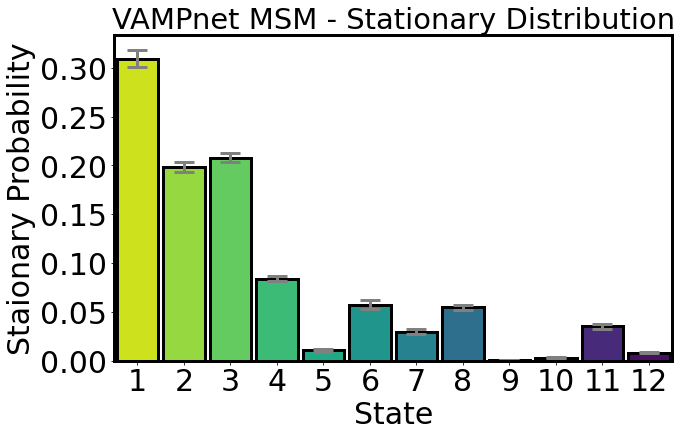

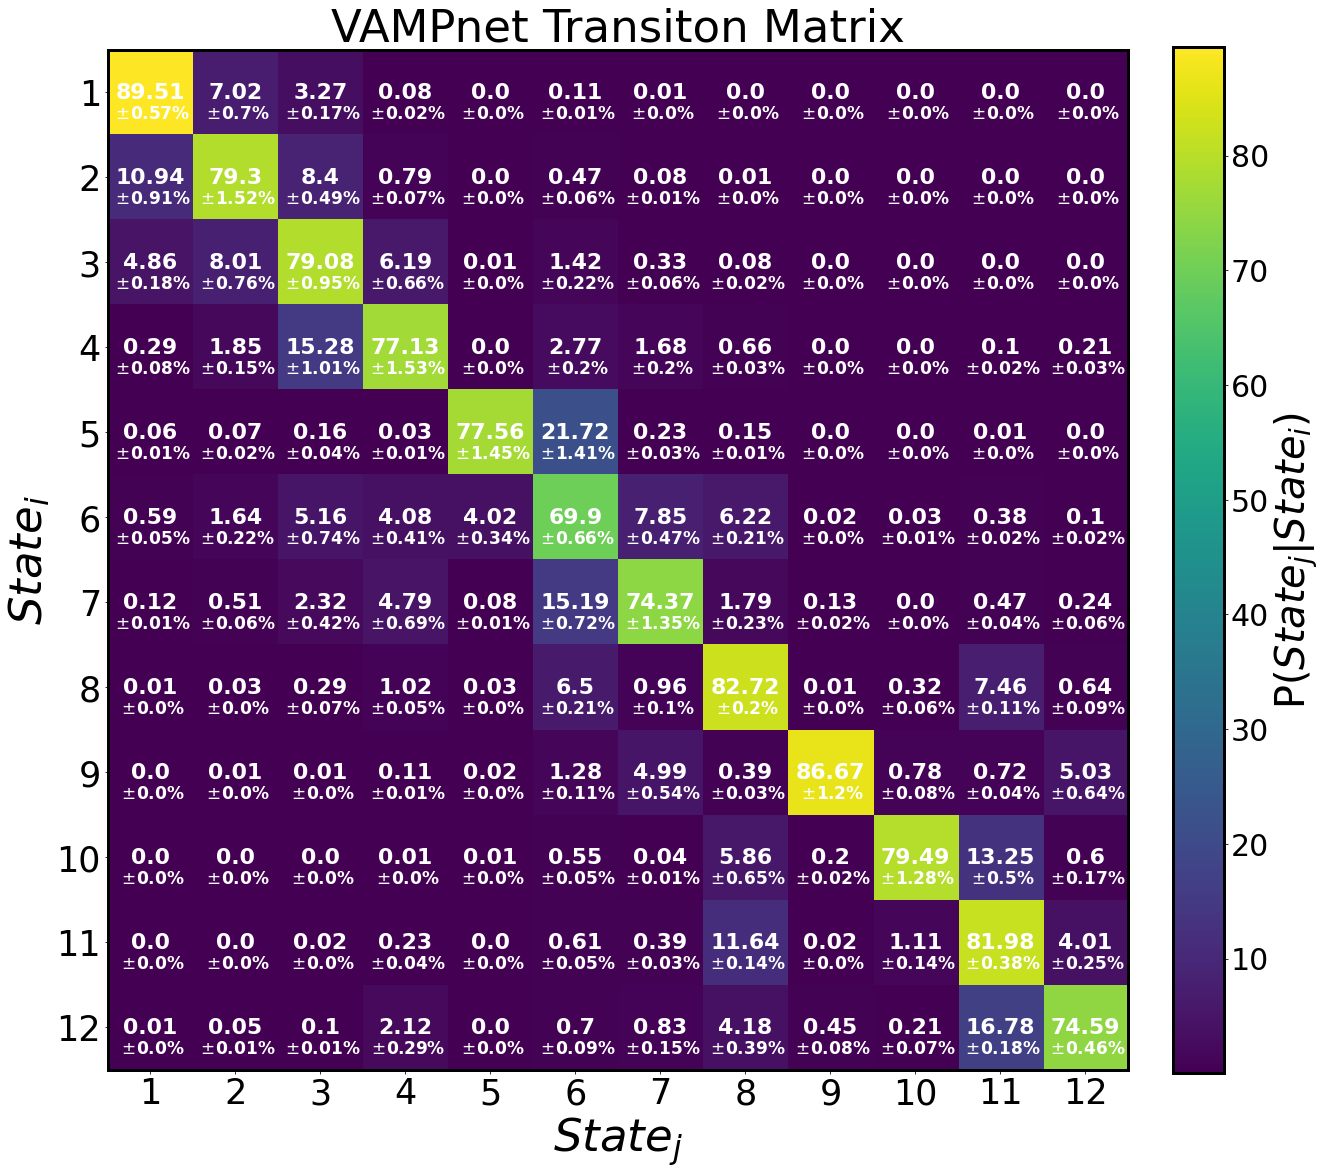

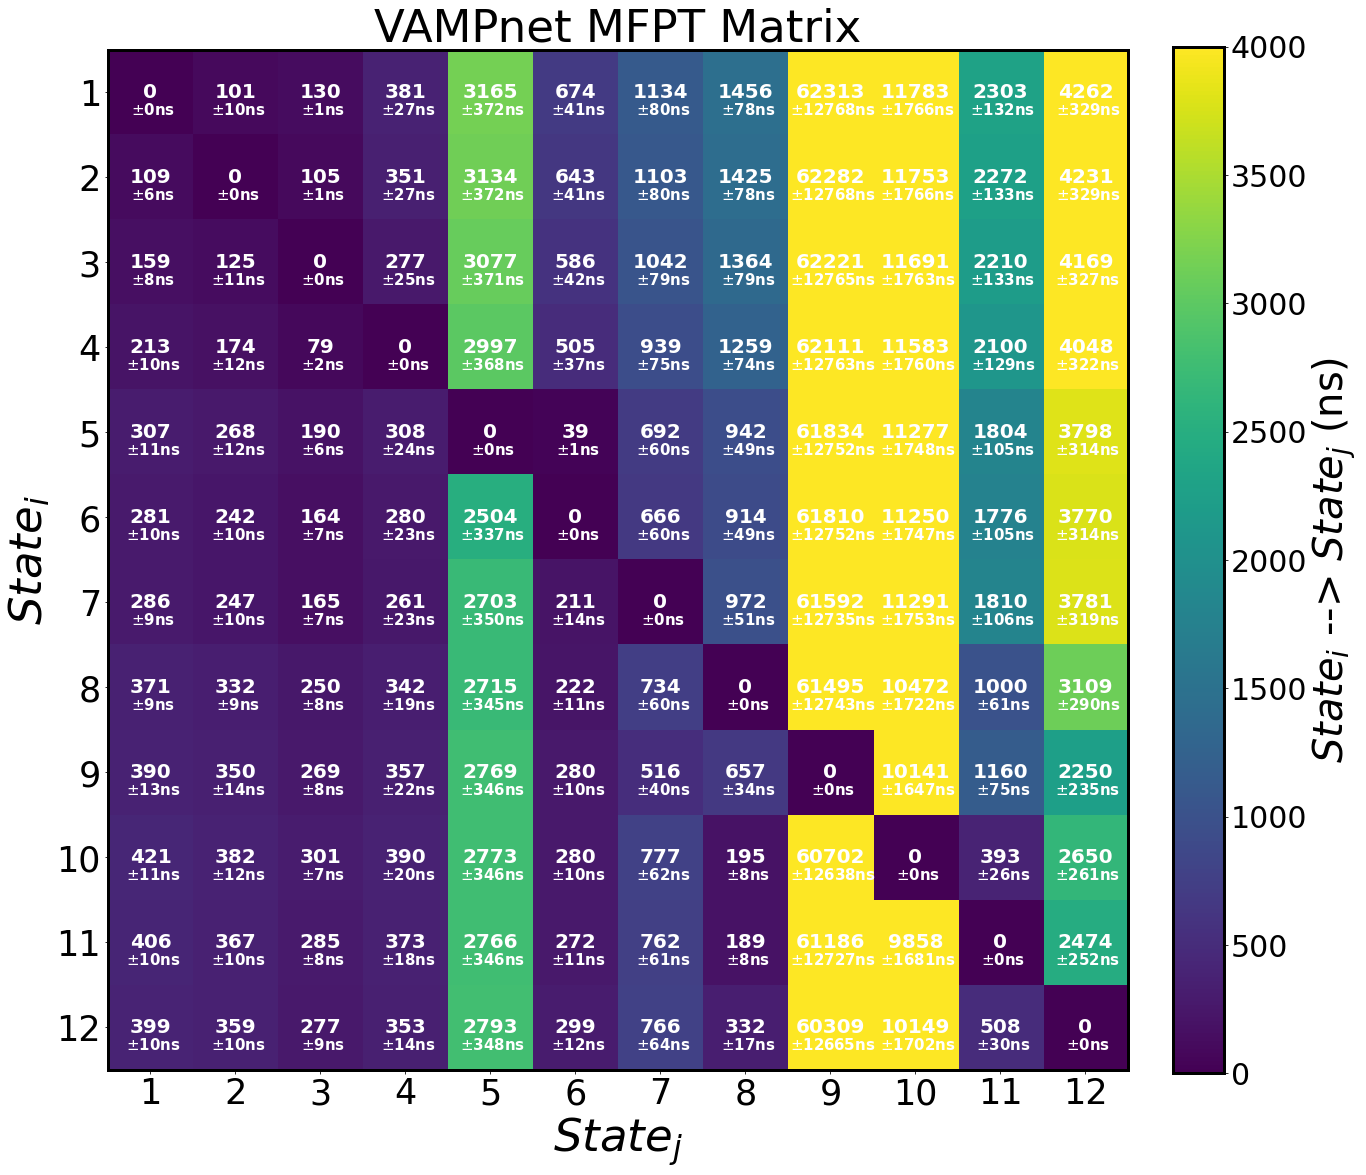

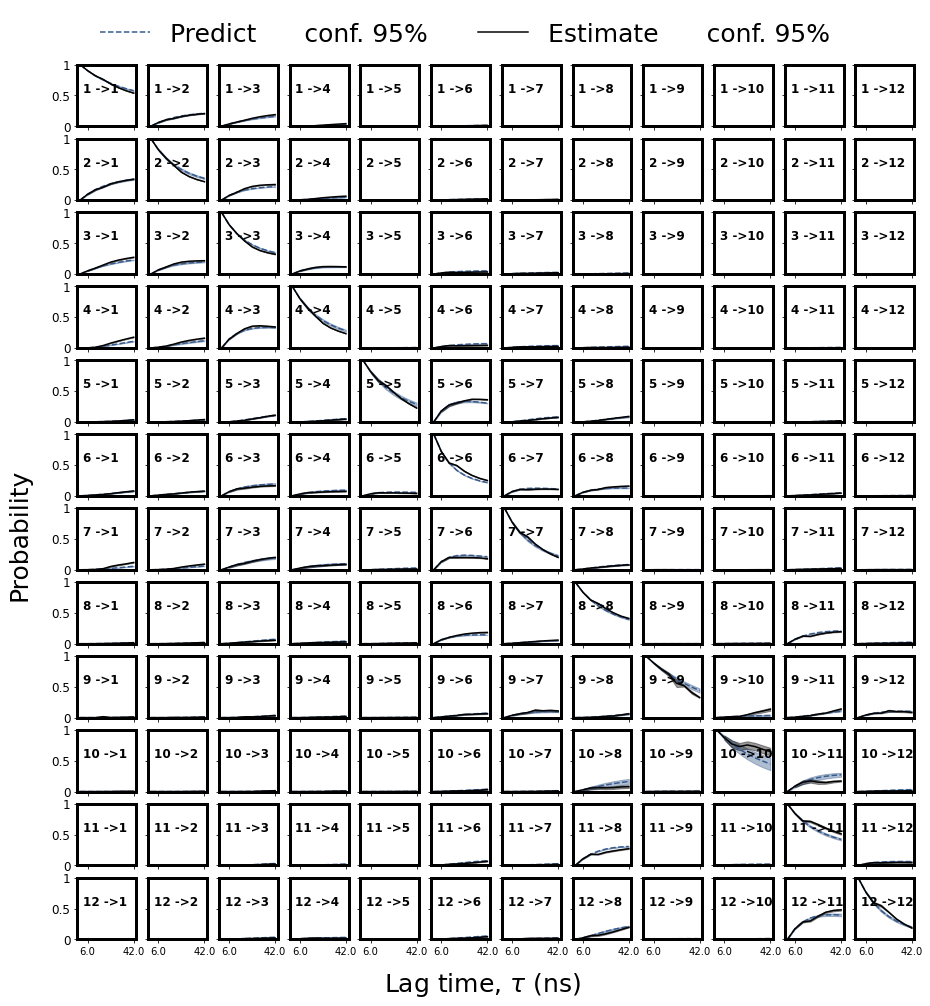

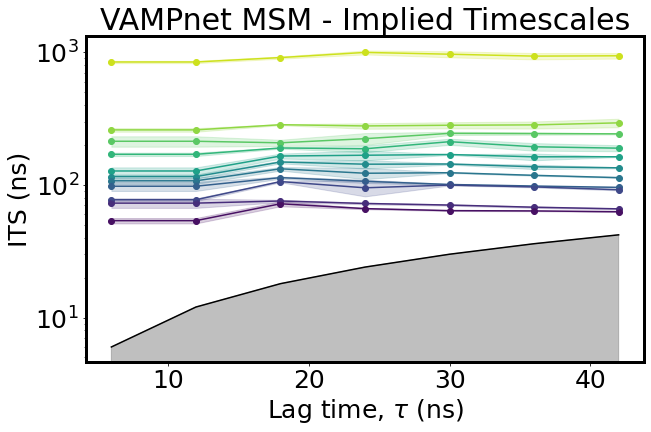

In [37]:
#make colors for each state to keep consistency between plots
ticklabs = np.arange(1,13).astype(str).tolist()
nstates = 12
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

#get stationary distribution
stat_dist_all = np.stack([np.load(i+"/train_stationary_distribution.npy") for i in ckpts],axis = 0)[:,d["reindex"]]
stat_dist_mean = stat_dist_all.mean(0)
stat_dist_ci = np.apply_along_axis(func1d = ci, axis = 0, arr = stat_dist_all, iv = .99, mean = False, single_value = True)

#plot stationary distribution
plt.figure(figsize = (10,6))
plt.bar(np.arange(1,13),stat_dist_mean,yerr = stat_dist_ci,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))
plt.xticks(np.arange(1,13), ticklabs)
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title("VAMPnet MSM - Stationary Distribution",size=29)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlim(.5,12.5)

#get transition matrix
transition_matrix_all = np.stack([reindex_matrix(np.load(i+"/train_transition_matrix.npy"), reindex = d["reindex"]) for i in ckpts],axis = 0)
transition_matrix_mean = transition_matrix_all.mean(0)
transition_matrix_ci = np.apply_along_axis(func1d = ci, axis = 0, arr = transition_matrix_all, iv = .99, single_value = True, mean = False)
#plot transition matrix
plot_mat_error(mat = 100*transition_matrix_mean,emat = 100*transition_matrix_ci,title = "VAMPnet Transiton Matrix",unit = "%",
               cbarlabel = r"P($State_{j}$|$State_{i}$)", val_text_size = 22, err_text_size = 17, textcolor = "white",
               cmap = "viridis",ticklabs = ticklabs)

#get mean first passage times
mfpt_matrix_all = np.stack([mfpt_mat(i/i.sum(1)[:,None],30,.2) for i in transition_matrix_all])
mfpt_matrix_mean = mfpt_matrix_all.mean(0)
mfpt_matrix_ci = np.apply_along_axis(func1d = ci, axis = 0, arr = mfpt_matrix_all, iv = .99, single_value = True, mean = False)
mfpt_matrix_ci[np.isnan(mfpt_matrix_ci)] = 0
#plot mean first passage times
plot_mat_error(mat = mfpt_matrix_mean,emat = mfpt_matrix_ci,title = "VAMPnet MFPT Matrix",unit = "ns",
               cbarlabel = r"$State_{i}$ --> $State_{j}$ (ns)",val_text_size = 20, err_text_size = 15,textcolor = "white",cmap = "viridis",
               ticklabs = ticklabs,clims = [0,4000], round_int = True)

#get ck test
ck_all = np.stack([np.load(i+"/ck_test.npy") for i in all_ckpts], axis = 1)
ck_mean = ck_all.mean(1)
ck_pred_err = np.apply_along_axis(func1d = ci,axis=0, arr = ck_all[0], iv = .99)
ck_est_err = np.apply_along_axis(func1d = ci,axis=0, arr = ck_all[1], iv = .99, mean = True)

#plot ck test
plot_cktest(predict = ck_mean[0], estimate = ck_mean[1], lag = 30, dt = 0.2,
            predict_errors = ck_pred_err, estimate_errors = ck_est_err,predict_color = clist[8],fill_estimate = True)
    
#get ITS
its_all = np.stack([np.load(i+"/its_test.npy") for i in ckpts],axis = 1)
its_mean = its_all.mean(1)
its_pred_err = np.apply_along_axis(func1d = ci,axis=0, arr = its_all[0], iv = .99)
its_est_err = np.apply_along_axis(func1d = ci,axis=0, arr = its_all[1], iv = .99, mean = True)
#plot ITS
plot_its(its_mean[-1], lag = 30, estimate_error = its_est_err, dt = .2,cmap =plt.cm.viridis, title = "VAMPnet MSM - Implied Timescales" )

 # Plot Bootstrapped Structural Charaterizations of states

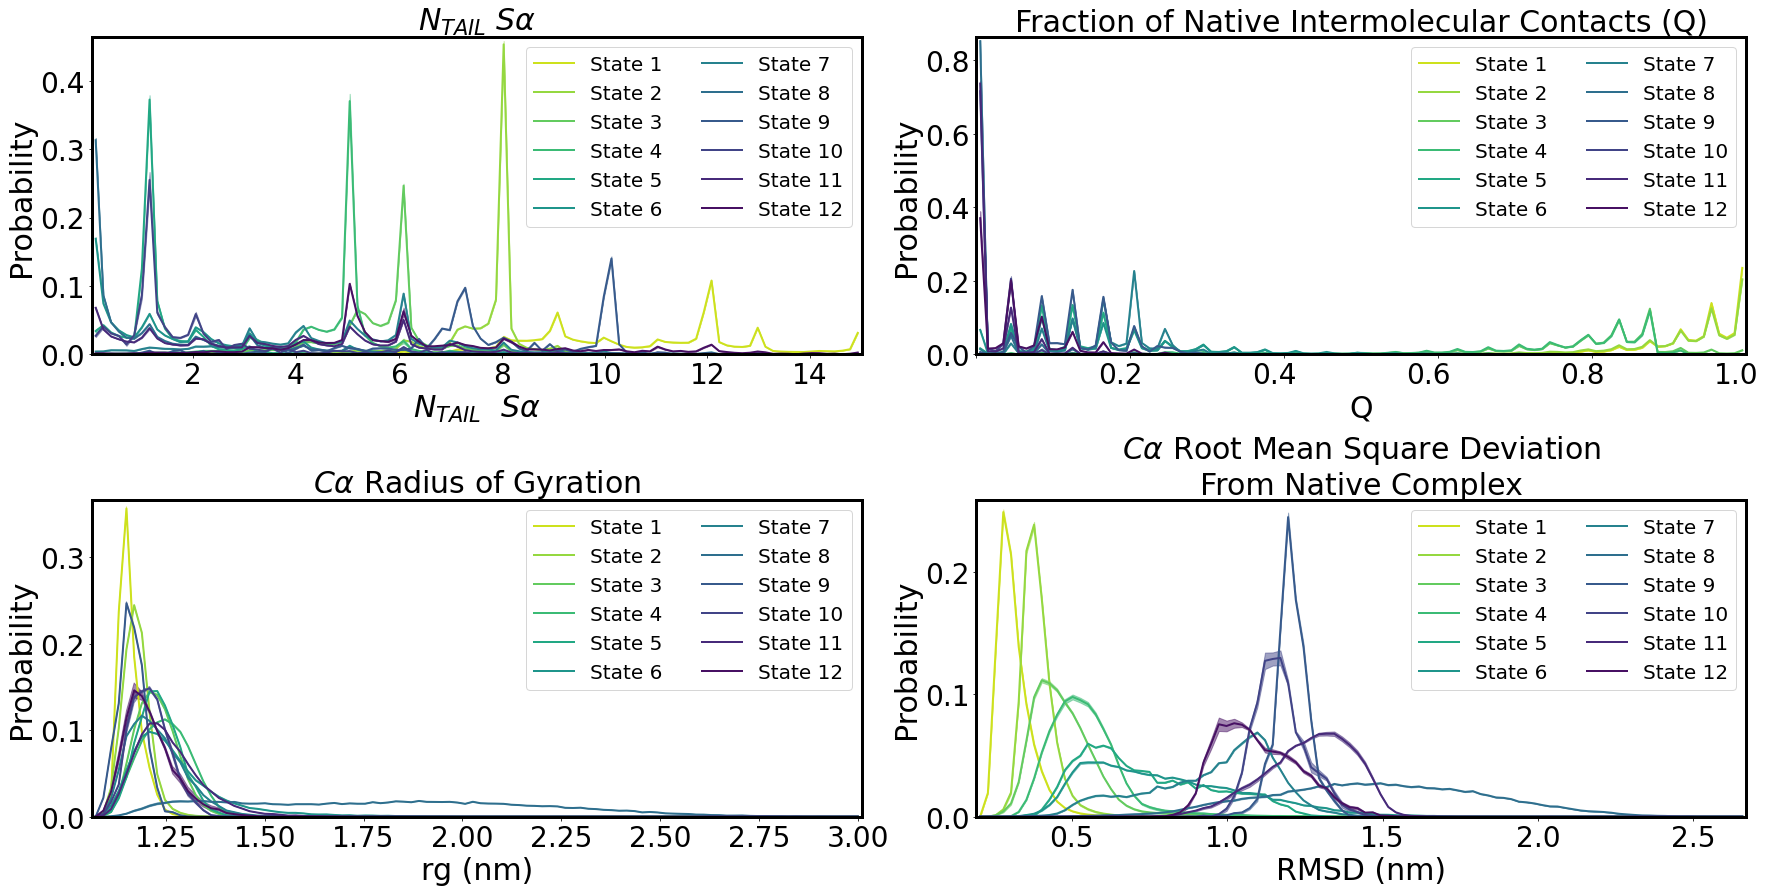

In [49]:
#summarize statistics from trials/bootstrap
ave_distances = bagged_stat(all_ckpts, "inter_dist", "inter_dist", compute_ci = True)
ave_dssps = bagged_stat(all_ckpts, "dssp", "dssps", compute_ci = True)
ave_contacts = bagged_stat(all_ckpts, "inter_contact", compute_ci = True)
stat_dict = {i:bagged_stat(all_ckpts, i, compute_ci = True, compute_sd = True, distribution = True) for i in "Sa_total,QP,rg,rmsd,ang,R".split(",")}
#PLOT
import matplotlib.colors as colors
import matplotlib
nstates = 12
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

fig, axes = plt.subplots(2,2,figsize=(25,12.5))
titles = [r"$N_{TAIL}$ $S\alpha$", "Fraction of Native Intermolecular Contacts (Q)",
          r"$C\alpha$ Radius of Gyration", 
          r"$C\alpha$ Root Mean Square Deviation" +"\n" + "From Native Complex"]
x_lab = [r'$N_{TAIL}$  $S\alpha$', "Q", r"rg (nm)", "RMSD (nm)"]

for title, lab, var,ax in zip(titles, x_lab, "Sa_total,QP,rg,rmsd".split(","), axes.flat):
    ax.set_title(title,size=30)
    ax.set_xlabel(lab, size=30)
    ax.set_ylabel("Probability", size=30)
    ax.tick_params(labelsize = 28)
    if lab == "Q":
        offset = matplotlib.transforms.ScaledTranslation(2, 0, fig.dpi_scale_trans)
        for label in ax.xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
            ax.set_xticks(np.arange(0,1,.2).round(1),np.arange(.2,1.2,.2).round(1))
    ymax = 0
#     _,bins = np.histogram(d[var], bins = len(stat_dict[var]["dist"]["mean"][0]))
#     x_axis = bins[:-1] + np.diff(bins)/2
    for i in range(12):
        ax.plot(stat_dict[var]["dist"]["bin_centers"],
                stat_dict[var]["dist"]["mean"][i],alpha=1,color=clist[i],label = f"State {i+1}",lw = 2)
        
        ax.fill_between(stat_dict[var]["dist"]["bin_centers"],
                        stat_dict[var]["dist"]["ci95"][0,i],
                        stat_dict[var]["dist"]["ci95"][1,i],
                        color = clist[i], alpha = 0.5)
        
        ax.legend(fontsize=20,ncol = 2)
        ax.set_xlim(d[var].min(),d[var].max())
        ymax = max(ymax,stat_dict[var]["dist"]["mean"][i].max())
        #ax.tick_params(axis="both", labelsize = 18)
        ax.set_ylim(0,ymax+.01)
plt.tight_layout()

 # Hydrogen bonding summary for Ntail SER491

In [48]:
#Hbond Summary
hbond_stats = []
for i in d["hbond_names"]:
    s = bagged_stat(all_ckpts,i,i , compute_sd = True, compute_ci = True, make_df = True)
    display(s.round(4)*100)
    hbond_stats.append(s)
    

$<K489N-K489NH--S491O>$  95% CI of mean  $K489N-K489NH--S491O_{\sigma}$
1                     10.93            0.06                           31.21
2                      5.35            0.03                           22.51
3                      0.76            0.02                            8.70
4                      0.03            0.00                            1.66
5                      0.01            0.00                            1.02
6                      0.11            0.01                            3.35
7                      0.01            0.00                            0.95
8                      0.00            0.00                            0.47
9                      0.00            0.00                            0.03
10                     0.00            0.00                            0.00
11                     0.00            0.00                            0.04
12                     0.00            0.00                            0.06

$<S491O-S491OH--D493O1>$  95% CI of mean  $S491O-S491OH--D493O1_{\sigma}$
1                      21.39            0.04                            41.01
2                      29.06            0.23                            45.40
3                       3.47            0.04                            18.30
4                       0.12            0.03                             3.51
5                       0.17            0.00                             4.14
6                       0.56            0.04                             7.43
7                       0.05            0.01                             2.19
8                       0.02            0.00                             1.32
9                       0.00            0.00                             0.44
10                      0.00            0.00                             0.07
11                      0.01            0.00                             1.07
12                      0.21            0.01                             4.62

$<S491O-S491OH--D493O2>$  95% CI of mean  $S491O-S491OH--D493O2_{\sigma}$
1                      20.85            0.04                            40.63
2                      28.21            0.23                            45.00
3                       3.44            0.04                            18.21
4                       0.12            0.02                             3.52
5                       0.19            0.01                             4.31
6                       0.58            0.03                             7.60
7                       0.05            0.01                             2.16
8                       0.02            0.00                             1.26
9                       0.00            0.00                             0.41
10                      0.00            0.00                             0.04
11                      0.00            0.00                             0.70
12                      0.15            0.01                             3.88

$<any>$  95% CI of mean  $any_{\sigma}$
1     43.45            0.05           49.57
2     52.96            0.42           49.91
3      6.60            0.08           24.83
4      0.24            0.05            4.85
5      0.34            0.01            5.79
6      1.09            0.06           10.36
7      0.09            0.02            2.98
8      0.03            0.00            1.76
9      0.00            0.00            0.57
10     0.00            0.00            0.07
11     0.02            0.00            1.23
12     0.33            0.02            5.74

In [20]:
#use dataframe option for summary
Qbagged = bagged_stat(all_ckpts,"QP","Q" , compute_sd = True, compute_ci = True, make_df = True)
SAbagged = bagged_stat(all_ckpts,"Sa_total",f"S{symbols['alpha']}",compute_sd = True, compute_ci = True, make_df = True)
RGbagged = bagged_stat(all_ckpts,"rg","rg",compute_sd = True, compute_ci = True, make_df = True)

QSAbagged = pd.concat([Qbagged,SAbagged, RGbagged], axis =1)
display(QSAbagged)

$<Q>$  95% CI of mean  $Q_{\sigma}$     $<Sα>$  95% CI of mean  \
1   0.927896        0.000313      0.085710  10.608448        0.028438   
2   0.910363        0.002843      0.108058   7.663442        0.008462   
3   0.761722        0.005680      0.167360   5.719368        0.008973   
4   0.727964        0.012209      0.185976   4.741878        0.018095   
5   0.168273        0.000323      0.098794   1.271650        0.009212   
6   0.193137        0.002055      0.158131   1.947187        0.044326   
7   0.182954        0.001656      0.089522   5.047409        0.020386   
8   0.014757        0.000592      0.049111   1.528838        0.011878   
9   0.137858        0.000470      0.059458   7.590163        0.015129   
10  0.012591        0.001108      0.022538   1.888479        0.058989   
11  0.017407        0.000706      0.036790   3.599693        0.023928   
12  0.052259        0.001039      0.058087   6.516402        0.083526   

    $Sα_{\sigma}$    $<rg>$  95% CI of mean  $rg_{\sigma}$  
1        2.126254  1.159159        0.000265       0.027892  
2        0.916310  1.175216        0.000281       0.033554  
3        1.287266  1.226969        0.000579       0.054077  
4        1.081084  1.249039        0.000750       0.065937  
5        0.785958  1.233020        0.000134       0.054163  
6        1.959293  1.276442        0.002164       0.128851  
7        2.317872  1.229525        0.000895       0.077432  
8        1.857119  1.796590        0.005928       0.381122  
9        2.198519  1.163468        0.000438       0.032757  
10       1.690805  1.210373        0.002121       0.050109  
11       2.603157  1.259602        0.000456       0.096693  
12       2.703591  1.209803        0.005637       0.064457

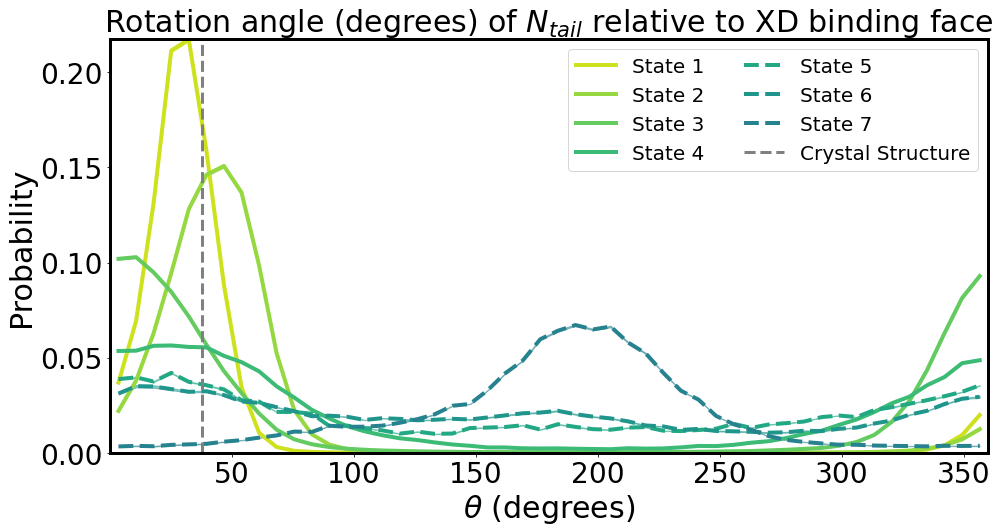

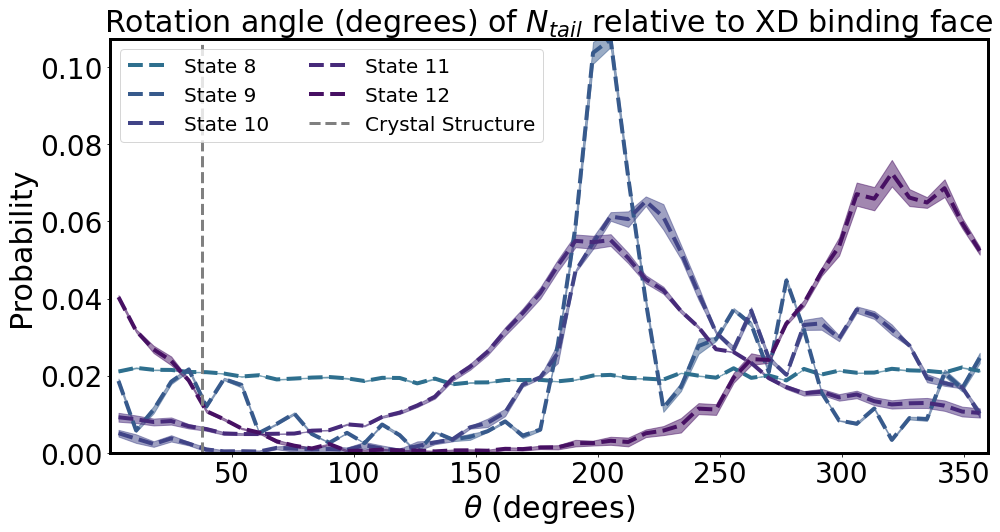

In [21]:
##fine tune colors for these plots
fig, ax = plt.subplots(1,figsize=(14,7.5))
ax.set_title("Rotation angle (degrees) of $N_{tail}$ relative to XD binding face",size=30)
ax.set_xlabel(r"$\theta$ (degrees)", size=30)
ax.set_ylabel("Probability", size=30)
ax.tick_params(labelsize = 28)
ymax = 0
var = "ang"

for i in range(7):
    if i>3:
        ax.plot(stat_dict[var]["dist"]["bin_centers"],
            stat_dict[var]["dist"]["mean"][i],alpha=1,color=clist[i],label = f"State {i+1}",lw = 4, ls = "--") 
        
    else:
        ax.plot(stat_dict[var]["dist"]["bin_centers"],
                stat_dict[var]["dist"]["mean"][i],alpha=1,color=clist[i],label = f"State {i+1}",lw = 4)

    ax.fill_between(stat_dict[var]["dist"]["bin_centers"],
                    stat_dict[var]["dist"]["ci95"][0,i],
                    stat_dict[var]["dist"]["ci95"][1,i],
                    color = clist[i], alpha = 0.5)

    ax.legend(fontsize=20,ncol = 2)
    ax.set_xlim(d[var].min(),d[var].max())
    ymax = max(ymax,stat_dict[var]["dist"]["mean"][i].max())
    #ax.tick_params(axis="both", labelsize = 18)
    ax.set_ylim(0,ymax)

ax.plot([d[var][0],d[var][0]], [0,ymax+.0001],color = "gray", label="Crystal Structure", lw =3, ls = "--" )
ax.legend(fontsize=20,ncol = 2)

plt.tight_layout()


fig, ax = plt.subplots(1,figsize=(14,7.5))
ax.set_title("Rotation angle (degrees) of $N_{tail}$ relative to XD binding face",size=30)
ax.set_xlabel(r"$\theta$ (degrees)", size=30)
ax.set_ylabel("Probability", size=30)
ax.tick_params(labelsize = 28)
ymax = 0
var = "ang"
for i in range(7,12):
    if i>6:
        ax.plot(stat_dict[var]["dist"]["bin_centers"],
            stat_dict[var]["dist"]["mean"][i],alpha=1,color=clist[i],label = f"State {i+1}",lw = 4, ls = "--")
        
        
    else:
        ax.plot(stat_dict[var]["dist"]["bin_centers"], stat_dict[var]["dist"]["mean"][i],alpha=1,color=clist[i],label = f"State {i+1}",lw = 4)

    ax.fill_between(stat_dict[var]["dist"]["bin_centers"],
                    stat_dict[var]["dist"]["ci95"][0,i],
                    stat_dict[var]["dist"]["ci95"][1,i],
                    color = clist[i], alpha = 0.5)

    ax.legend(fontsize=20,ncol = 2)
    ax.set_xlim(d[var].min(),d[var].max())
    ymax = max(ymax,stat_dict[var]["dist"]["mean"][i].max())
    #ax.tick_params(axis="both", labelsize = 18)
    ax.set_ylim(0,ymax)
    
ax.plot([d[var][0],d[var][0]], [0,ymax+.0001],color = "gray", label="Crystal Structure", lw =3, ls = "--" )
ax.legend(fontsize=20,ncol = 2)
plt.tight_layout()

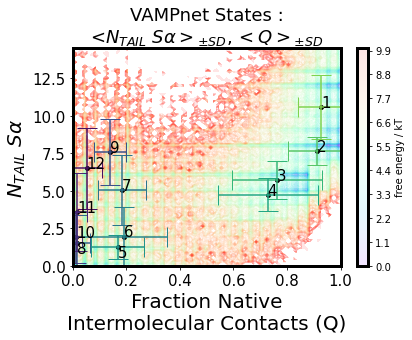

In [22]:
#PLOT
#"fig,ax = plt.subplots(figsize = (50,50))
nstates = 12
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-50,nstates)][::-1]
import pyemma
s = pyemma.plots.plot_free_energy(d["QP"],d["Sa_total"],
                                  cmap = "rainbow", alpha=.1)
plt.xlabel("Fraction Native"+"\n"+ "Intermolecular Contacts (Q)", size = 20);plt.ylabel(r"$N_{TAIL}$ $S\alpha$", size = 20)
plt.tick_params(labelsize=20)
#cbar = plt.colorbar(s,labelsize=18)

plt.title(r"VAMPnet States :"+"\n" r"<$N_{TAIL}$ $S\alpha>_{\pm SD},<Q>_{\pm SD}$", size = 18)
for i,name in enumerate(ticklabs):
    plt.errorbar(x=stat_dict["QP"]["mean"][i],y=stat_dict["Sa_total"]["mean"][i],
                 xerr = stat_dict["QP"]["sd"][i],yerr = stat_dict["Sa_total"]["sd"][i],
                 ls = "none",ms = 0, c =clist[i],capsize=10, alpha = 1, label=True,)
    plt.scatter(stat_dict["QP"]["mean"][i], stat_dict["Sa_total"]["mean"][i], s =15, c = "black")
    if name in ("8","5"):
        plt.annotate(f"{name}", xy=(stat_dict["QP"]["mean"][i], stat_dict["Sa_total"]["mean"][i]-7e-1), size = 15)
    else:
        plt.annotate(f"{name}", xy=(stat_dict["QP"]["mean"][i], stat_dict["Sa_total"]["mean"][i]), size = 15)

        
plt.xlim(0,1)
plt.ylim(0,14.5)
plt.tick_params(axis="both", labelsize=15)

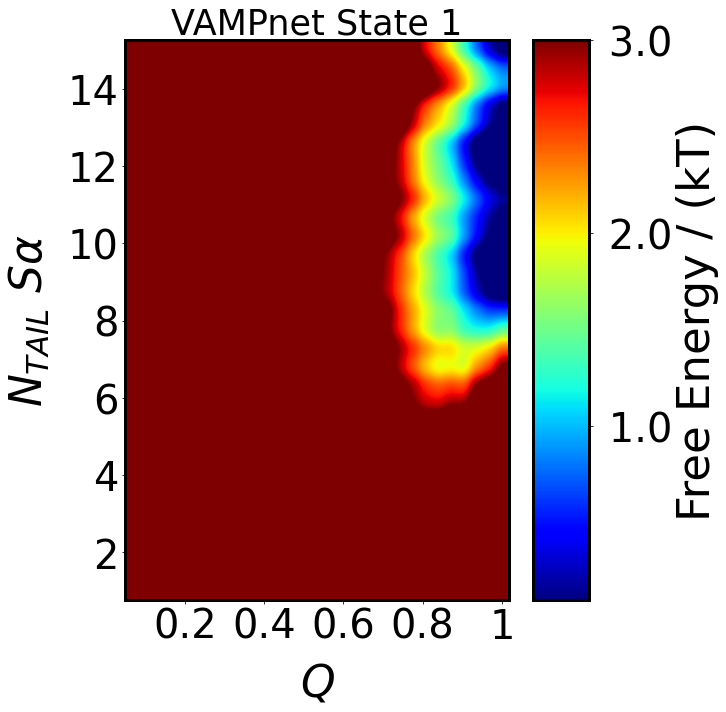

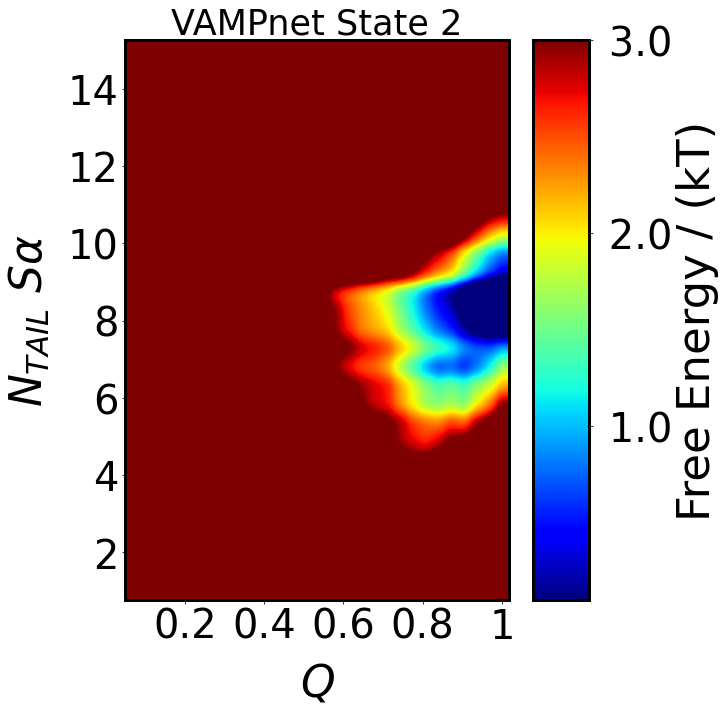

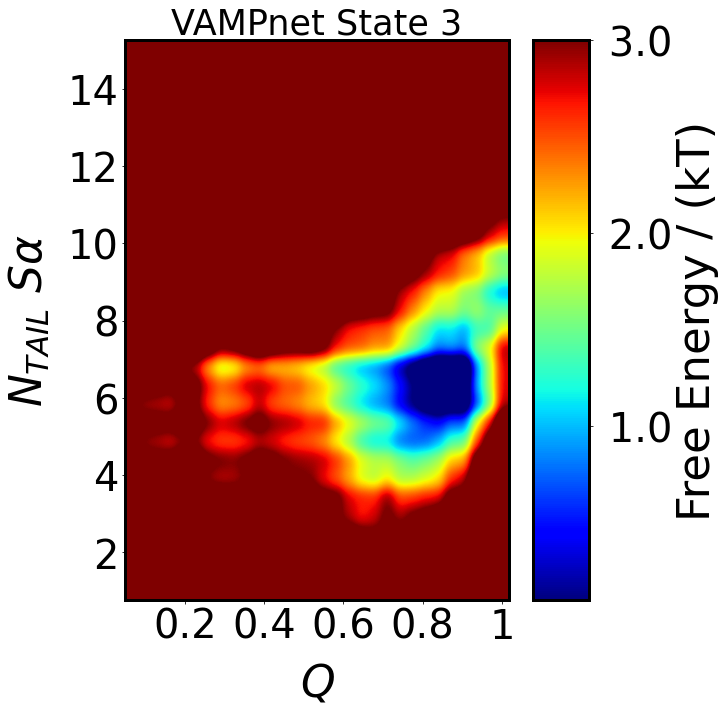

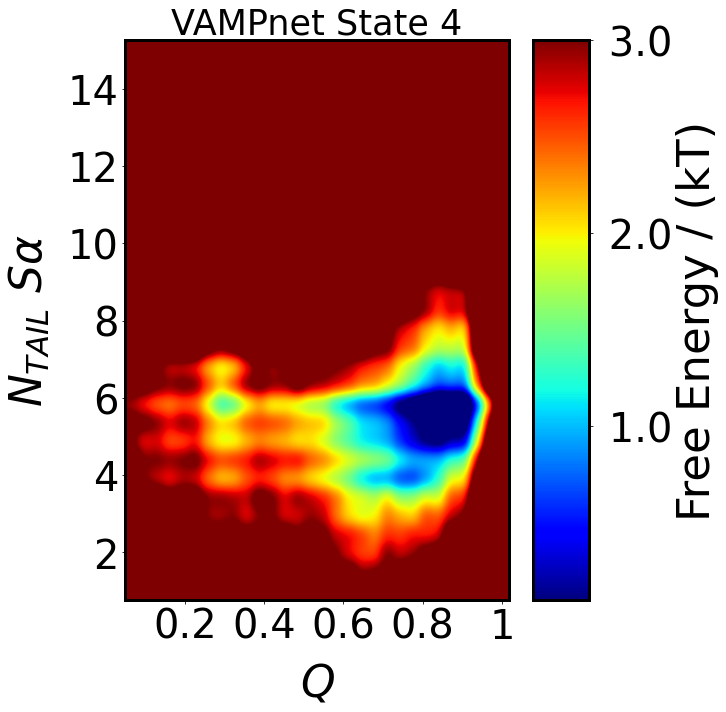

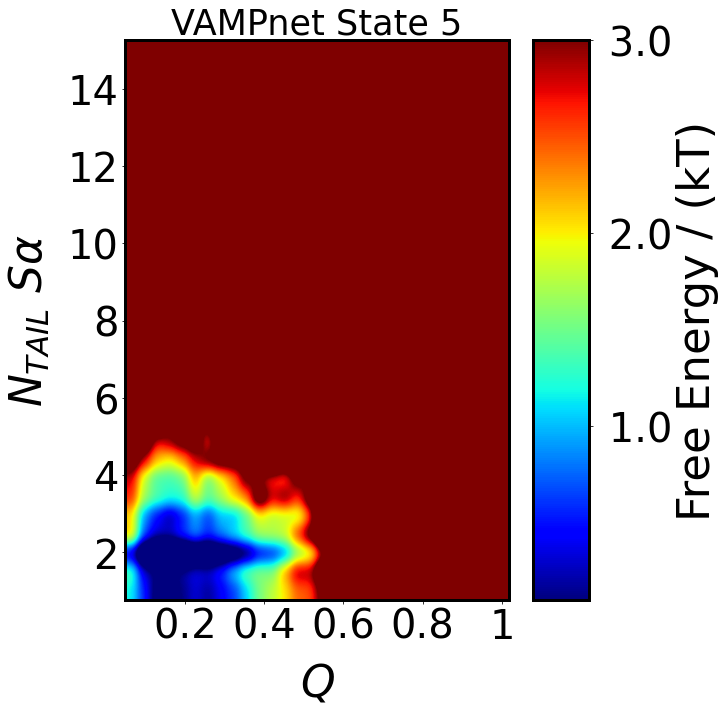

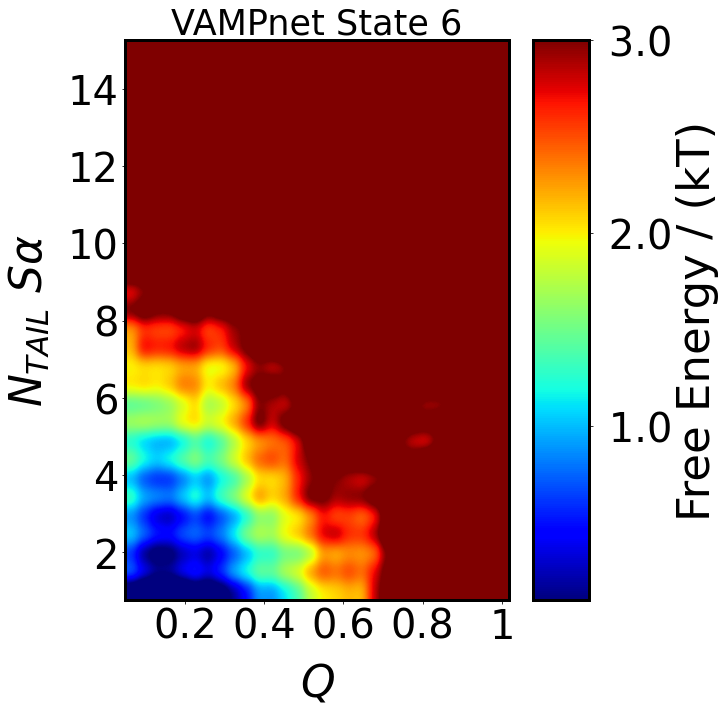

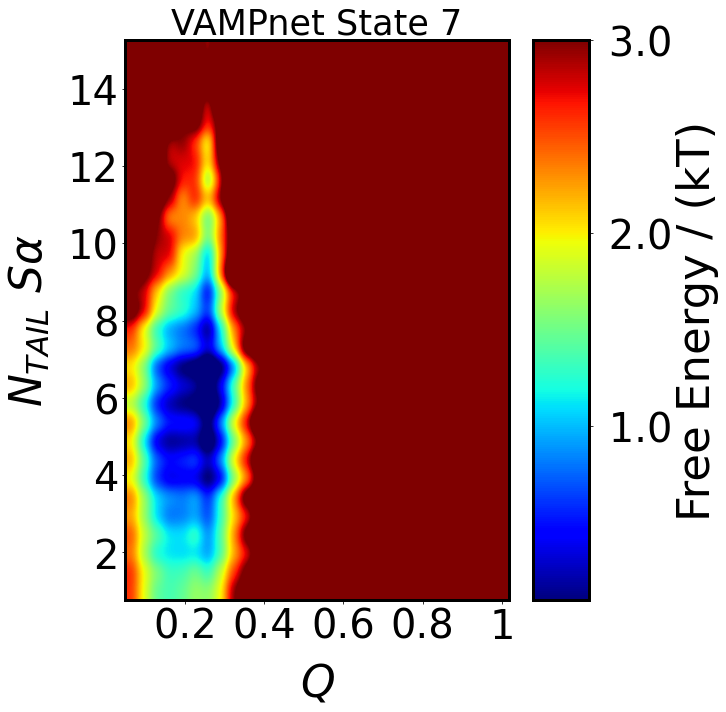

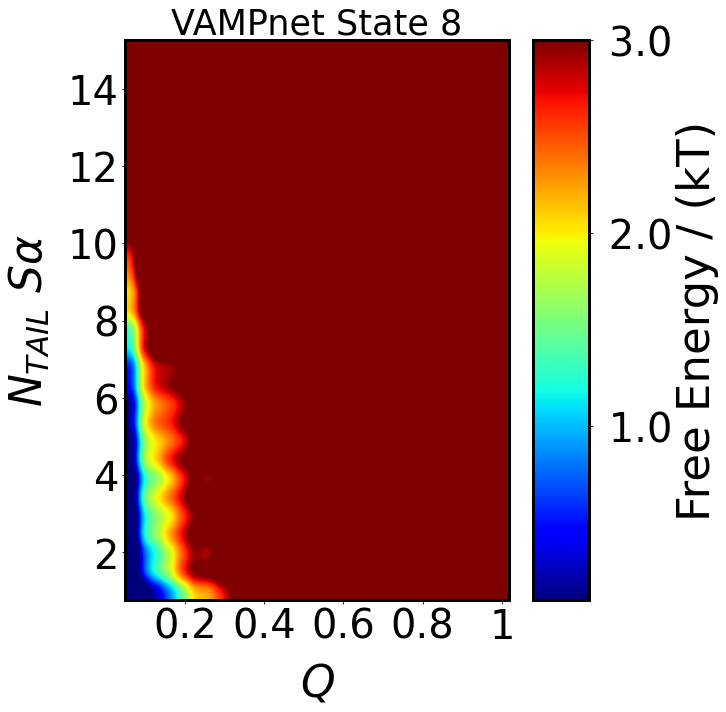

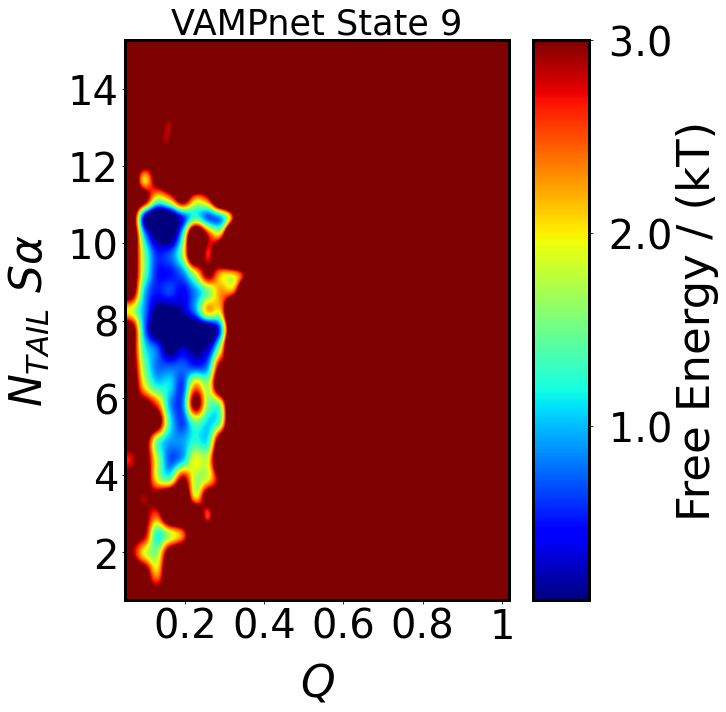

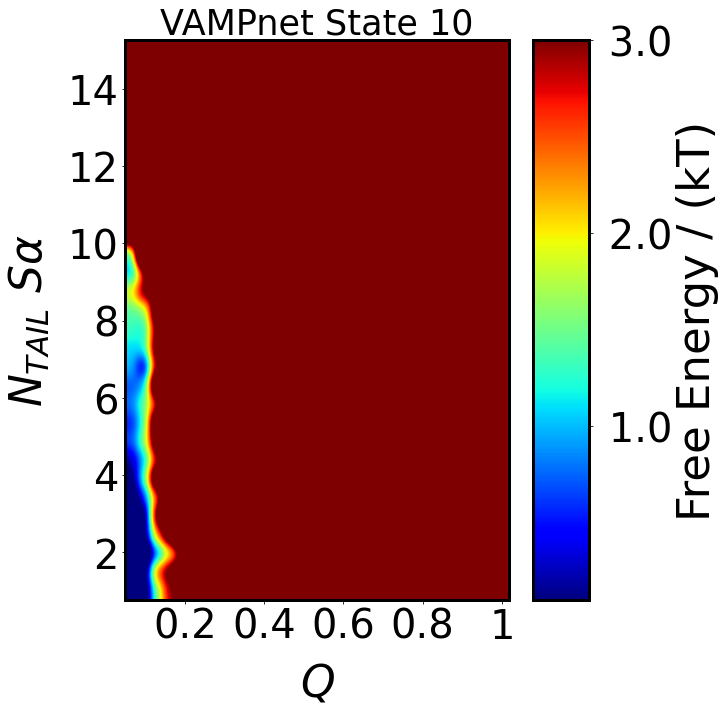

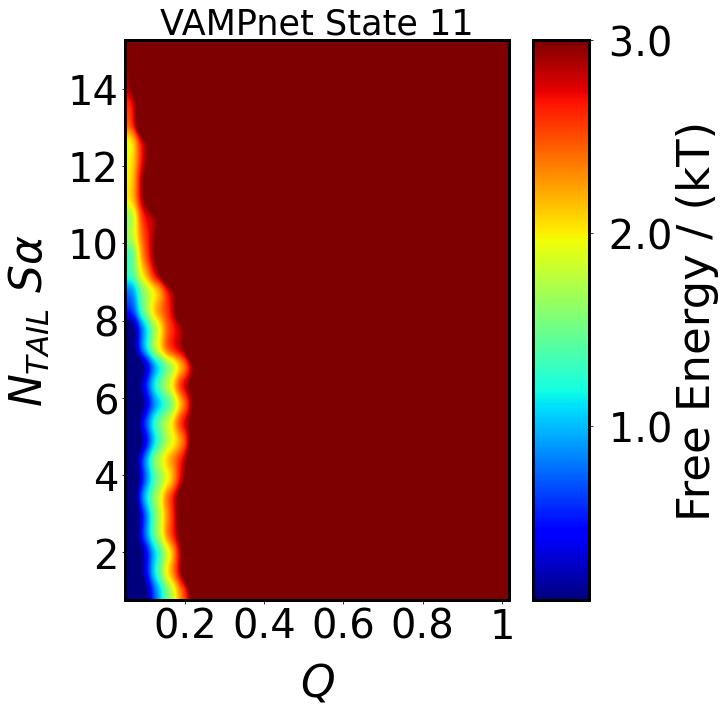

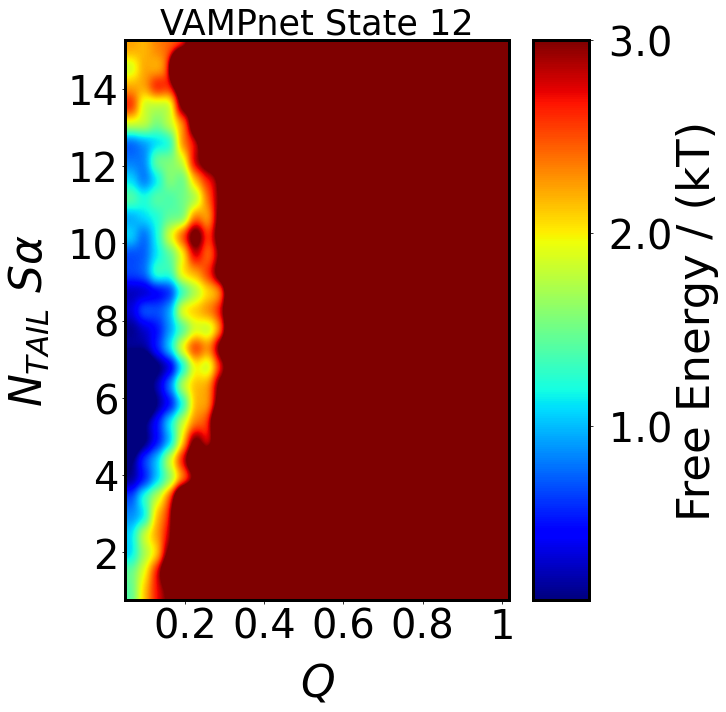

In [23]:
QvSa = bagged_hist2d(ckpt_dirs=all_ckpts, file = "QP.Sa_total" )
for i in range(12):
    plot_free_energy(hist2d = QvSa["mean"][i],T = 400,
                    title = f"VAMPnet State {i+1}",
                    xlabel = r"$Q$",
                    ylabel = r"$N_{TAIL}$ $S\alpha$",
                    x_centers = QvSa["x_centers"],
                    y_centers = QvSa["y_centers"])

In [24]:
koop = KoopmanModel.restore_from_ckpt(ckpts[0])
koop.batch_size = int(8e3)
chi_data = koop.predict_chi()[:,d["reindex"]]
crisp_state_assignments = chi_data.argmax(1)

Chi prediction progress - epoch:104/104 █████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████iter duration: 0.09s/it, eta:0.000 sec


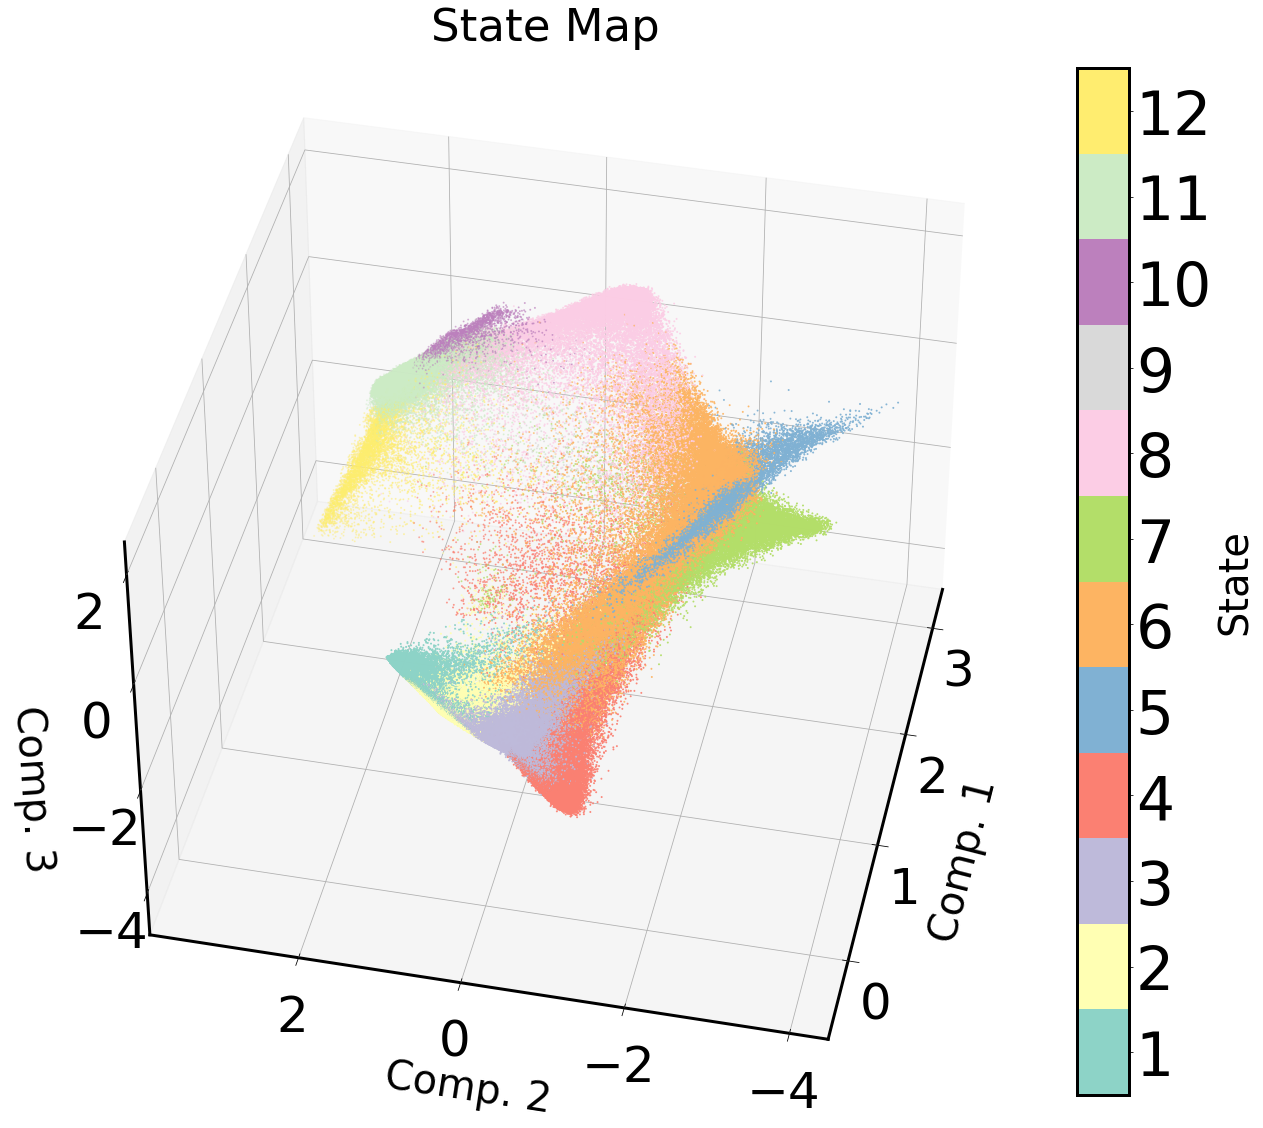

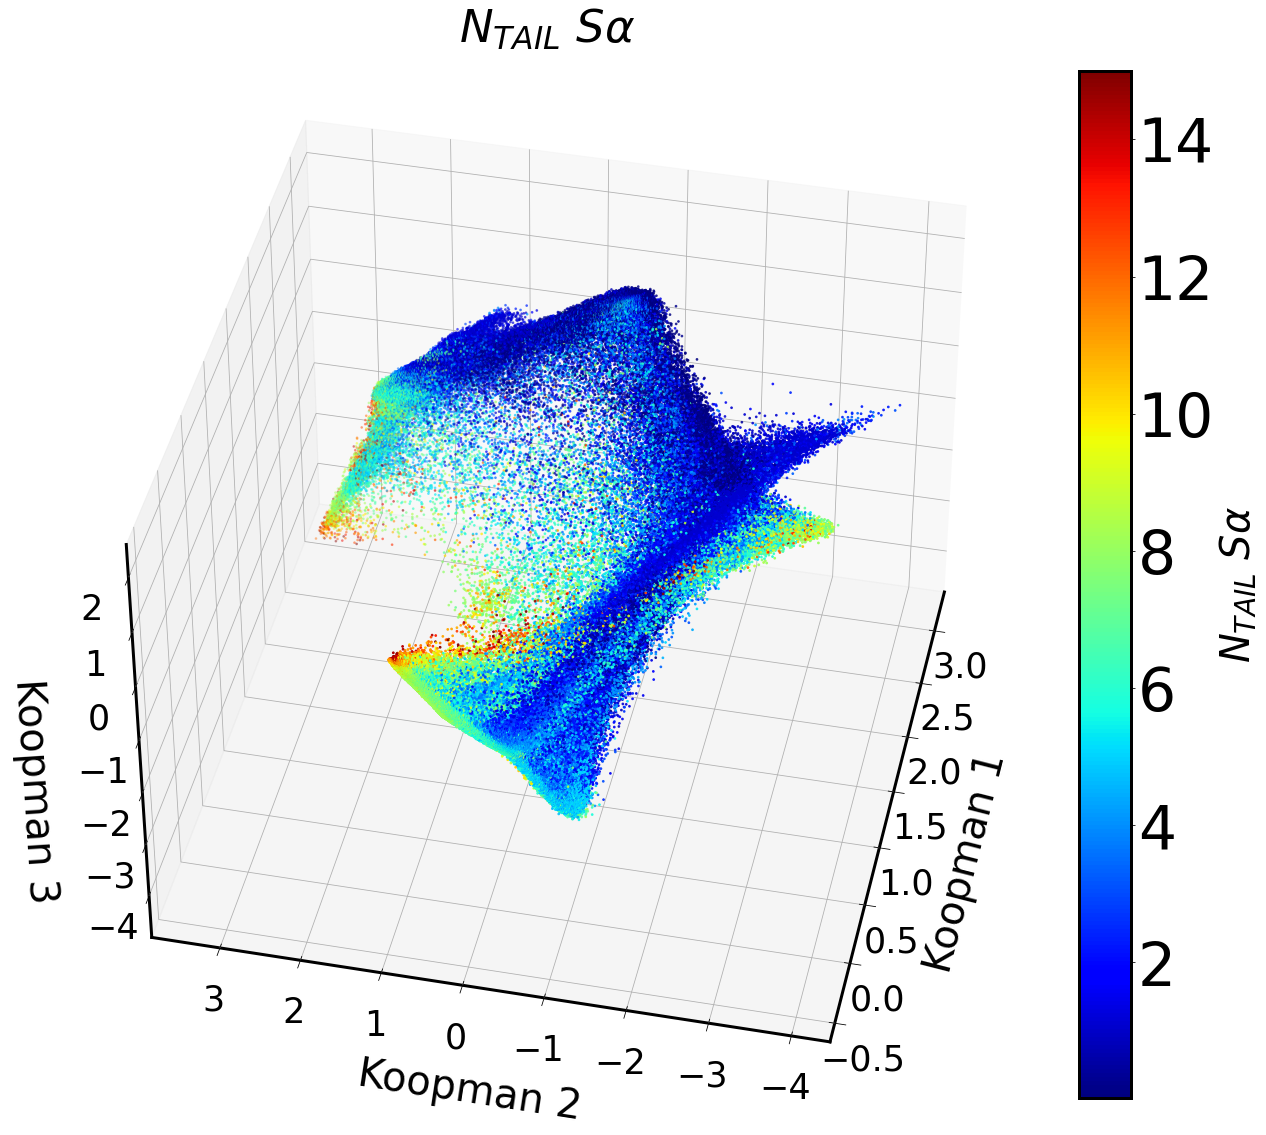

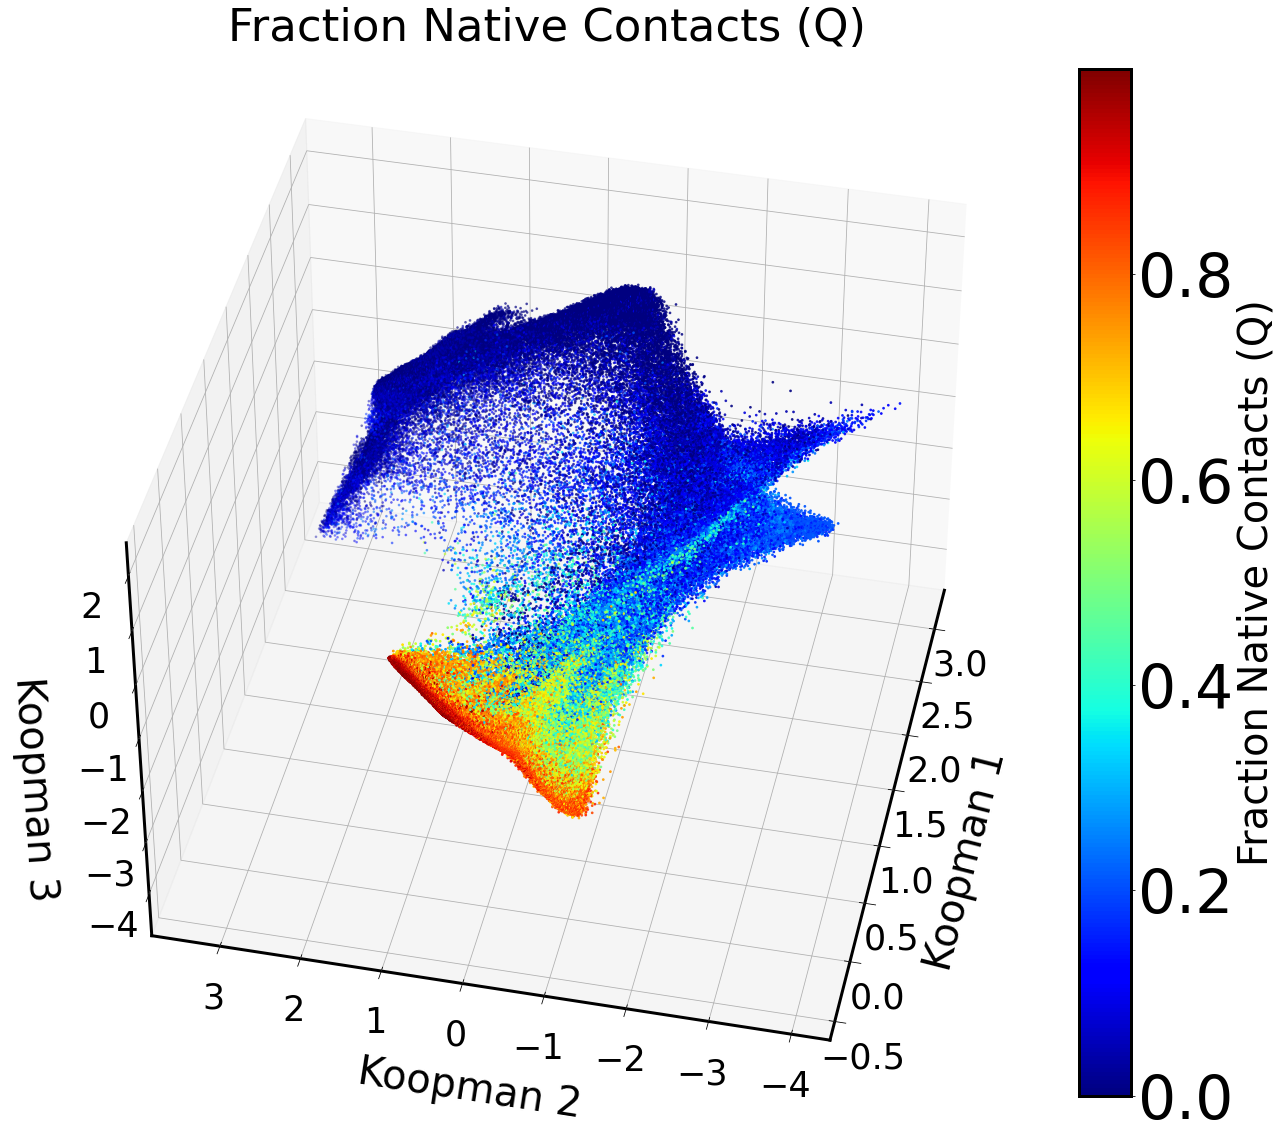

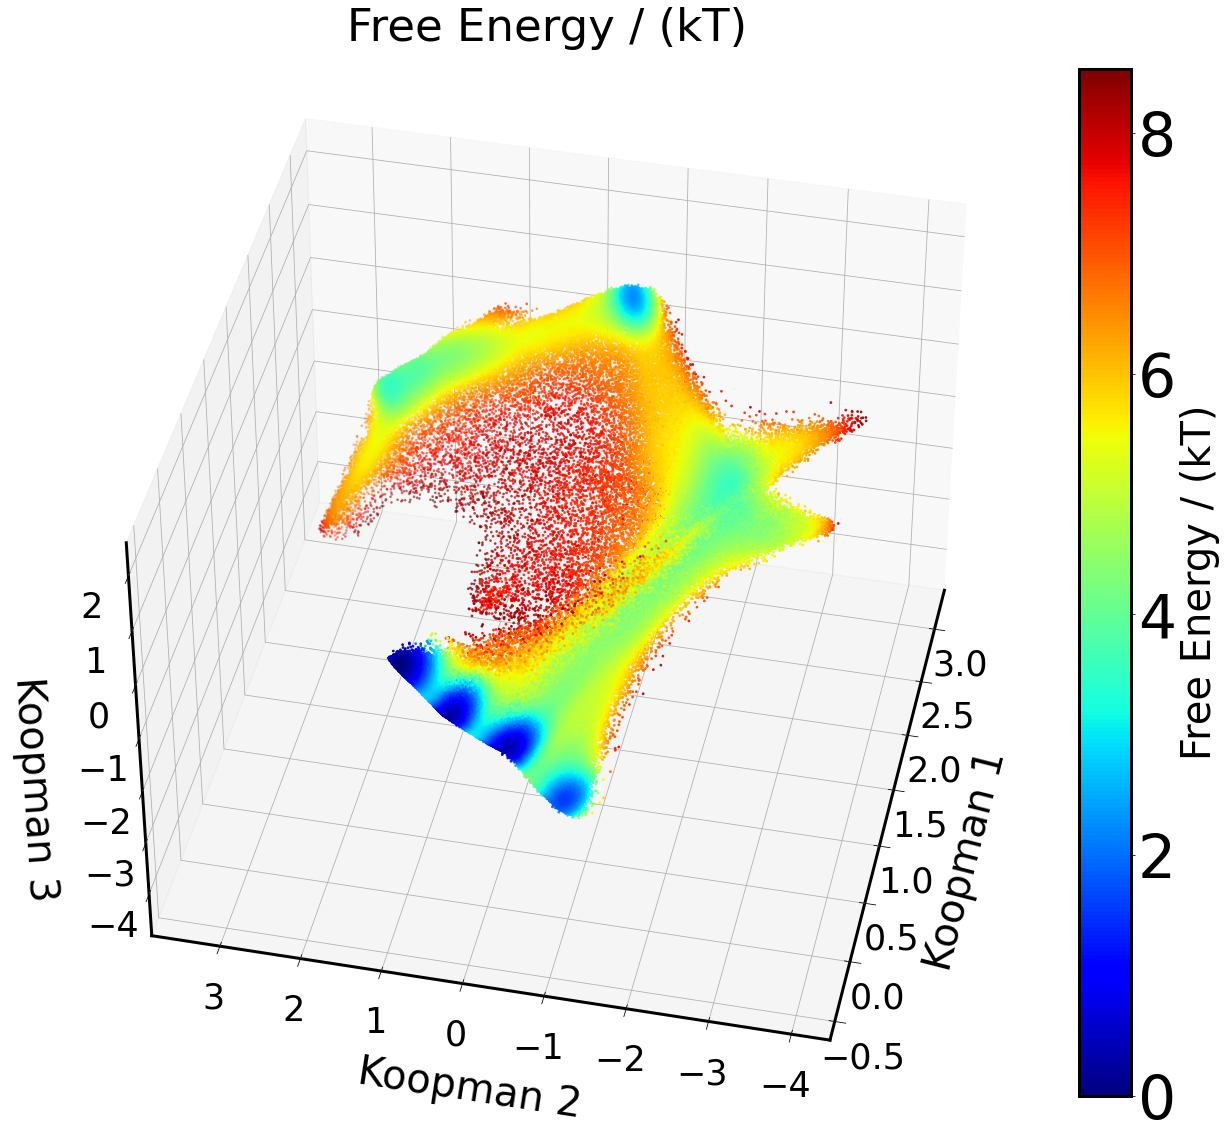

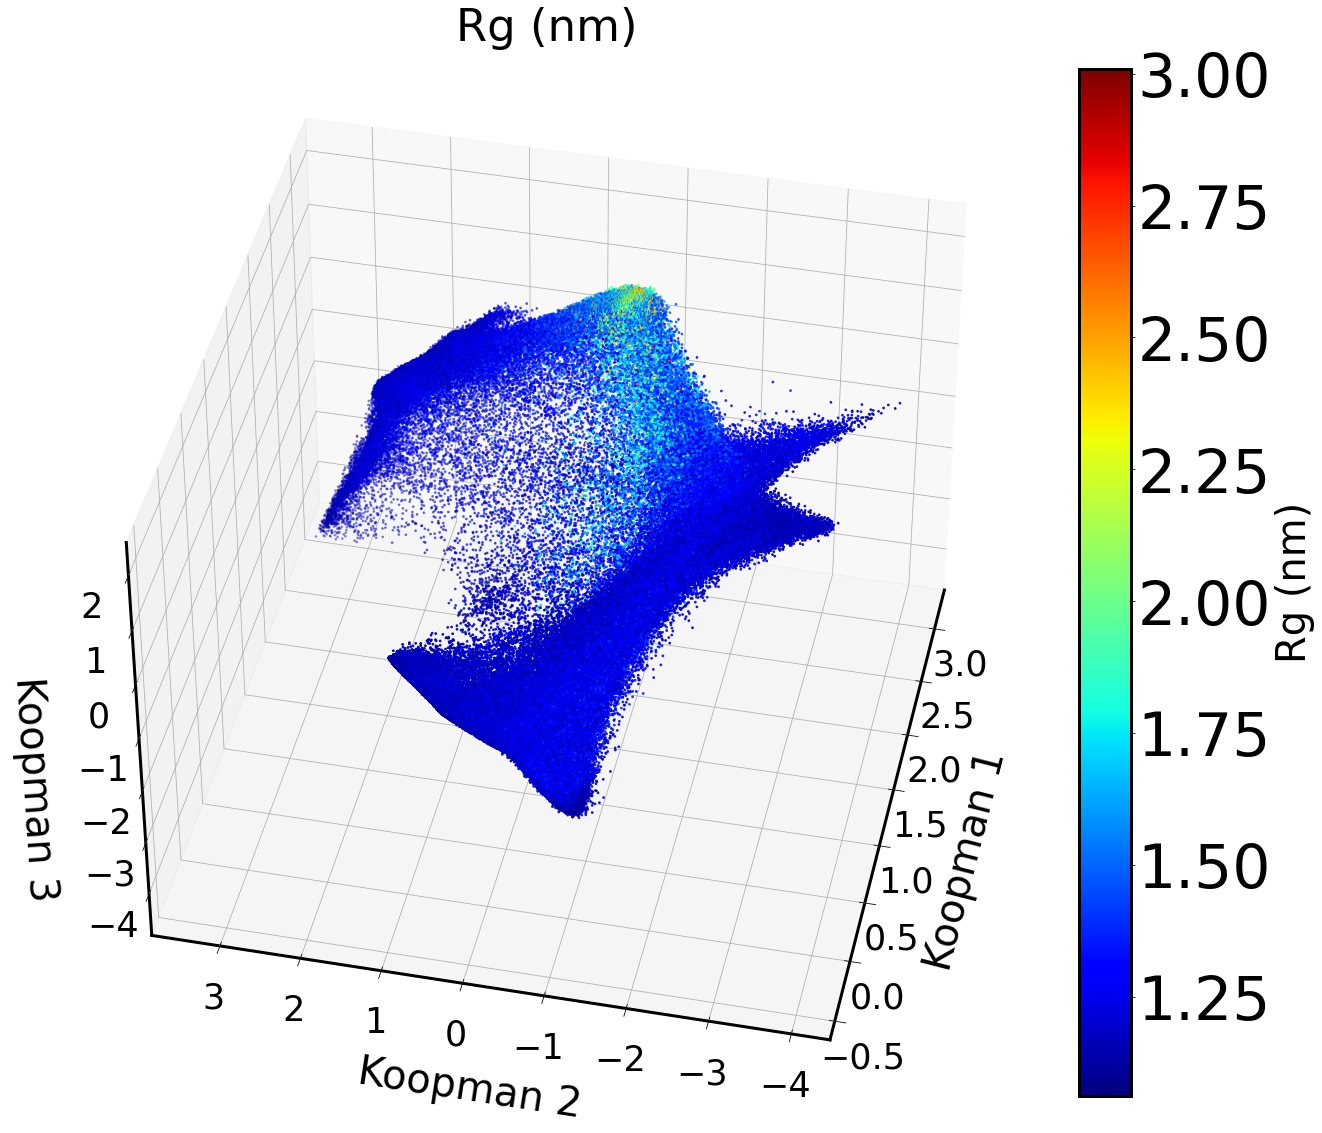

In [25]:
def state_map3d(p:np.ndarray,dtraj:np.ndarray, color_map:"plt.cm.color_map",
                shuffle_colors = False, hide_axes = False, comp_type:str = "Comp."):
    import random
    nstates = dtraj.max()+1
    cs = [color_map(i) for i in range(color_map.N)]
    if shuffle_colors:
        random.shuffle(cs)
    cmap = colors.ListedColormap(cs)
    boundaries = np.arange(nstates+1).tolist()
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    tick_locs = np.arange(nstates) + 0.5
    ticklabels = ticklabs
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(projection='3d')
    s=ax.scatter(xs=p[:,0],ys=p[:,1],zs=p[:,2] ,c=dtraj,s = 1,cmap=cmap, norm = norm)
    ax.view_init(40.7373068432708,-167.74834437086346)
    ls = 40
    ax.set_xlabel(f"{comp_type} 1",size=ls, labelpad = 45)
    ax.set_ylabel(f"{comp_type} 2",size=ls, labelpad = 45)
    ax.set_zlabel(f"{comp_type} 3",size=ls, labelpad = 45)
    ax.set_title("State Map",size = 45)
    cbar = plt.colorbar(s, ax=ax,fraction=0.046, pad=0.0001)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(ticklabels)
    cbar.set_label("State",size=40)
    cbar.ax.tick_params(labelsize=60)
    ax.tick_params(axis='both', which='major', labelsize=50, pad=15)
    #ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlim(p[:,0].min(),p[:,0].max())
    ax.set_ylim(p[:,1].min(),p[:,1].max())
    ax.set_zlim(p[:,2].min(),p[:,2].max())
    #ax.xaxis.set_major_formatter('{x:0<1.0f}')
    if hide_axes:
        ax.set_axis_off()

    plt.draw()
    
    
def proj3d(p:np.ndarray,c:np.ndarray,cbar_label:str = "Magnitude",
           title:str = None, comp_type:str = "Comp.",color_map:str = "jet",
           hide_axes = False):
    if title is None:
        title = cbar_label
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(projection='3d')
    s=ax.scatter(xs=p[:,0],ys=p[:,1],zs=p[:,2] ,c=c,s = 3,cmap=color_map)
    ax.view_init(40.7373068432708,-167.74834437086346)
    ls = 40
    ax.set_xlabel(f"{comp_type} 1",size=ls, labelpad = 45)
    ax.set_ylabel(f"{comp_type} 2",size=ls, labelpad = 45)
    ax.set_zlabel(f"{comp_type} 3",size=ls, labelpad = 45)
    ax.set_title(title,size = 45)
    cbar = plt.colorbar(s, ax=ax,fraction=.046, pad=0.0001)
    #cbar.set_ticks(tick_locs)
    
    cbar.set_label(cbar_label,size=40)
    cbar.ax.tick_params(labelsize=60)
    ax.tick_params(axis='both', which='major', labelsize=35, pad=15)
    #ax.tick_params(axis='both', which='minor', labelsize=30,pad=1)
    ax.set_xlim(p[:,0].min(),p[:,0].max())
    ax.set_ylim(p[:,1].min(),p[:,1].max())
    ax.set_zlim(p[:,2].min(),p[:,2].max())
    if hide_axes:
        ax.set_axis_off()
    plt.draw()
    #ax.xaxis.set_major_formatter('{x:0<1.0f}')
    

fep = -np.log(np.ma.masked_array(d["3d_density"],d["3d_density"]<.001))
fep += -fep.min()

state_map3d(p  = d["p"], dtraj = crisp_state_assignments, color_map = plt.cm.Set3, shuffle_colors = False, hide_axes = False)
proj3d(d["p"], d["Sa_total"], cbar_label = r"$N_{TAIL}$ $S\alpha$",comp_type = "Koopman", hide_axes = False)
proj3d(d["p"], d["QP"],cbar_label = "Fraction Native Contacts (Q)", comp_type = "Koopman", hide_axes = False)
#proj3d(d["p"], d["ang"][1:], hide_axes = True)
proj3d(p = d["p"], c = fep,cbar_label = "Free Energy / (kT)",comp_type = "Koopman", hide_axes = False)
proj3d(p = d["p"], c = d["rg"],cbar_label = "Rg (nm)", comp_type = "Koopman", hide_axes = False)

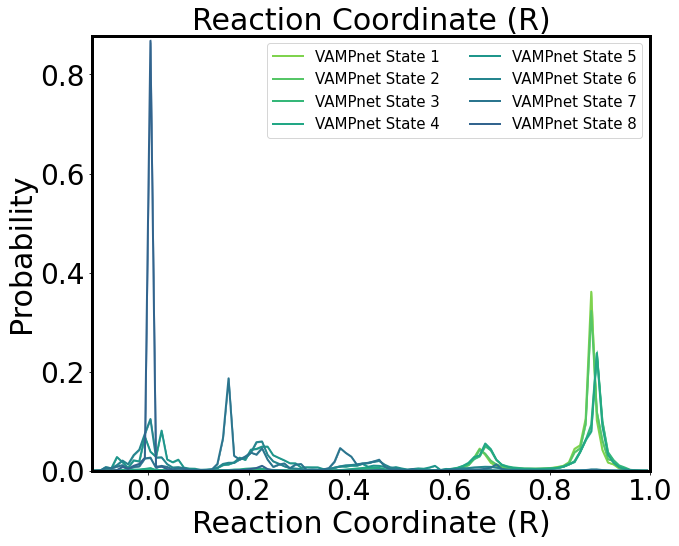

In [26]:
##rnx coordinate distrbution
var = "R"
title = "Reaction Coordinate (R)"
label = "Reaction Coordinate (R)"
fig, ax = plt.subplots(1,figsize = (10,8))
ax.set_title(title,size=30)
ax.set_xlabel(label, size=30)
ax.set_ylabel("Probability", size=30)
ax.tick_params(labelsize = 28)
# offset = matplotlib.transforms.ScaledTranslation(2, 0, fig.dpi_scale_trans)
# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)
#     ax.set_xticks(np.arange(0,1,.2).round(1),np.arange(.2,1.2,.2).round(1))
ymax = 0
#     _,bins = np.histogram(d[var], bins = len(stat_dict[var]["dist"]["mean"][0]))
#     x_axis = bins[:-1] + np.diff(bins)/2
for i in range(8):
    ax.plot(stat_dict[var]["dist"]["bin_centers"],
            stat_dict[var]["dist"]["mean"][i],alpha=1,color=clist[i],label = f"VAMPnet State {i+1}",lw = 2)

    ax.fill_between(stat_dict[var]["dist"]["bin_centers"],
                    stat_dict[var]["dist"]["ci95"][0,i],
                    stat_dict[var]["dist"]["ci95"][1,i],
                    color = clist[i], alpha = 0.5)

    ax.legend(fontsize=15,ncol = 2)
    ax.set_xlim(d[var].min(),d[var].max())
    ymax = max(ymax,stat_dict[var]["dist"]["mean"][i].max())
    #ax.tick_params(axis="both", labelsize = 18)
    ax.set_ylim(0,ymax+.01)

(-0.11265822479626697, 1.0)

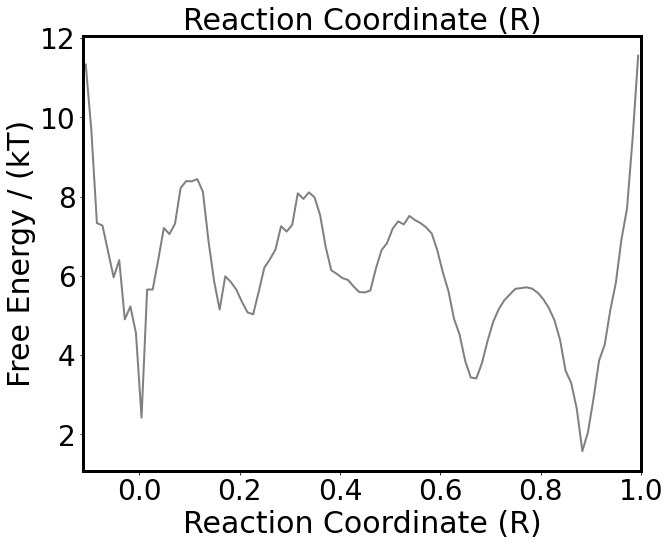

In [27]:
##rnx coordinate FE
var = "R"
title = "Reaction Coordinate (R)"
label = "Reaction Coordinate (R)"
fig, ax = plt.subplots(1,figsize = (10,8))
ax.set_title(title,size=30)
ax.set_xlabel(label, size=30)
ax.set_ylabel("Free Energy / (kT)", size=30)
ax.tick_params(labelsize = 28)
ymax = 0
pr,x = pmf1d(d["R"],nbins=100)
ax.plot(x,-np.log(pr),alpha=1,color="grey",lw = 2)
ax.set_xlim(d[var].min(),d[var].max())



<Figure size 432x288 with 0 Axes>

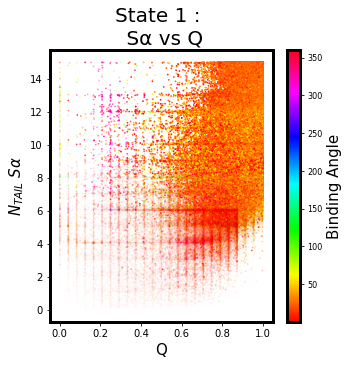

<Figure size 432x288 with 0 Axes>

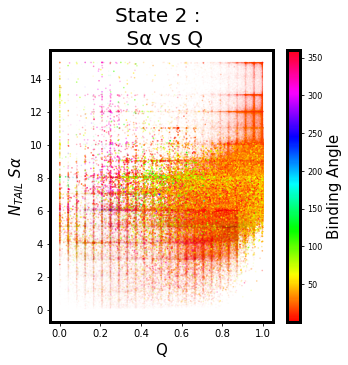

<Figure size 432x288 with 0 Axes>

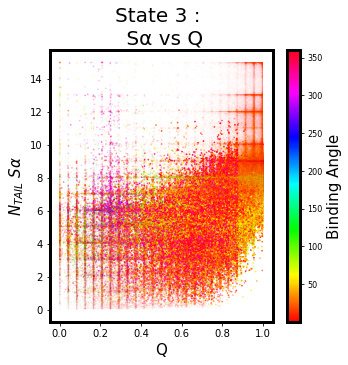

<Figure size 432x288 with 0 Axes>

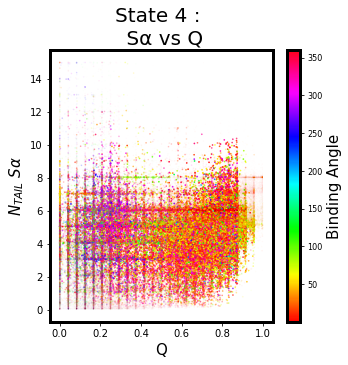

<Figure size 432x288 with 0 Axes>

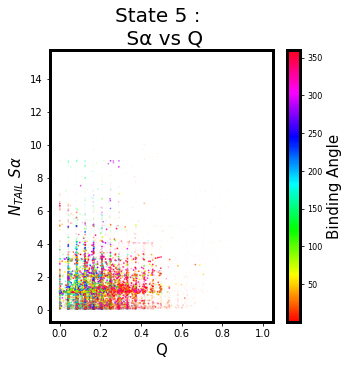

<Figure size 432x288 with 0 Axes>

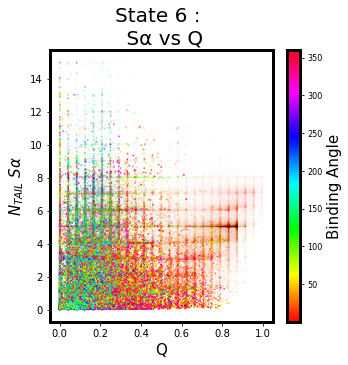

<Figure size 432x288 with 0 Axes>

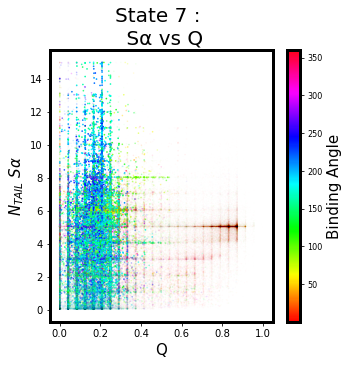

In [28]:
##UGLY projection of binding angle onto sa vs q surface for each state
for state in [0,1,2,3,4,5,6]:
    plt.figure()
    proj2d(p = np.stack([d["QP"], d["Sa_total"]], axis = 1),c = d["ang"][1:],alpha = chi_data[:,state].flatten(), cmap = "hsv",
          x_label = "Q", y_label = r"$N_{TAIL}$ $S\alpha$", cbar_label = "Binding Angle",
          title = f"State {state+1} : \n S{symbols['alpha']} vs Q")

chi_result = koop.predict_chi()
p_ = np.load("/home/t/drmsm/dist_sa_tics_lag30.npy")
fig,axes = plt.subplots(4,3, figsize = (20,20))
for i,ax in zip(range(chi_data.shape[-1]),axes.flat):
    proj2d(p_,c=chi_running_sum[:,i],ax=ax)

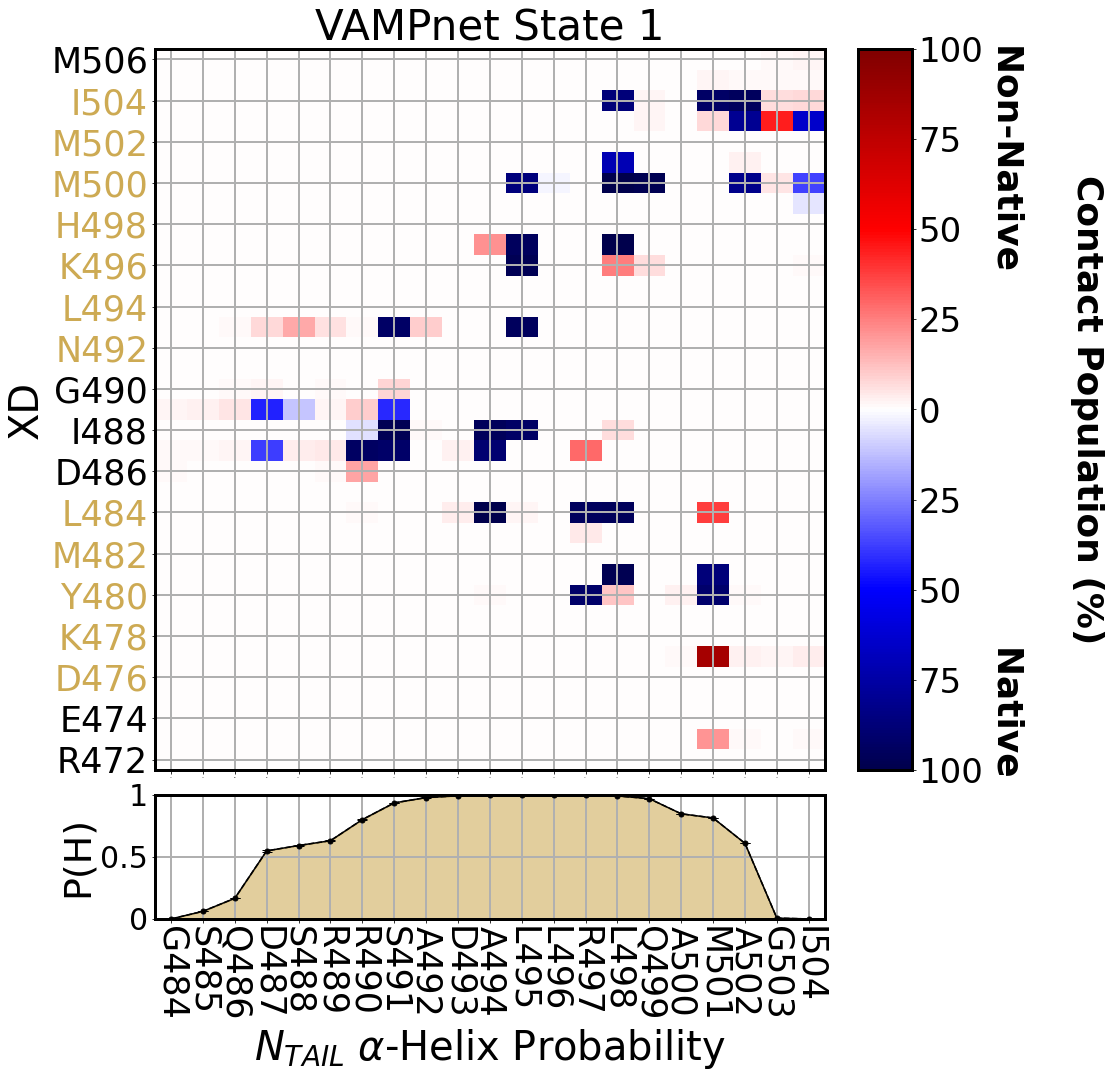

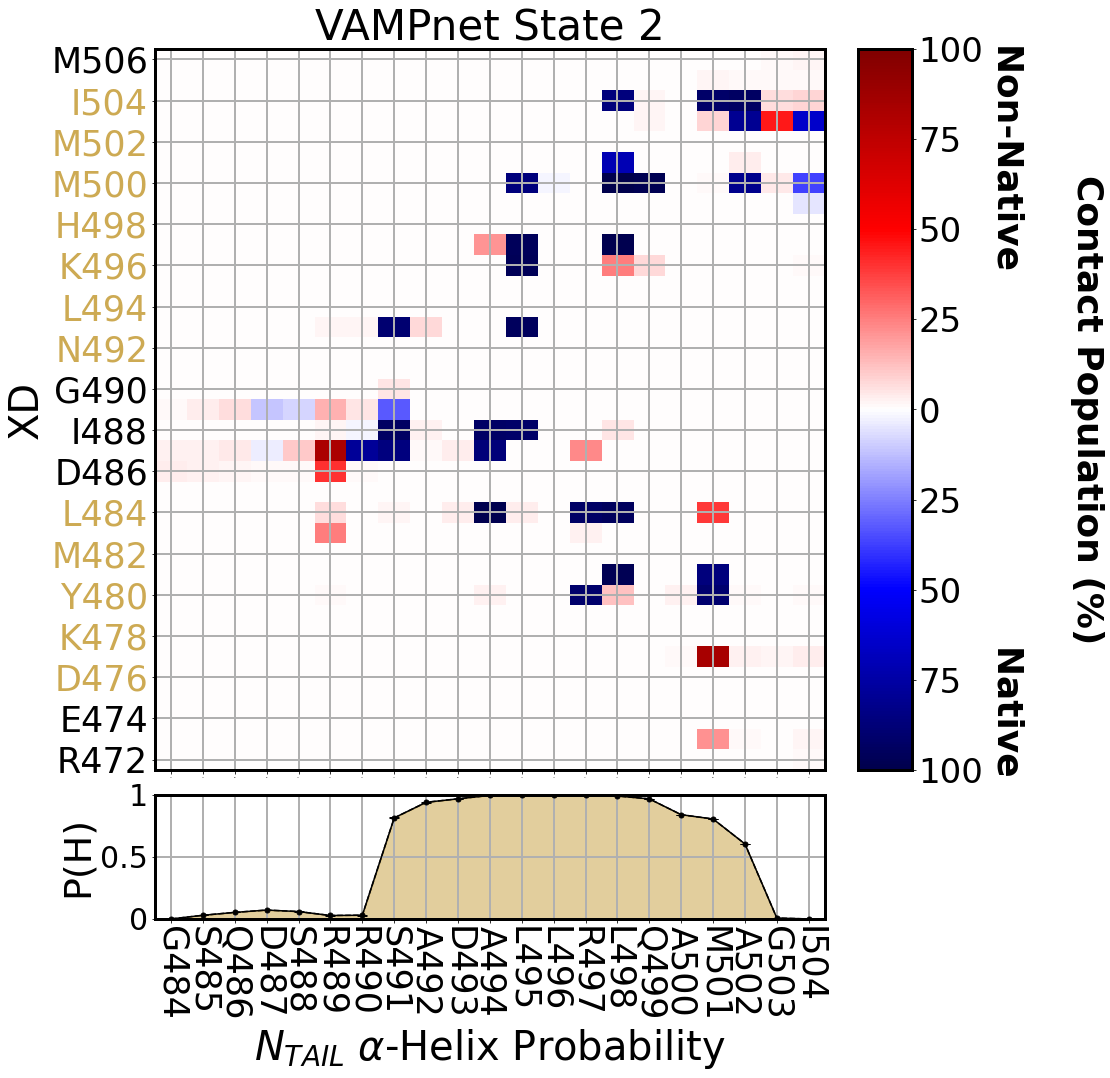

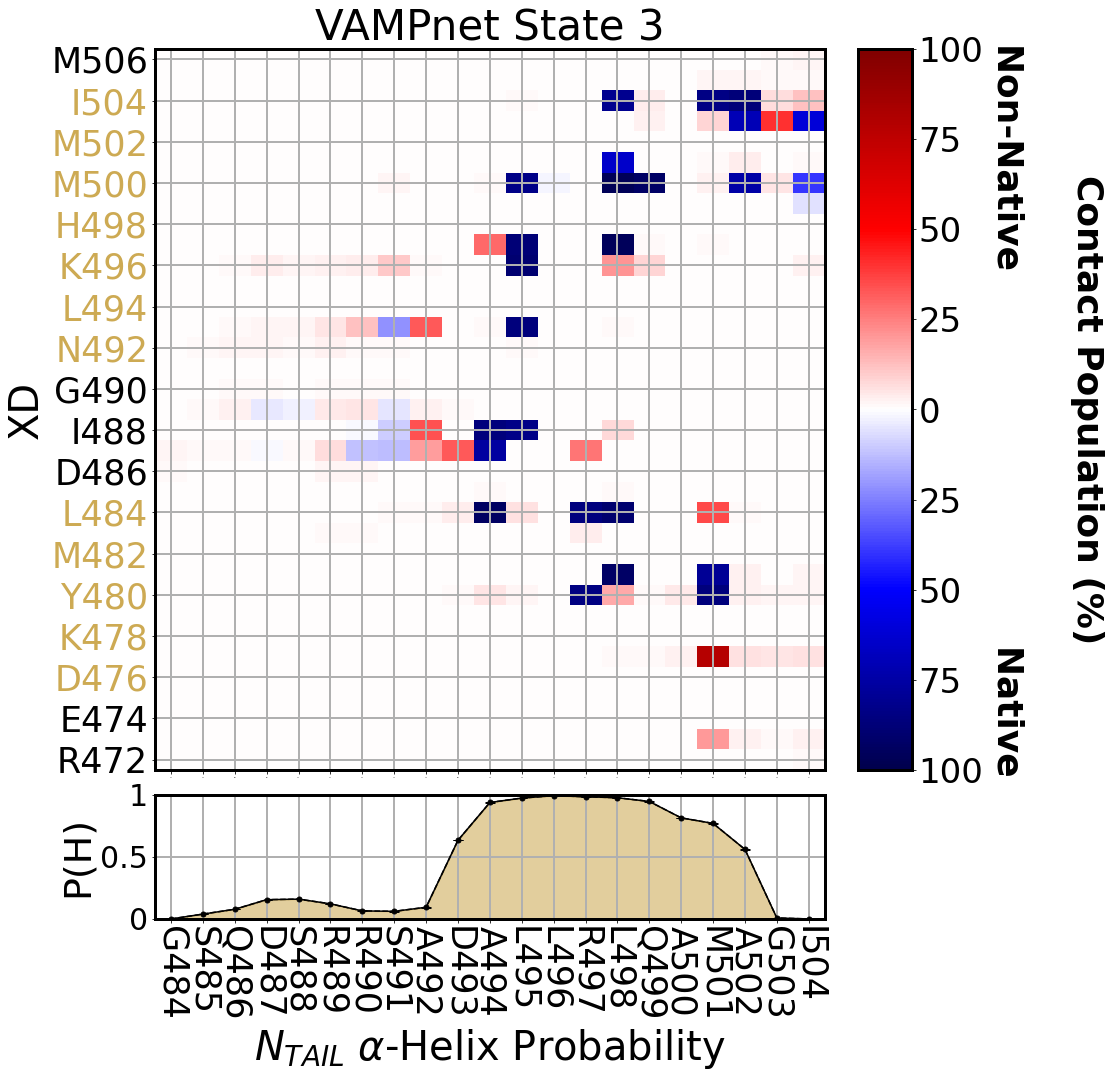

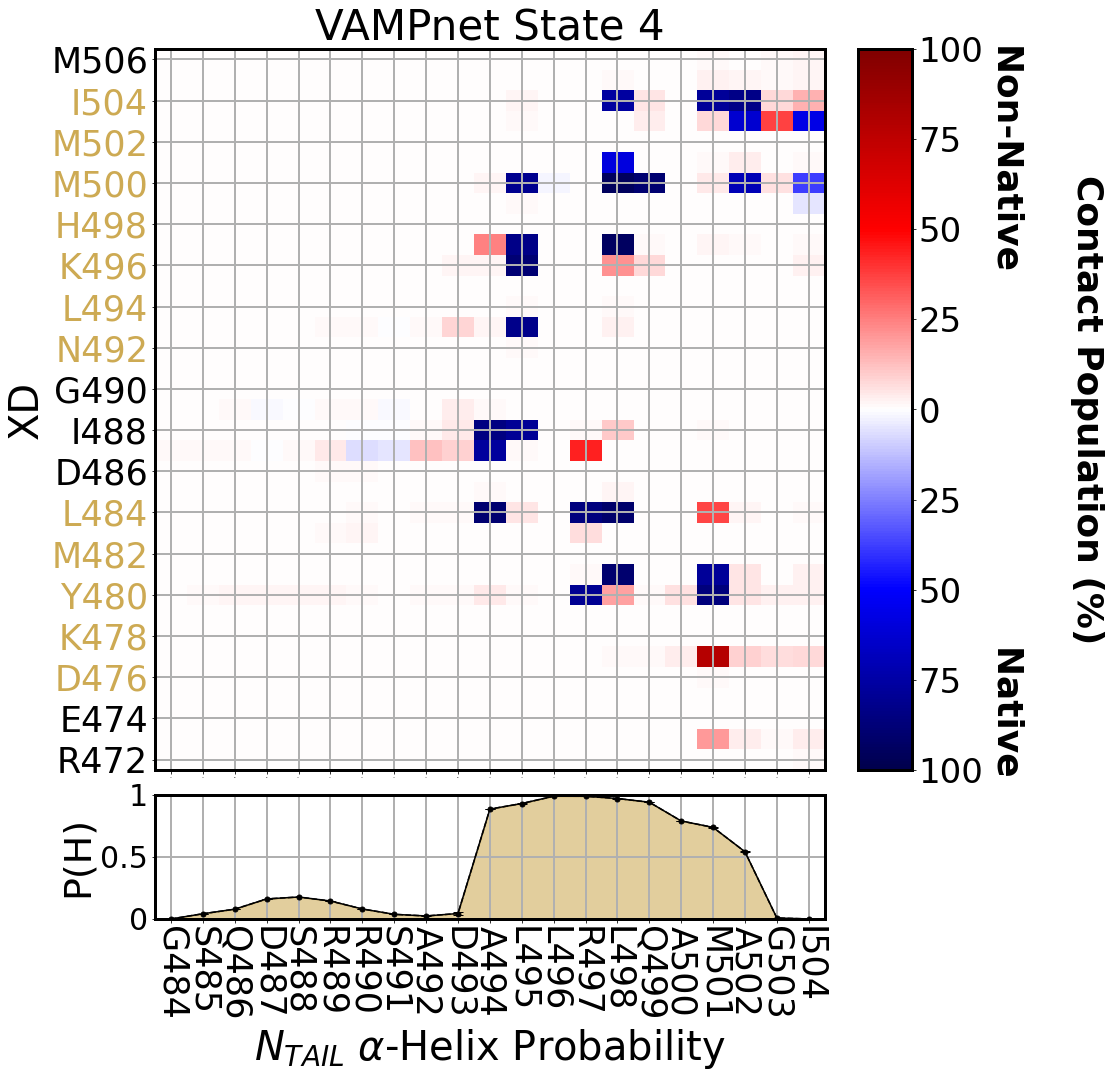

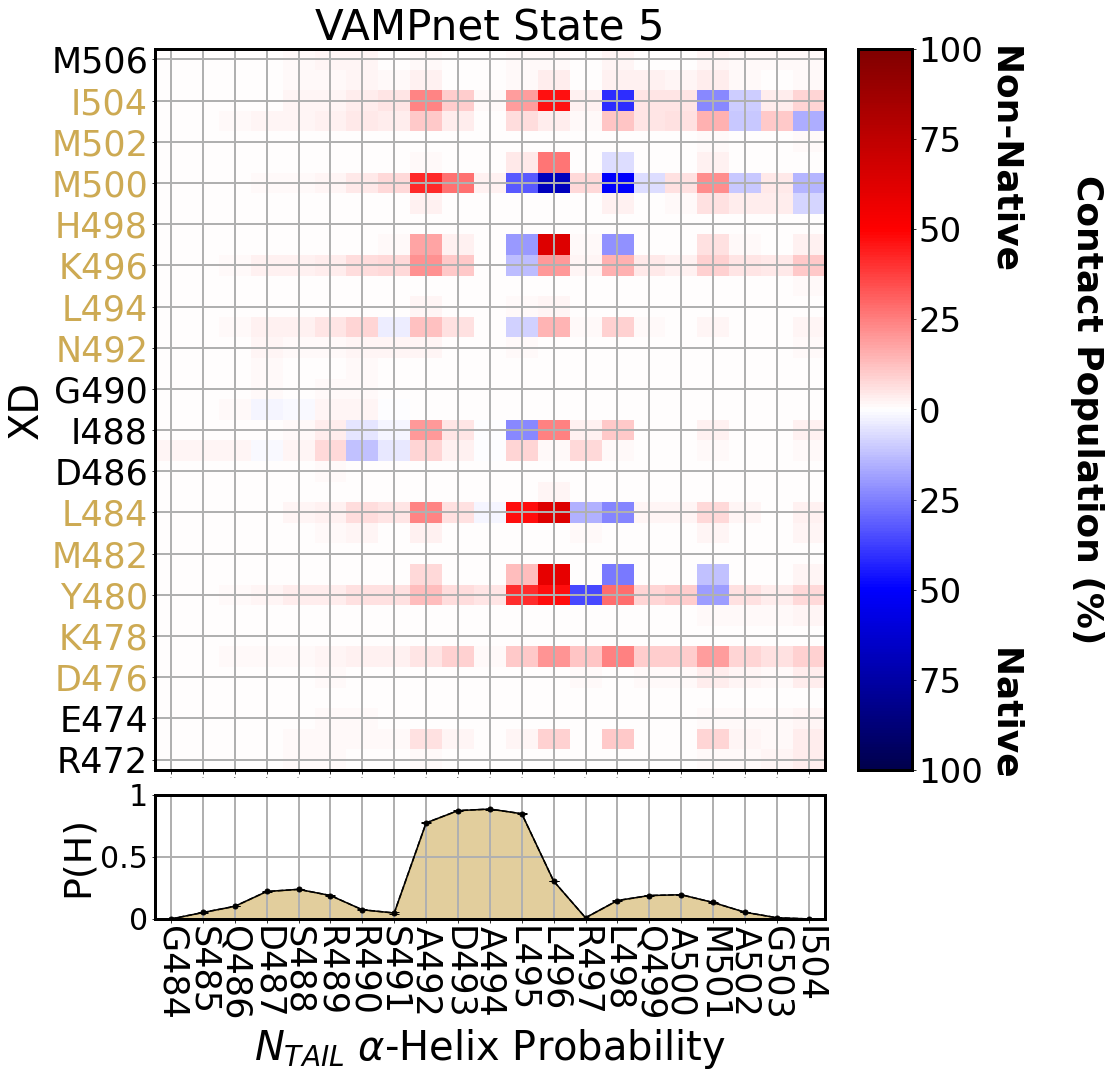

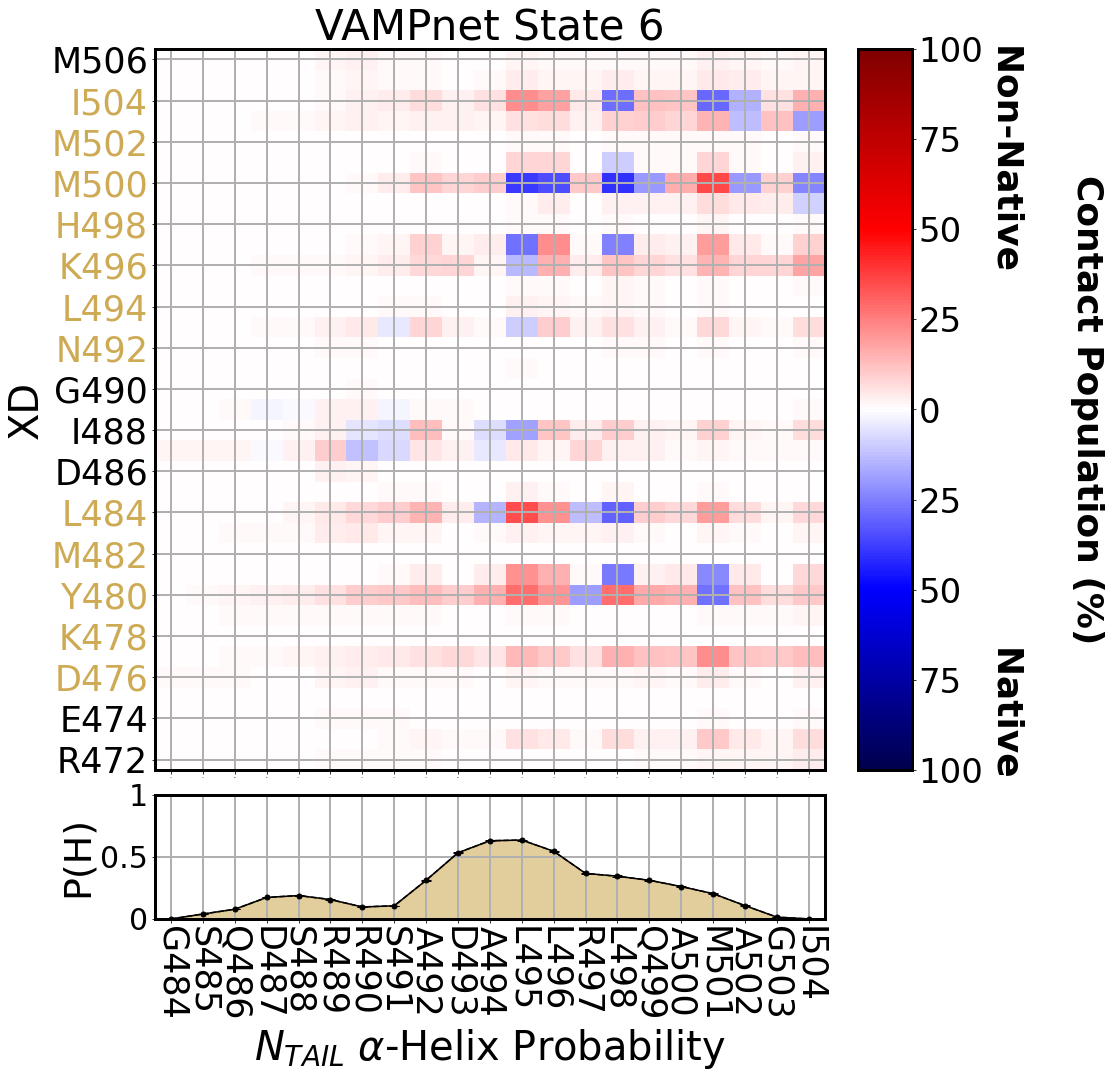

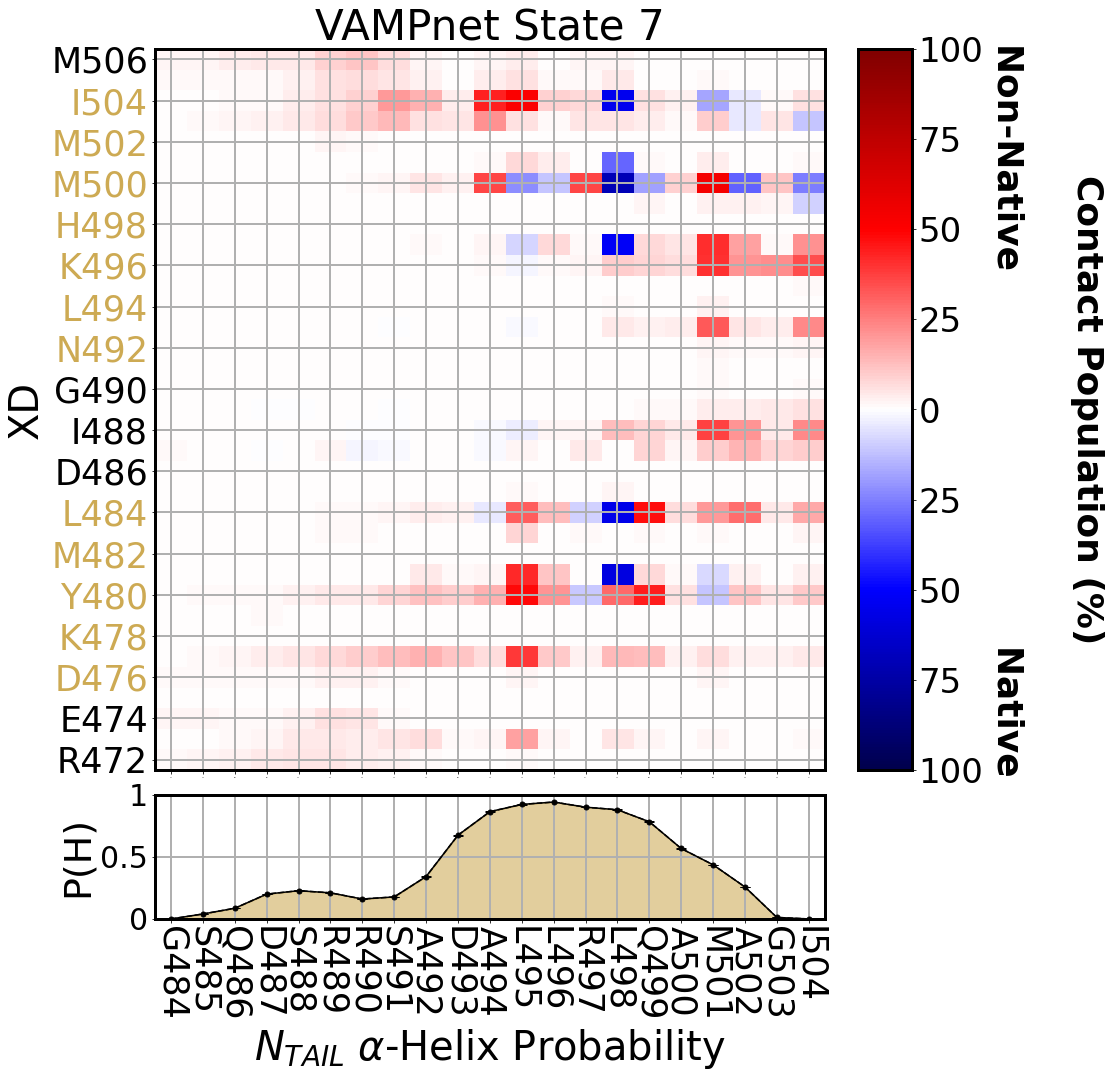

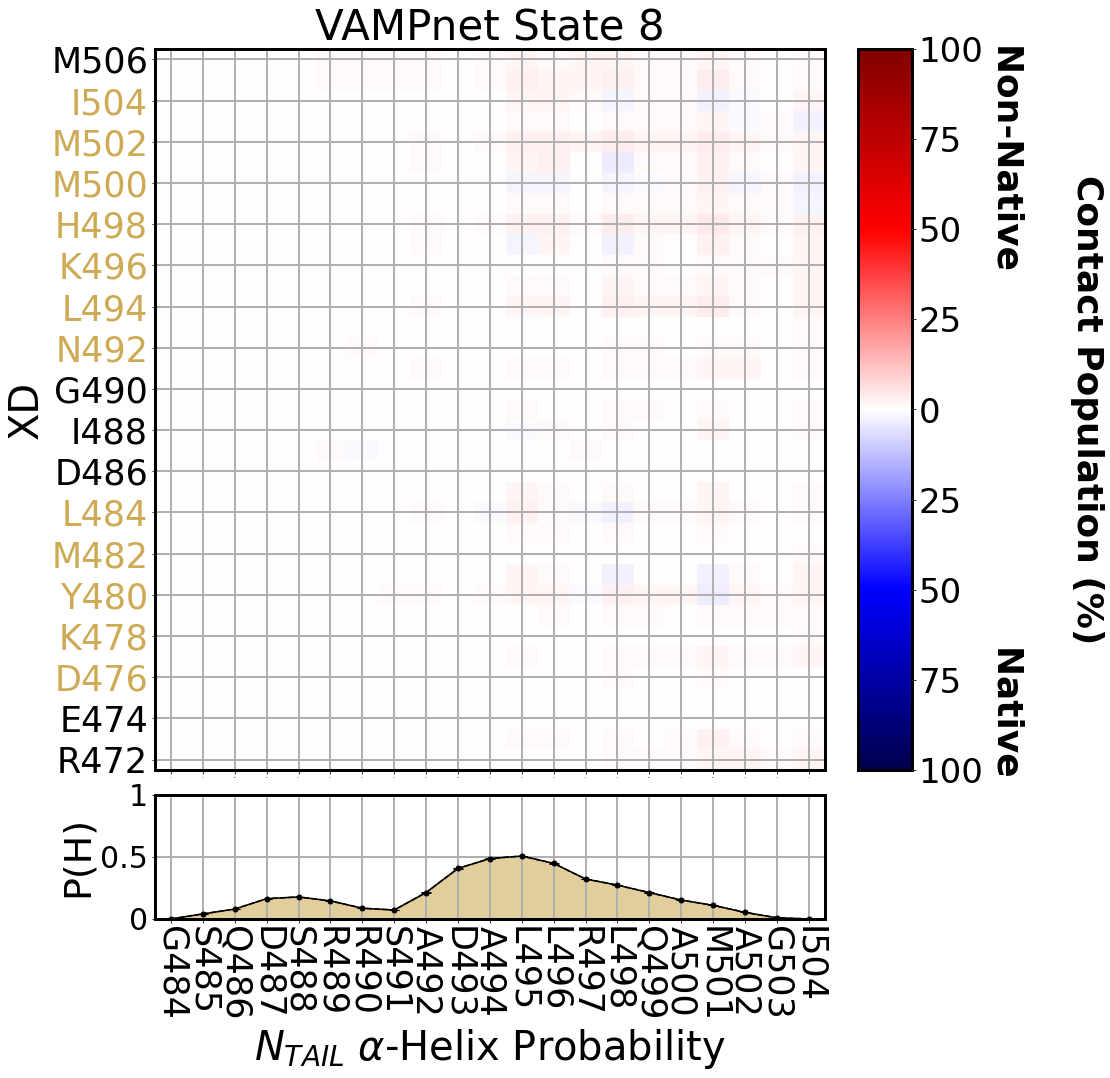

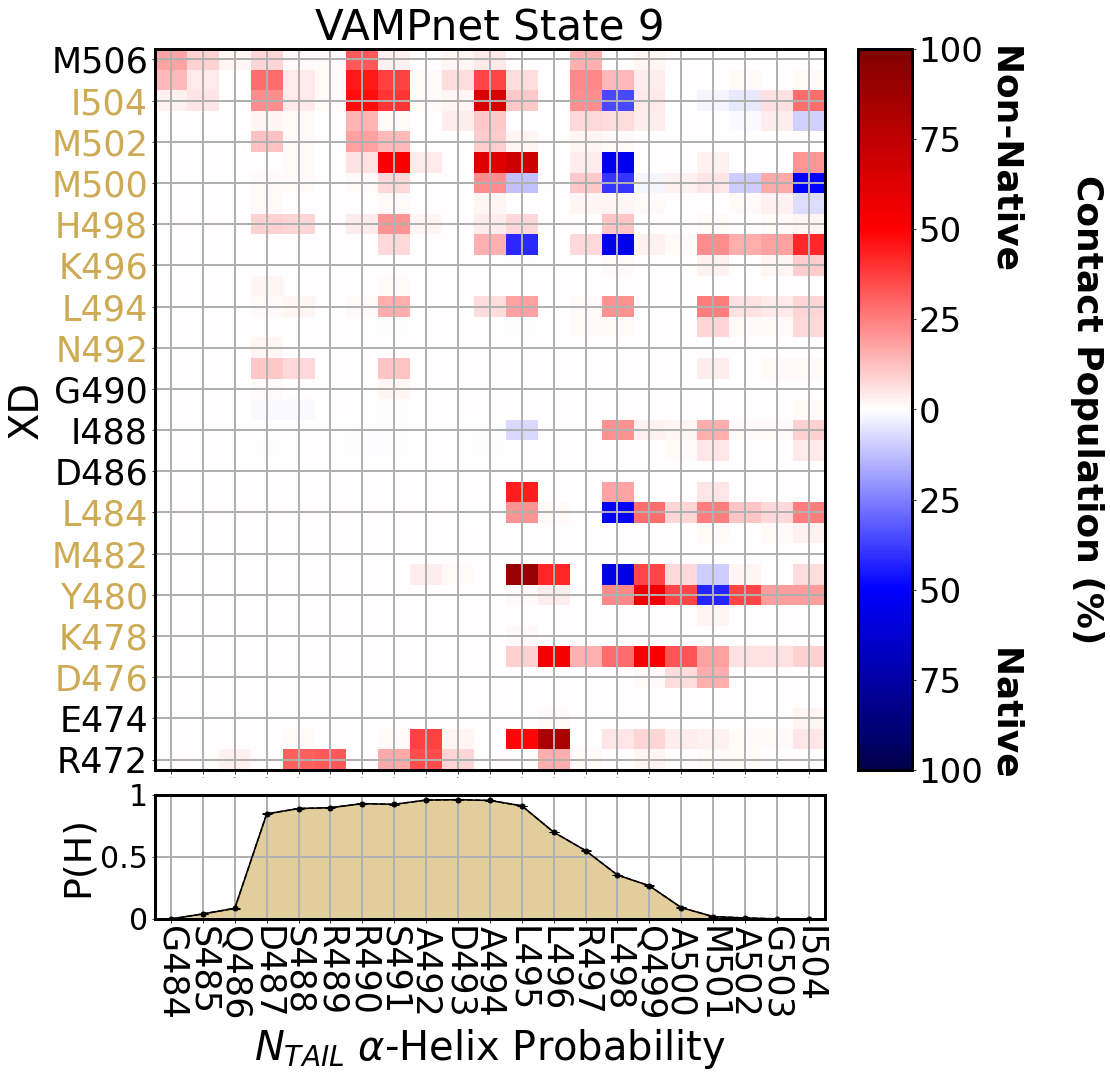

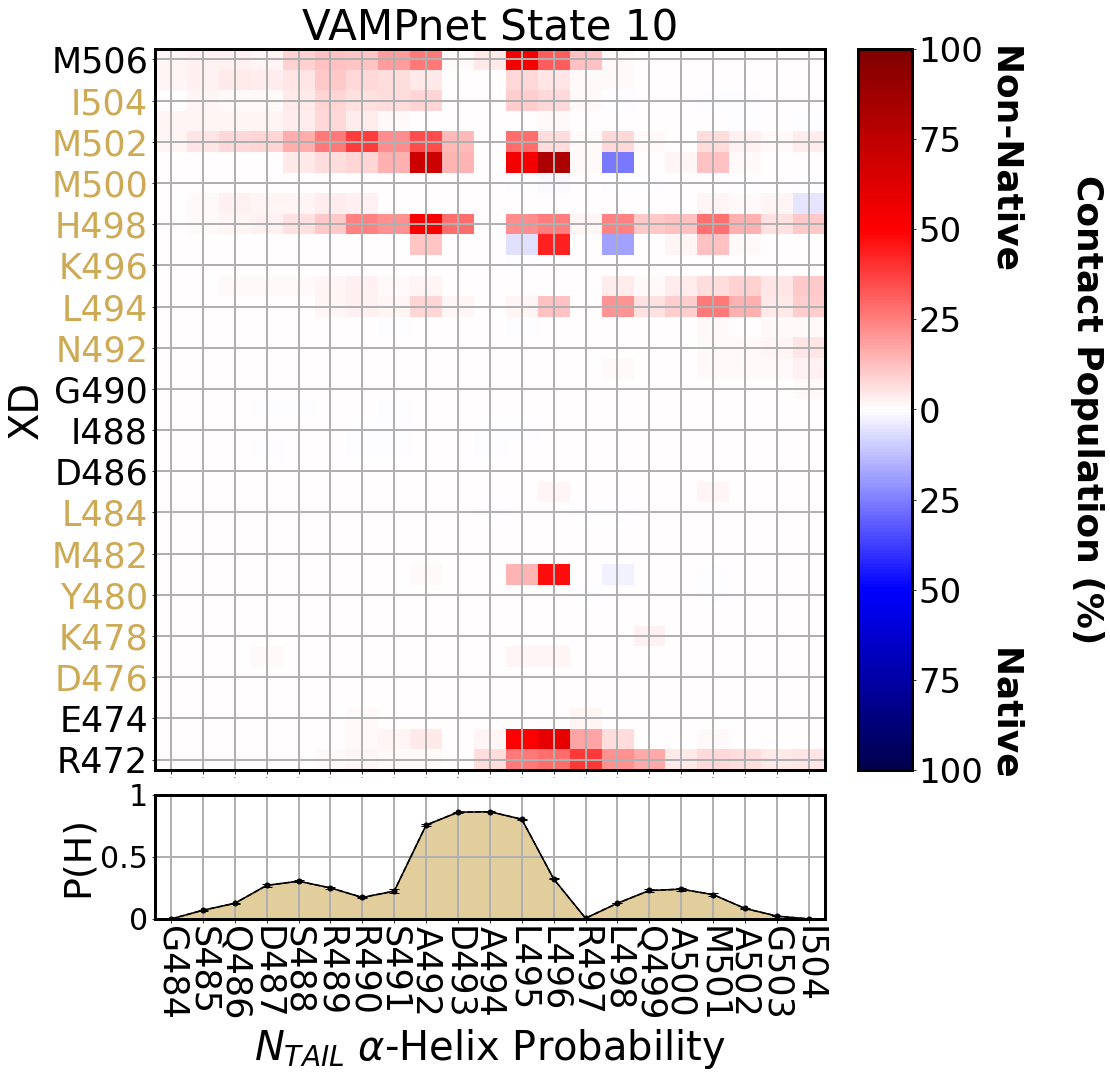

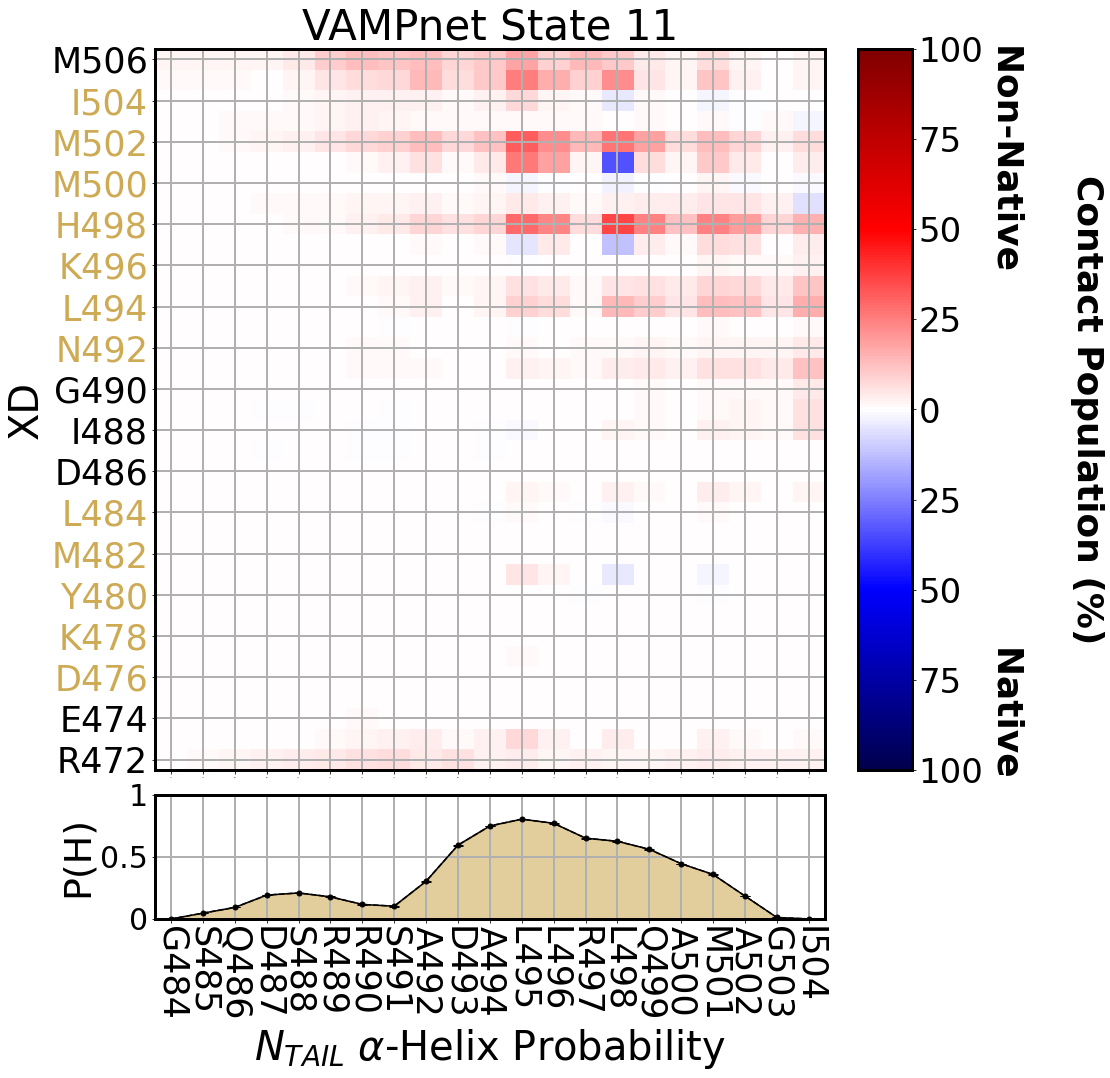

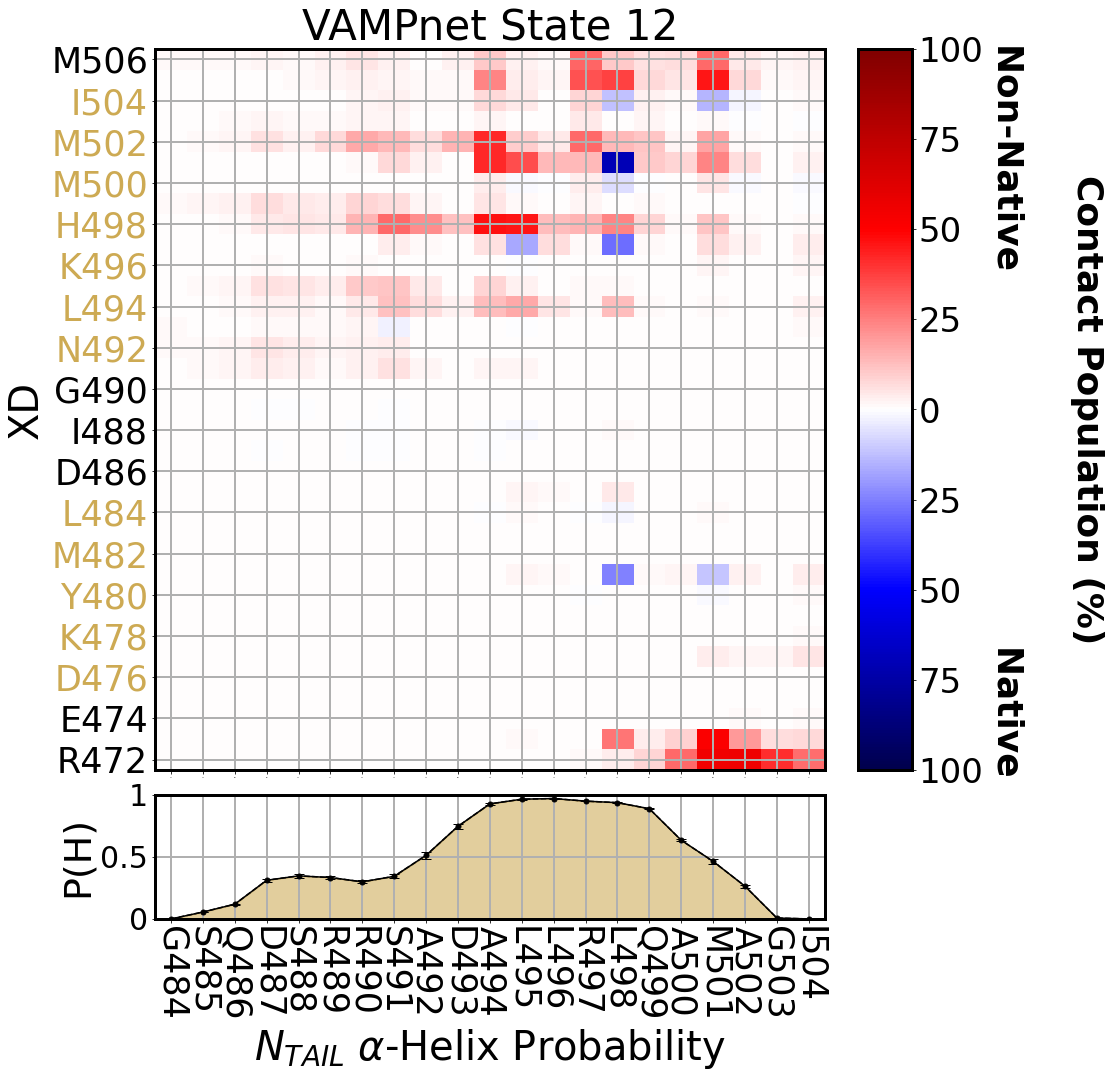

In [36]:
#contact maps with bagged/bootstrapped data
import warnings
warnings.filterwarnings("ignore")

from matplotlib.gridspec import GridSpec

##native contacts are taken as those >.5nm in crystal structure
## pulling these in from another notebook to avoid loading the trajectory, here
native_idx = np.array([475, 479, 497, 500, 556, 559, 560, 612, 615, 616, 619, 636, 637,
       640, 641, 654, 655, 658, 742, 746, 809, 830, 833, 881, 893, 894,
       896, 897, 900, 902, 917, 963, 965, 980, 983, 984])

xdsscdict = {"H":"darkgoldenrod","C":"black"}
index_res_color = dict(zip(list(d["index"]),[*map(lambda x:xdsscdict[x],d["xdss"])]))
columns = d["columns"]
cut = 14

ave_dssps["ci95"][np.isnan(ave_dssps["ci95"])]= 0

def contact_maps_helix(flat_map:"average contact population",dssp:"average dsspH for state",dssp_error,
                       native_index:"indices of native distances", index:list, columns:list,
                       index_res_color:list,ci:int,cut:int,
                       xlabel:str, ylabel:str, title: str):
        flat_map = np.copy(flat_map)
        flat_map[native_idx]*=-1
        flat_map = flat_map.reshape(len(index), len(columns))
        fig = plt.figure(figsize=(12,16),constrained_layout=True)
        grid = GridSpec(6, 3, hspace=.2, wspace=0.2)
        ax = fig.add_subplot(grid[:-1,:])
        im=ax.imshow(100*np.flip(flat_map[cut:],axis=0),cmap='seismic',aspect='auto',vmin= -100, vmax=100 )
        #ax.grid(which="both",alpha=0.5)
        ax.grid(which="both",alpha = 1,lw=2)
        ax.set_yticks(range(len(index[cut:]))[::2],np.flip(index[cut:])[::2],size=35)
        ax.set_xticks(np.arange(21),["" for i in range(21)],size=0)
        ax.set_title(title + f" State {ci}",size=42)
        ax.set_ylabel(ylabel, size = 40)
        cb = ax.inset_axes([1.05,0,.08,1],transform = ax.transAxes)
        cbar = fig.colorbar(im,cax=cb,orientation = "vertical")
        cbar.ax.tick_params(labelsize=34)
        
        cb_label =  "          Contact Population (%)          \n\nNon-Native                              Native"
        
        cbar.set_label(cb_label,size=36, rotation = 270, labelpad = 120, fontweight = "bold")
        
        cbar.set_ticklabels(abs(np.arange(-100,101,25)))
        dp = fig.add_subplot(grid[-1, :], sharex=ax)
        fig.execute_constrained_layout()
        dp.fill_between(np.arange(21), dssp, color="darkgoldenrod", alpha = .4)
        dp.set_xticks(np.arange(21), columns, rotation = -90, ha = "center",size = 35)
        dp.plot(dssp,color = "black", ls="--",marker = ".",ms=10)
        dp.errorbar(np.arange(21), dssp, yerr = dssp_error, alpha=1, color = "black",capsize = 5 )
        dp.set_xlabel(xlabel,size = 40)
        dp.set_ylim(0,1)
        dp.set_yticks([0,.5,1], [0,.5,1],size = 30)
        dp.grid(which="major", alpha = 1, lw=2)
        dp.set_ylabel("P(H)", size=38)
        for i in ax.get_yticklabels():
            if index_res_color[i.get_text()]!="black":i.set_alpha(.7)
            i.set_color(index_res_color[i.get_text()])

for i in range(12):   
    contact_maps_helix(flat_map = ave_contacts["mean"][...,i], 
                       dssp = ave_dssps["mean"][...,i],
                       dssp_error = ave_dssps["ci95"][...,i],
                       native_index = native_idx,
                       index = d["index"], 
                       columns = columns,
                       index_res_color = index_res_color,
                       ci = i+1,
                       cut = 14,
                       xlabel = r"$N_{TAIL}$ $\alpha$-Helix Probability",
                       ylabel = "XD",
                       title = "VAMPnet")

 # derive coloring for each residue in gradient structures based on average fraction of native and non native contact fractions


In [ ]:
def replace_nan(x, val:float = 0):
    x[np.isnan(x)] = val
    return x

contacts = np.copy(ave_contacts["mean"])
b = np.isin(np.arange(len(d["pairs"])), native_idx)
nat_pairs = d["pairs"][b]
non_pairs = d["pairs"][~b]
nat_contacts = (contacts*b[:,None].astype(int)).T.reshape(12,49,21)
non_contacts = (contacts*~b[:,None].astype(int)).T.reshape(12,49,21)
nat_norm = b.astype(int).reshape(49,21)
non_norm = ~b.astype(int).reshape(49,21)

nt_nat,xd_nat = [replace_nan(nat_contacts.sum(i+1)/nat_norm.sum(i)) for i in range(2)]
tot_nat_norm = max(nt_nat.max(),xd_nat.max())
nt_nat,xd_nat = [i/tot_nat_norm for i in [nt_nat,xd_nat]]

nt_non,xd_non = [replace_nan(non_contacts.sum(i+1)/non_norm.sum(i)) for i in range(2)]
tot_non_norm = max(nt_non.max(),xd_non.max())
nt_non,xd_non = [i/tot_non_norm for i in [nt_non,xd_non]]


 # these are helper functions to reteive specific contact data from ensemple averages but are not generalized (heavily depend on organization of data inputs)

In [45]:
#analyze contact probabilities and errors for each state

from IPython.display import display

def get_contact_data(pair:str,
                     state:int,
                     pairs:"np.ndarray or string residue pairs" = d["pairs"],
                     mean_contact_data:np.ndarray = ave_contacts["mean"],
                     ci_contact_data:np.ndarray = ave_contacts["ci95"],
                     mean_dist_data:np.ndarray = ave_distances["mean"],
                     ci_dist_data:np.ndarray = ave_distances["ci95"]
                    ):
    """contact data arrays are (Ncontacts,Nstates)
    returns a list with [mean,CI] for a given distance and state
    """
    state -= 1
    idx = np.where(pairs == pair)[0][0]
    ##make contacts a percentage
    mean_contact = 100*mean_contact_data[idx,state]
    ci_contact = 100*ci_contact_data[idx,state]
    ##
    mean_dist = mean_dist_data[idx,state]
    ci_dist = ci_dist_data[idx,state]
    return [mean_contact, ci_contact, mean_dist, ci_dist]


def combine_contact_stats(pairs:list, state:int, return_df = False,
                          prot_name_1:str = "XD", prot_name_2:str = "NT"):
    
    data = np.array([get_contact_data(pair = i,state = state) for i in pairs])
    pairs_display = [f"{prot_name_1}:{i.split(',')[0]}-{prot_name_2}:{i.split(',')[-1]}" for i in pairs]
    combined_stats = np.array([[data[...,i].mean(), pooled_sd(means = data[...,i], sds = data[...,i+1])] for i in [0,2]]).reshape(-1,1)
    data = np.concatenate([data.T,combined_stats], axis = 1)
    df = pd.DataFrame(data = data, columns = pairs_display+["Cumulative Average (propogated error)"],
                      index = "Contact Probability (%),95% CI contact,Ave Distance,95% CI Distance".split(","))
    df = df.style.set_caption(f"State {state}")
    display(df)
    if return_df:
        return df
    else:
        pass

 # pulling out specific contact data that coincides with the boxed contacts in the contact maps in the main text figure for the bound states

 ## Non-native Contact formation between bound states


In [46]:
##nnc means non-native contact cluster and 34 deontes the states we want to compute for, we'll use this short hand for variables in this section
#first set
print("Transition state set")
nnc_transition_states = [",".join([i,j]) for i,j in zip("TYR480,LEU481,LEU484,PHE497,ILE504".split(","),["LEU496"]*5,)]
combine_contact_stats(pairs = nnc_transition_states, state = 7)
combine_contact_stats(pairs = nnc_transition_states, state = 6)
combine_contact_stats(pairs = nnc_transition_states, state = 5)

print("first bound state set")
nnc_34 = [",".join([i,j]) for i,j in zip("ASP487,ILE488,ASP493".split(","),"ASP493,ALA492,ALA492,".split(","))]
combine_contact_stats(pairs = nnc_34, state = 4)
combine_contact_stats(pairs = nnc_34, state = 3)
#second set
print("\nsecond bound state set\n")
nnc_23 = [",".join([i,j]) for i,j in zip("THR483,ASP486,ASP487".split(","),["ARG489"]*3)]
combine_contact_stats(pairs = nnc_23, state = 3)
combine_contact_stats(pairs = nnc_23, state = 2)
combine_contact_stats(pairs = nnc_23, state = 1)

Transition state set


first bound state set



second bound state set



 ## Native Contact formation between bound states

In [47]:
##nc means native contact cluster and 34 deontes the states we want to compute for
#first set
print("first set")
nc_32 = [",".join([i,j]) for i,j in zip("ASP487,ASP487,ILE488,ASP493".split(","),"ARG490,SER491,SER491,SER491,".split(","))]
combine_contact_stats(pairs = nc_32, state = 3)
combine_contact_stats(pairs = nc_32, state = 2)
#second set
print("\nsecond set\n")
nc_21 = [",".join([i,j]) for i,j in zip("ASP487,LYS489".split(","),["ASP487"]*2)]
combine_contact_stats(pairs = nc_21, state = 2)
combine_contact_stats(pairs = nc_21, state = 1)

first set



second set



 # Intramolecular salt bridge between NTAIL residues R497 and D493
 

In [42]:
salt_bridge_distance  = bagged_stat(ckpt_dirs=all_ckpts, file = "salt_bridge_distance", name = "R497:D493 Dist",compute_sd = True, compute_ci = True, make_df = True, display_df = True)

$<R497:D493 Dist>$  95% CI of mean  $R497:D493 Dist_{\sigma}$
1             0.568517        0.000435                   0.229054
2             0.646197        0.000552                   0.222582
3             0.558464        0.000894                   0.238801
4             0.761167        0.006605                   0.196627
5             1.089493        0.005506                   0.203864
6             0.813484        0.002202                   0.373418
7             0.685628        0.000842                   0.281263
8             0.916393        0.001855                   0.400080
9             0.654432        0.001588                   0.278327
10            1.051704        0.005703                   0.229748
11            0.745937        0.002519                   0.320493
12            0.723752        0.000943                   0.266682

In [43]:
salt_bridge_contact  = bagged_stat(ckpt_dirs=all_ckpts, file = "salt_bridge_contact", name = "R497:D493 contact",compute_sd = True, compute_ci = True, make_df = True, display_df = True)

$<R497:D493 contact>$  95% CI of mean  $R497:D493 contact_{\sigma}$
1                0.244713        0.000768                      0.429917
2                0.099223        0.001184                      0.298962
3                0.266046        0.000602                      0.441889
4                0.041517        0.009566                      0.199483
5                0.010703        0.001931                      0.102902
6                0.111000        0.000419                      0.314133
7                0.143603        0.000281                      0.350687
8                0.083881        0.000351                      0.277209
9                0.200077        0.001315                      0.400058
10               0.019785        0.002442                      0.139259
11               0.121704        0.000743                      0.326943
12               0.112781        0.001385                      0.316324

 # Transition path analysis

In [39]:
#compute flux
from deeptime.markov import reactive_flux
#deeptime doesn't think out matrices are normalized enough (within numerical/rounding error)
all_paths = []
path_dict = {}

def renormalize(mat, tol=1e-12, axis=1):
    n = mat.shape[0]
    while abs(np.ones(n) - mat.sum(axis=axis)).max() > tol:
        mat = abs(mat) / abs(mat).sum(axis=axis)
    return mat

for i,mat in enumerate(transition_matrix_all):
    tpt  = reactive_flux(transition_matrix = renormalize(mat),
                         source_states = [7],
                         target_states = [0],
                         transition_matrix_tolerance = None)
    paths, path_fluxes = tpt.pathways()
    path_fluxes /= (tpt.total_flux/100)
    paths = ["-".join((i+1).astype(str).tolist()) for i in paths]
    for path,flux in zip(paths,path_fluxes):
        if path in list(path_dict.keys()):
            path_dict[path].append(flux)
        else:
            path_dict[path] = [flux]

#get fluxes with fractions greater than 1%
path_df = pd.DataFrame({key:{"mean":np.array(val).mean(),"ci95":ci(np.array(val),mean = False, iv = .95, single_value = True)}
             for key,val in path_dict.items() if 1<np.array(val).mean()}).T.sort_values("mean", ascending = False)


In [40]:
path_df

mean      ci95
8-6-3-1          28.166736  2.683296
8-6-4-3-2-1      16.105997  1.216362
8-4-3-1          13.646364  1.114785
8-4-3-2-1        12.792425  0.958761
8-6-2-1          10.713321  0.882666
8-7-4-2-1         6.313386  2.154288
8-7-3-1           4.899841  3.981758
8-3-1             4.472469  1.171741
8-6-7-4-2-1       4.383608  0.337402
8-3-2-1           3.936787  0.941907
8-6-1             3.583008  1.387465
8-11-12-4-3-2-1   3.312071  0.193857
8-11-12-4-3-1     3.204475  0.612612
8-11-6-1          3.198759  0.229287
8-11-6-7-3-2-1    2.996147  0.320073
8-11-6-7-4-3-1    2.748564       NaN
8-7-3-2-1         2.349274       NaN
8-7-4-1           2.147045       NaN
8-11-6-7-3-1      2.130298  4.535506
8-11-7-3-1        2.106128       NaN
8-11-7-3-2-1      2.053676  0.184890
8-11-4-2-1        1.944699       NaN
8-11-7-4-2-1      1.874327       NaN
8-7-2-1           1.477173  0.146939
8-11-7-2-1        1.207942  2.355442
8-12-7-3-1        1.200215       NaN
8-11-7-4-1        1.188443  9.192288
8-11-4-3-2-1      1.168422  0.890128
8-11-4-1          1.081821  0.603017
8-12-7-2-1        1.068252  1.338610

 # RXN coordinate from Robustelli et al. (JACS 2020)

In [41]:
weights = np.array([1.273238493439205754e-01, 
-2.879377330423275178e-02,
7.959961278799894402e-03 ,
5.518877703587558858e-02 ,
1.447885791856179660e-01 ,
-2.046497461666178241e-01 ,
-9.407667503330571779e-02 ,
2.458163405564077302e-03 ,
-1.056967789913624556e-01 ,
3.094038782220783629e-02 ,
-5.244123813230915088e-02 ,
1.038284243381899646e-01 ,
6.997143128145444368e-02 ,
9.489681641360745434e-01 ,
1.392196298507814012e-03 ,
-1.027897380195364335e-01 ,
-3.834583521098668124e-02 ,
9.450397928830094330e-01 ,
9.753032773707831504e-01 ,
9.462317609409237606e-01 ,
-2.677764974354817501e-02 ,
4.113919419970671343e-02 ,
-4.530511596647011224e-02,
-4.407928168993272694e-02])
def switch(x):
    return 1/(1+np.exp(100*(x-.5)))
ps = d["native_pairs"]
psi = d["native_idx"]
#revert to exact native contacts used in Robustelli et al (JACS 2020)
psi = np.delete(psi,12,axis=0)
ps = np.delete(ps,12)
natdist =  d["dmat"][:,psi]
natq = switch(natdist)
R = (natq@weights); R /= R.max()